<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230816_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [32]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [33]:
main_figsize=(15,3)

plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


In [34]:
# Define the Generator
# bucket에 대해 x를 전처리
class Generator(nn.Module):

    def __init__(self,input_dim):
        super(Generator, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [35]:
# Define the Discriminator
# 비즈니스에 해당하는 모델
class Discriminator(nn.Module):

    def __init__(self, input_dim=5):
        """Initializes Discriminator with torch components."""
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [36]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
import scipy

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Ent(MI{bk})']= []

        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []
        test_analysis[f'Ent(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    test_analysis['TrainEnt(MI)']= []

    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Ent(MI)']= []

    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []
    test_analysis['Test Ent(DR)']= []

    if model2_ == None:
        ax = XS_test[:,0:b_dim]
        ref_ax = XS_train[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)

    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    test_analysis['Test Std(MI)'].append(np.std(mi_scores))
    test_analysis['Test Ent(MI)'].append(scipy.stats.entropy(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))
    test_analysis['Test Ent(DR)'].append(scipy.stats.entropy(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    test_analysis['TrainStd(MI)'].append(np.std(mi_scores))
    test_analysis['TrainEnt(MI)'].append(scipy.stats.entropy(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))
        test_analysis[f'Ent(MI{bk})'].append(scipy.stats.entropy(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))
        test_analysis[f'Ent(DR{bk})'].append(scipy.stats.entropy(ks[:,0]))

    print("Test f1 score: {}".format(f1))

    test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1,test_analysis_df

In [37]:

def test_all_data(discriminator,generator,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if generator == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = generator(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = discriminator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [38]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        mi = torch.cat(h, dim=1)
        return mi

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret

        return loss #, ret.sum().reshape(-1,)

In [61]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    #seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    discriminator = Discriminator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Generator(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)

    mine_loss = customLoss(mine).to(device)
    optimizer_M = torch.optim.Adam(mine_loss.parameters(), lr=0.001)
    #kld_loss = nn.KLDivLoss(reduction='batchmean')
    default_value = torch.tensor([0.5],dtype=torch.float32).to(device)
    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = discriminator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()
        '''
        if lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------

            xs_test = adapter(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
            #x_sample = Variable(torch.clone(xs_test), requires_grad = True)

            m_loss, lmd = mine_loss(xs_test,
                                    y_test, #generator(xs_test).reshape(-1,1),
                                    default_value)

            m_losses.append(-m_loss.cpu().data.numpy())
            f_losses.append(lmd.cpu().data.numpy())

            m_loss = m_loss.sum() * 0.01
            #m_loss.mean().backward()

            #lambda_f = lmd #.detach()
        else:
            m_loss = torch.tensor(0.0)
        '''

        if lambda_f >= 0.0:
            loss =  g_loss + a_loss + torch.std(torch.tensor((g_loss,a_loss)))   #(1.0-lambda_f) * g_loss + lambda_f * a_loss + m_loss.mean()*0.01
        else:
            loss = g_loss

        loss.backward()

        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,test_analysis = test_model(discriminator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Generator loss':a_losses,'Predictor loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,test_analysis,discriminator,adapter,df_loss

In [40]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [41]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [42]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    for c_name in df_mis.columns:
        fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
        df_mis[c_name].plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
        ax[0].set_title(f'Mutual Information of {c_name}',fontdict={'fontsize':10})

        df_drf[c_name].plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
        ax[1].set_title(f'Drift (KS-test) of {c_name}',fontdict={'fontsize':10})
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    df_mis.plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
    ax[0].set_title(f'Mutual Information',fontdict={'fontsize':10})

    df_drf.plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
    ax[1].set_title(f'Drift (KS-test)',fontdict={'fontsize':10})
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return X,Y

In [43]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({test_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [44]:
# importing the modules
from IPython.display import display

def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0,trial_count=5):

    seed_everything()

    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

    lambda_f_set = np.concatenate([[-0.1 for v in range(trial_count)],[0.0 for v in range(trial_count)]])
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table0 = {} # Original
    result_table1 = {} # Drift tolerant
    # Original
    infos2 = {}
    result_table2 = {}
    result_table2['Trial']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    # Drift tolerant
    infos3 = {}
    result_table3 = {}
    result_table3['Trial']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]


    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:
            print(f'######################### Trial {idx} for Normal model ###########################')
        else:
            idx1 = idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx1} for Drift tolerant model ###########################')

        f1,test_analysis,last_discriminator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_discriminator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table0[f'T{idx}'] = tad
            result_table2['Trial'].append(idx)

            infos2[f'T{idx}'] = (df_loss,df_mis,df_drf)
            result_table2['test_f1'].append(f1)
            result_table2['init_f1'].append(tad[0])
            result_table2['mean_f1'].append(np.mean(tad))
            result_table2['last_f1'].append(tad[-1])
            for clm in test_analysis.columns:
                if clm not in result_table2:
                    result_table2[clm] = []
                result_table2[clm].append(test_analysis[clm].values[0])

        else:
            idx1 = idx-int(len(lambda_f_set)/2)
            result_table1[f'T{idx1}'] = tad
            result_table3['Trial'].append(idx1)

            infos3[f'T{idx1}'] = (df_loss,df_mis,df_drf)
            result_table3['test_f1'].append(f1)
            result_table3['init_f1'].append(tad[0])
            result_table3['mean_f1'].append(np.mean(tad))
            result_table3['last_f1'].append(tad[-1])
            for clm in test_analysis.columns:
                if clm not in result_table3:
                    result_table3[clm] = []
                result_table3[clm].append(test_analysis[clm].values[0])



    Orginal_df = pd.DataFrame(result_table0)
    Driftto_df = pd.DataFrame(result_table1)

    original_statistics_df = pd.DataFrame(result_table2)
    drift_statistics_df = pd.DataFrame(result_table3)

    original_statistics_df.loc[len(original_statistics_df)] = original_statistics_df.mean()
    original_statistics_df.loc[len(original_statistics_df)] = original_statistics_df[0:len(original_statistics_df)-1].sem()
    original_statistics_df.at[len(original_statistics_df)-2,'Trial'] = 'mean'
    original_statistics_df.at[len(original_statistics_df)-1,'Trial'] = 'sem'

    drift_statistics_df.loc[len(drift_statistics_df)] = drift_statistics_df.mean()
    drift_statistics_df.loc[len(drift_statistics_df)] = drift_statistics_df[0:len(drift_statistics_df)-1].sem()
    drift_statistics_df.at[len(drift_statistics_df)-2,'Trial'] = 'mean'
    drift_statistics_df.at[len(drift_statistics_df)-1,'Trial'] = 'sem'

    fig, ax = plt.subplots(figsize=main_figsize)

    Orginal_df.T.plot.box(ax = ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='blue')
    ax.set_xticks([])
    Orginal_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Orginal_df.T.median().values})],axis=0).reset_index(drop=True)
    Orginal_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='blue')

    flierprops = dict(marker='.', markerfacecolor='green', markeredgecolor='none')
    Driftto_df.T.plot.box(ax=ax, flierprops=flierprops,ylabel='F1 Score',fontsize=10,color='green')
    Driftto_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Driftto_df.T.median().values})],axis=0).reset_index(drop=True)
    Driftto_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='green')

    ax.legend(['Normal model','Drift tolerant model'],ncol=2,bbox_to_anchor=(1.0, 1.0))
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('green')

    ax.set_title('Comparison of F1 score between normal model and drift tolerant model',fontdict={'fontsize':10})
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)

    Orginal_df.T.plot.box(ax = ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='blue')
    ax.set_xticks([])
    Orginal_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Orginal_df.T.median().values})],axis=0).reset_index(drop=True)
    Orginal_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='blue')

    #flierprops = dict(marker='.', markerfacecolor='green', markeredgecolor='none')
    Driftto_df.T.plot.box(ax=ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='green')
    Driftto_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Driftto_df.T.median().values})],axis=0).reset_index(drop=True)
    Driftto_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='green')

    ax.legend(['Normal model','Drift tolerant model'],ncol=2,bbox_to_anchor=(1.0, 1.0))
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('green')

    ax.set_title('Comparison of F1 score between normal model and drift tolerant model without outlier',fontdict={'fontsize':10})
    plt.show()

    max_mean_trial = int(drift_statistics_df[drift_statistics_df['mean_f1']==np.max(drift_statistics_df['mean_f1'])]['Trial'].values[0])
    print('max_mean_trial=',max_mean_trial)

    fig, ax = plt.subplots(figsize=main_figsize)
    Driftto_df[[f'T{max_mean_trial}']].plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='green',label=f'Drift tolerant model (T{max_mean_trial})')
    Orginal_df.T.median().plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='blue',label='Normal model')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title('Max F1 score of drift tolerant model with normal model median',fontdict={'fontsize':10})
    plt.show()


    og_loss,og_mis,og_drf = infos2['T0']
    df_loss,df_mis,df_drf = infos3[f'T{max_mean_trial}']

    ax = df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket')
    ax.set_title(f'Training loss at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
    og_mis.astype(np.float32).plot(ax = ax[0],linewidth=1,ylabel='MI',xlabel='bucket',legend=None)
    ax[0].set_title(f'MI of original feature',fontdict={'fontsize':10})
    df_mis.astype(np.float32).plot(ax = ax[1],linewidth=1,ylabel='MI',xlabel='bucket')
    ax[1].set_title(f'MI of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    og_drf.astype(np.float32).plot(ax=ax[0],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',legend=None)
    ax[0].set_title(f'Drift of original feature',fontdict={'fontsize':10})
    df_drf.astype(np.float32).plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket')
    ax[1].set_title(f'Drift of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    display(original_statistics_df)

    display(drift_statistics_df)

    return Orginal_df, Driftto_df, infos2, infos3, original_statistics_df,drift_statistics_df

# 이론

+ 사실 입력 $x_i$ 에서 어떤 feature가 시간에 따라 importance가 변하는지 알기 어렵다. trainset의 경우, bucket size가 크지 않을 수 있으며, 또한 I(z,b)가 분명하게 나타나지 않을 수도 있기 때문이다.
+ 따라서 아래와 같은 구조를 제안한다.
+ 실험3~4는 sensitive featrue z에 대해, G(z,b)으로 전처리 하였으나, 이번 구조는 모든 feature에 대하여 $G(x_i,b)$으로 전처리한다.
+ $I(x_i,b) > 0$ 인 feature는 G에 의해 전처리 될 것이고,$I(x_j,b) = 0$ 인 feature는 G에 의해 by-pass 되도록 학습될 것이다.

<pre>
x0 ------>|                     |- x'0 --> |                        |
x1 ------>|  Generator G(xi,b)  |- x'1 --> |                        |
x2 ------>|  (Adaptive model)   |- x'2 --> | Discriminator (D(x,g)) | -> y^
x3 ------>|                     |- x'3 --> | predictive model       |
z0 ------>|                     |- z'0 --> |                        |
                     ^
                     |
                     b
</pre>

$$
b = \{1,2,3,...N\} \in B
$$
$$
N << M
$$
$$
b_{norm} = b/M
\tag{17}
$$
$$
L_1 = H(y,\hat{y}) = H(y,D(G(x_i,b_{norm})))=\mathbb{E}_{y}[-log(D(G(x_i,b_{norm})))]
\tag{21}
$$

$$
L_2 = \sum_{i}MSE(G(x_i,b_{norm}),x_i)
\tag{22}
$$

$$
\min_{G(.)} (1-λ) L_1 + λ L_2
\tag{23}
$$

$$
\min_{G(.)} L_1 + L_2 + std(L_1,L_2)
\tag{24}
$$

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [ ]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [ ]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [ ]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.50it/s]


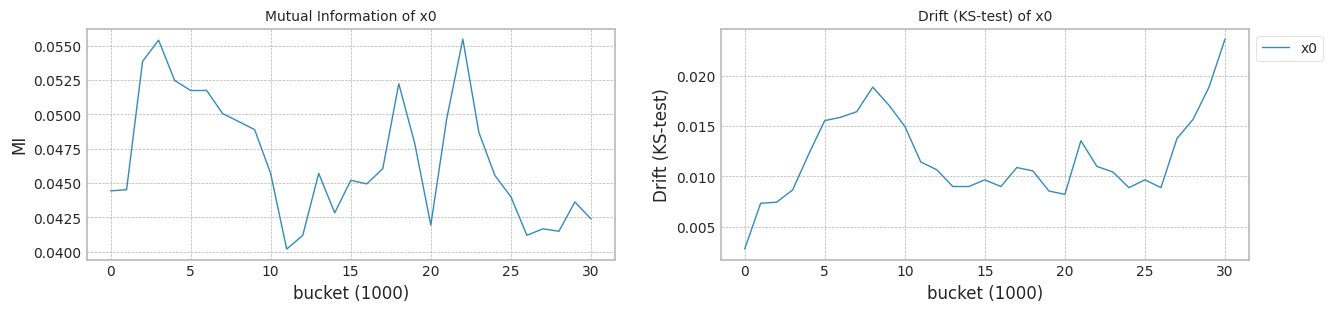

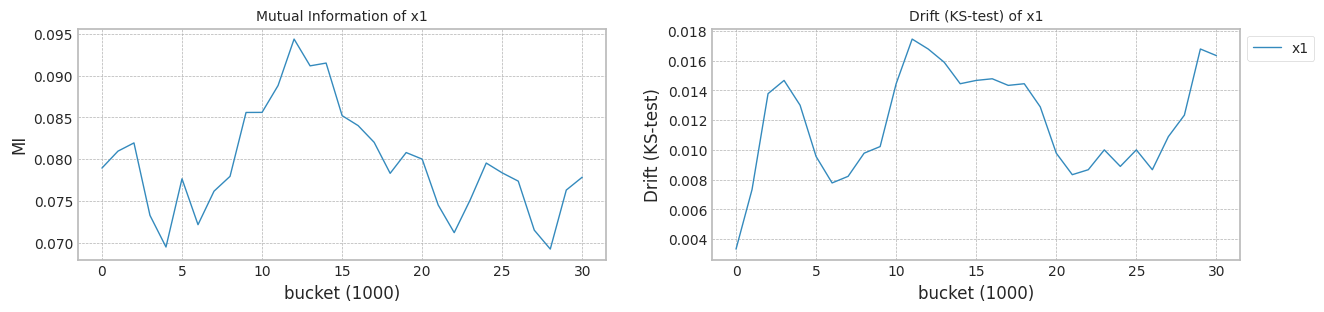

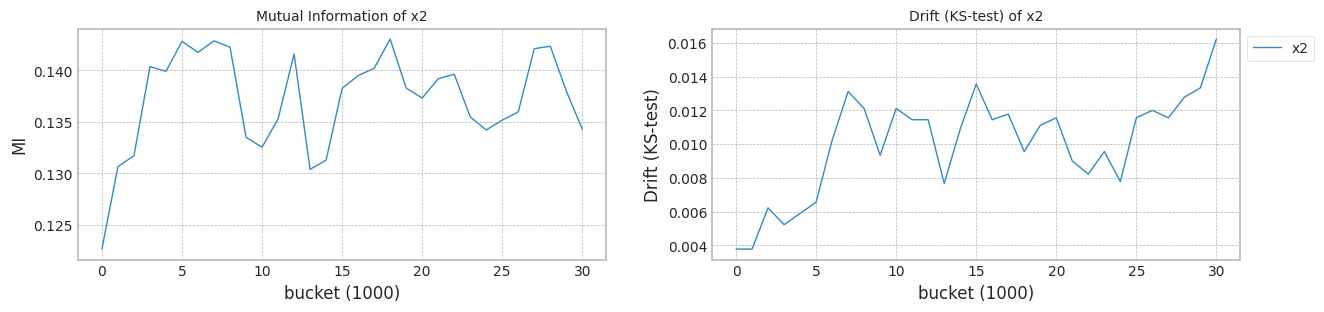

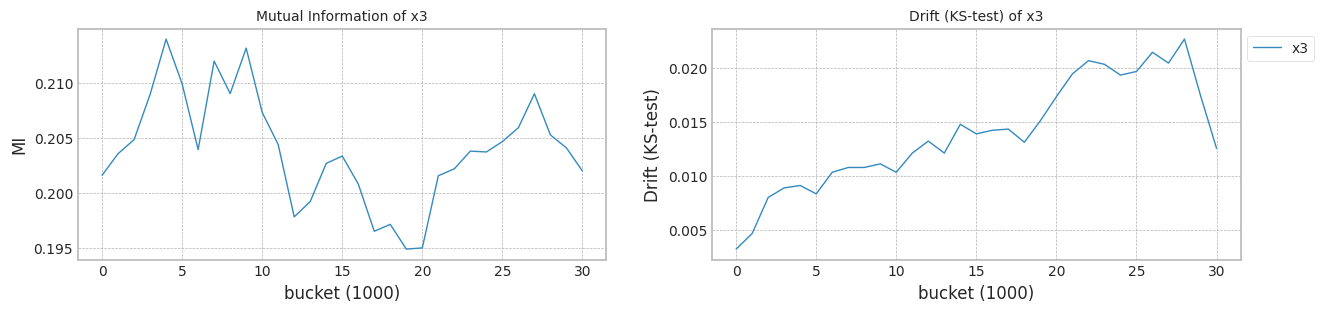

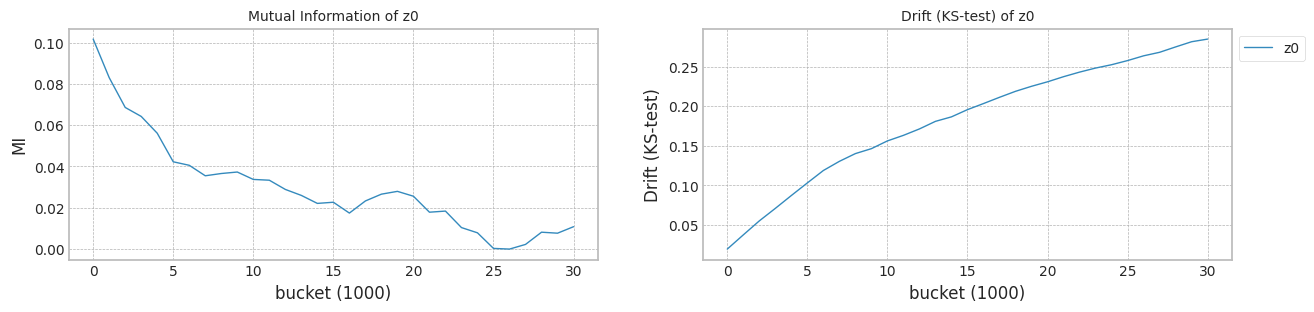

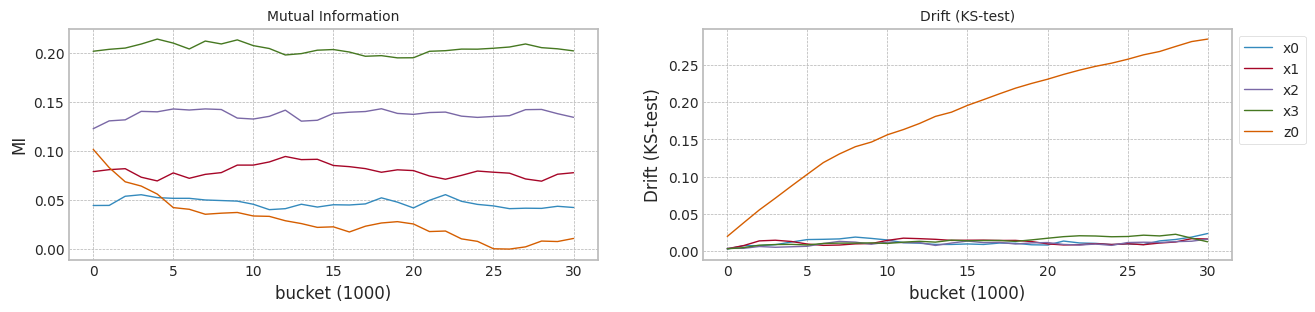

In [ ]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

cuda:0


100%|██████████| 300/300 [00:05<00:00, 56.18it/s] 


<Axes: >

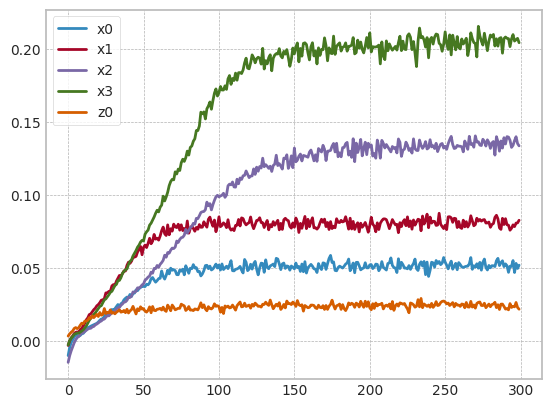

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
loss_mse = customLoss(mine).to(device)
optimizer = torch.optim.Adam(loss_mse.parameters(), lr=0.01)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.sum().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())

plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

df_loss.plot()

In [ ]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.421766   0
1      0.447230  0.556479  0.629077  0.735705  0.529014   0
2      0.489501  0.704159  0.760582  0.582973  0.570549   0
3      0.581446  0.301839  0.443337  0.515173  0.396001   0
4      0.571642  0.639275  0.524701  0.583380  0.561748   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.185740  39
39996  0.426322  0.302644  0.484909  0.587518  0.721101  39
39997  0.374186  0.587769  0.624447  0.598315  0.489479  39
39998  0.470439  0.265430  0.218971  0.645349  1.258888  39
39999  0.654583  0.419378  0.800216  0.614031  1.055564  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 626.58it/s]


Test f1 score: 0.8763676148796499
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7999359745907817
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 642.84it/s]


Test f1 score: 0.8772618269021147
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.800661275227437
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 584.39it/s]


Test f1 score: 0.8762029746281714
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8007383436761054
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 538.17it/s]


Test f1 score: 0.8757306776358519
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.806905733814354
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 642.57it/s]


Test f1 score: 0.8621571362157135
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7818760607390255
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 629.20it/s]


Test f1 score: 0.8758425744727116
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.801642865166661
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 620.56it/s]


Test f1 score: 0.8756815703380588
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.27it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8015910110037209
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 615.87it/s]


Test f1 score: 0.8567980691874497
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8096525262746533
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 618.95it/s]


Test f1 score: 0.8735656836461126
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8091287530539074
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 635.97it/s]


Test f1 score: 0.8733717702327568
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.15it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8062923965011095
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 636.95it/s]


Test f1 score: 0.8745089480576168
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7991706505744219
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 611.83it/s]


Test f1 score: 0.8759460348798948
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8003778919399798
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.40it/s]


Test f1 score: 0.8757999783056731
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8053832835778604
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 634.47it/s]


Test f1 score: 0.8757037678648766
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8092800192579723
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 627.06it/s]


Test f1 score: 0.8773112899717207
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8008226927555516
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 637.23it/s]


Test f1 score: 0.877269268398739
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8019538797677738
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 645.60it/s]


Test f1 score: 0.8390365130950105
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7959797235266477
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 638.52it/s]


Test f1 score: 0.8752946218127278
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8039833634783969
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 628.99it/s]


Test f1 score: 0.8756284153005466
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8001546109647103
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 637.23it/s]


Test f1 score: 0.8763847756937589
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.15it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7988459711573709
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.98it/s]


Test f1 score: 0.8736643620364551
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.14it/s]


mean of drift:
x0    0.079627
x1    0.097771
x2    0.111828
x3    0.199559
z0    0.182047
dtype: float64
Mean F1 for all data: 0.842856795341919
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.91it/s]


Test f1 score: 0.8699453551912569
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.053681
x1    0.191466
x2    0.120154
x3    0.161423
z0    0.159330
dtype: float64
Mean F1 for all data: 0.8334902801743301
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.28it/s]


Test f1 score: 0.8800795053003534
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


mean of drift:
x0    0.120631
x1    0.190122
x2    0.093832
x3    0.101577
z0    0.162043
dtype: float64
Mean F1 for all data: 0.8445028443498537
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.17it/s]


Test f1 score: 0.8798505001648894
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.067025
x1    0.122183
x2    0.096842
x3    0.107713
z0    0.213781
dtype: float64
Mean F1 for all data: 0.8396691766162451
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.70it/s]


Test f1 score: 0.857670578009561
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.099154
x1    0.223133
x2    0.149581
x3    0.209387
z0    0.228620
dtype: float64
Mean F1 for all data: 0.8189790869290166
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.48it/s]


Test f1 score: 0.8780113885238721
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.139161
x1    0.118968
x2    0.097814
x3    0.148581
z0    0.188541
dtype: float64
Mean F1 for all data: 0.8475747141689548
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.98it/s]


Test f1 score: 0.8788676761026991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.089717
x1    0.112308
x2    0.135527
x3    0.151724
z0    0.224563
dtype: float64
Mean F1 for all data: 0.8354312470685018
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.99it/s]


Test f1 score: 0.8661018813950929
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.510839
x1    0.093437
x2    0.130720
x3    0.168262
z0    0.260986
dtype: float64
Mean F1 for all data: 0.8303673633434008
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.95it/s]


Test f1 score: 0.8625301468976102
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.252147
x1    0.120609
x2    0.154154
x3    0.182824
z0    0.358724
dtype: float64
Mean F1 for all data: 0.8104949327681312
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.59it/s]


Test f1 score: 0.8784287908711872
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.083161
x1    0.107337
x2    0.115233
x3    0.144204
z0    0.222989
dtype: float64
Mean F1 for all data: 0.8415543650737725
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.01it/s]


Test f1 score: 0.8780434782608696
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.106129
x1    0.116194
x2    0.153269
x3    0.185301
z0    0.252577
dtype: float64
Mean F1 for all data: 0.8465500343415654
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.32it/s]


Test f1 score: 0.8677749642188705
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.392975
x1    0.099724
x2    0.123301
x3    0.169950
z0    0.388996
dtype: float64
Mean F1 for all data: 0.8064613159616626
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.01it/s]


Test f1 score: 0.8586180380094475
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.187993
x1    0.267258
x2    0.102699
x3    0.173473
z0    0.179832
dtype: float64
Mean F1 for all data: 0.8063079049451516
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.98it/s]


Test f1 score: 0.878043430576881
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.131376
x1    0.112577
x2    0.128993
x3    0.226301
z0    0.267140
dtype: float64
Mean F1 for all data: 0.8276580954679018
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.75it/s]


Test f1 score: 0.8792650918635171
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.101265
x1    0.100928
x2    0.095269
x3    0.159308
z0    0.565781
dtype: float64
Mean F1 for all data: 0.733717752755178
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.18it/s]


Test f1 score: 0.8456085072863333
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.049204
x1    0.121642
x2    0.141699
x3    0.216810
z0    0.212240
dtype: float64
Mean F1 for all data: 0.8281557421252613
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.67it/s]


Test f1 score: 0.8783563430807697
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.077000
x1    0.123391
x2    0.120932
x3    0.195022
z0    0.334925
dtype: float64
Mean F1 for all data: 0.8452892994592627
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.51it/s]


Test f1 score: 0.8710490151168118
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.116025
x1    0.163434
x2    0.086452
x3    0.095118
z0    0.364591
dtype: float64
Mean F1 for all data: 0.7730519162087803
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.73it/s]


Test f1 score: 0.8661226290251434
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.076527
x1    0.063419
x2    0.079061
x3    0.124907
z0    0.156366
dtype: float64
Mean F1 for all data: 0.810873011378984
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.63it/s]


Test f1 score: 0.8777072850579741
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.083939
x1    0.136971
x2    0.138645
x3    0.164781
z0    0.400233
dtype: float64
Mean F1 for all data: 0.768112375436874


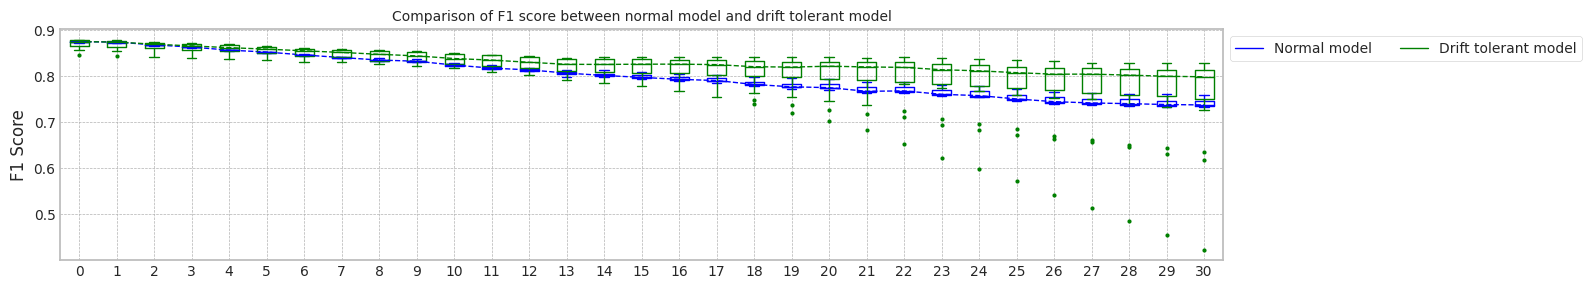

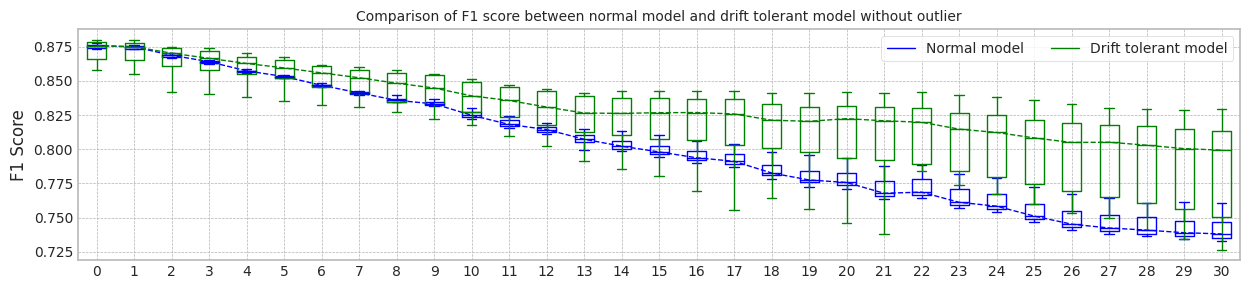

max_mean_trial= 5


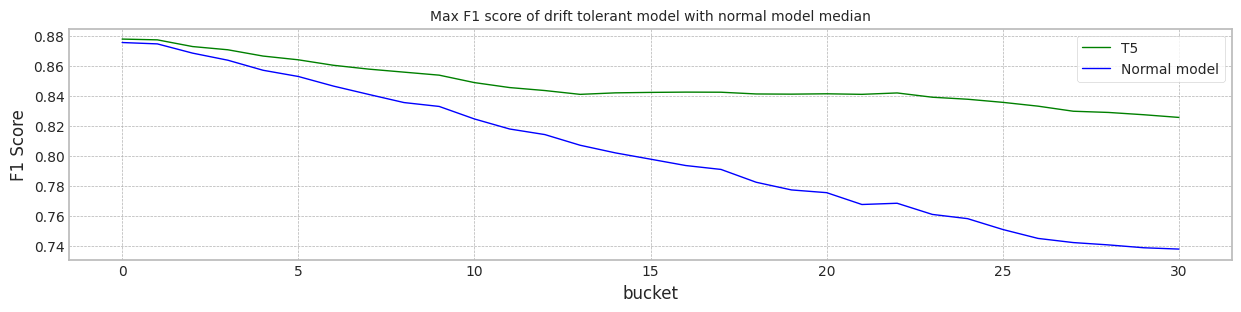

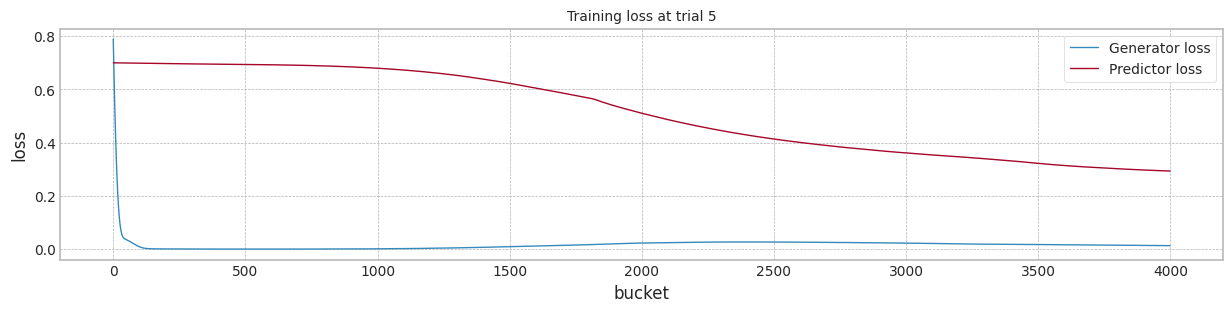

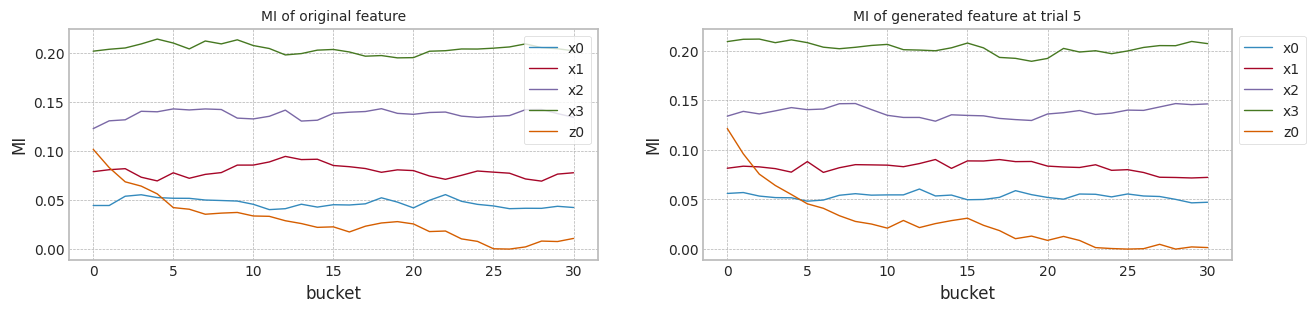

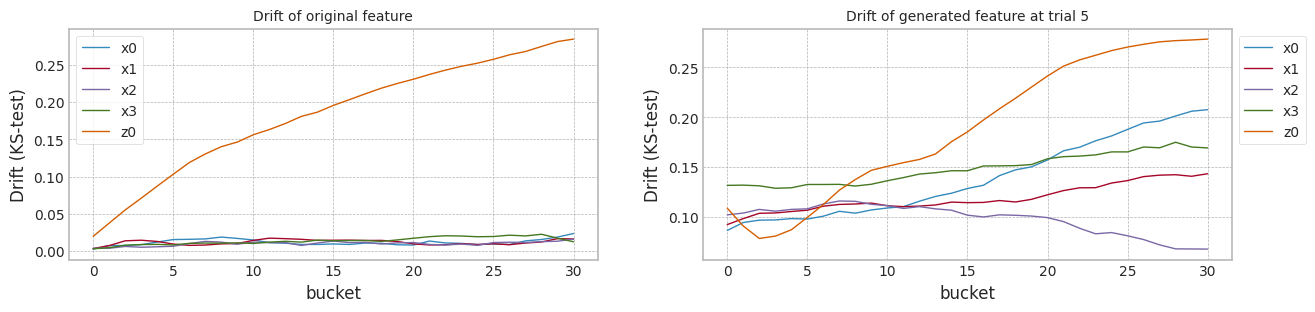

Trial   test_f1   init_f1   mean_f1   last_f1    Sum(MI0.0)    Std(MI0.0)  \
0    0.0  0.876368  0.876368  0.799936  0.733370  7.474560e-01  9.380851e-02   
1    1.0  0.877262  0.877262  0.800661  0.736500  7.474560e-01  9.380851e-02   
2    2.0  0.876203  0.876203  0.800738  0.734494  7.474560e-01  9.380851e-02   
3    3.0  0.875731  0.875731  0.806906  0.746259  7.474560e-01  9.380851e-02   
4    4.0  0.862157  0.862157  0.781876  0.711655  7.474560e-01  9.380851e-02   
5    5.0  0.875843  0.875843  0.801643  0.738571  7.474560e-01  9.380851e-02   
6    6.0  0.875682  0.875682  0.801591  0.738975  7.474560e-01  9.380851e-02   
7    7.0  0.856798  0.856798  0.809653  0.760481  7.474560e-01  9.380851e-02   
8    8.0  0.873566  0.873566  0.809129  0.749626  7.474560e-01  9.380851e-02   
9    9.0  0.873372  0.873372  0.806292  0.748325  7.474560e-01  9.380851e-02   
10  10.0  0.874509  0.874509  0.799171  0.735211  7.474560e-01  9.380851e-02   
11  11.0  0.875946  0.875946  0.800378  0.736199  7.474560e-01  9.380851e-02   
12  12.0  0.875800  0.875800  0.805383  0.743925  7.474560e-01  9.380851e-02   
13  13.0  0.875704  0.875704  0.809280  0.750000  7.474560e-01  9.380851e-02   
14  14.0  0.877311  0.877311  0.800823  0.735224  7.474560e-01  9.380851e-02   
15  15.0  0.877269  0.877269  0.801954  0.737572  7.474560e-01  9.380851e-02   
16  16.0  0.839037  0.839037  0.795980  0.754149  7.474560e-01  9.380851e-02   
17  17.0  0.875295  0.875295  0.803983  0.743540  7.474560e-01  9.380851e-02   
18  18.0  0.875628  0.875628  0.800155  0.735562  7.474560e-01  9.380851e-02   
19  19.0  0.876385  0.876385  0.798846  0.733217  7.474560e-01  9.380851e-02   
20  mean  0.872293  0.872293  0.801719  0.740143  7.474560e-01  9.380851e-02   
21   sem  0.002098  0.002098  0.001351  0.002279  2.547026e-17  3.183783e-18   

    Ent(MI0.0)    Sum(DR0.0)  Std(DR0.0)  ...    Ent(DR8.0)  TrainSum(MI)  \
0     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584127   
1     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584135   
2     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584050   
3     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584034   
4     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584211   
5     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584149   
6     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584116   
7     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.583951   
8     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584359   
9     1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584098   
10    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584175   
11    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584112   
12    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584160   
13    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584136   
14    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584046   
15    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584151   
16    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584104   
17    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.583983   
18    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584195   
19    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584238   
20    1.406225  1.810000e-01    0.028441  ...  1.419276e+00      0.584127   
21    0.000000  6.367566e-18    0.000000  ...  5.094053e-17      0.000020   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.053828      1.505461      0.549369      0.052727      1.496972   
1       0.053817      1.505511      0.549327      0.052712      1.497037   
2       0.053834      1.505399      0.549374      0.052707      1.497073   
3       0.053836      1.505391      0.549325      0.052723      1.496973   
4       0.

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0    0.0  0.873664  0.873664  0.842857  0.808883    0.746918    0.093741   
1    1.0  0.869945  0.869945  0.833490  0.807469    0.747778    0.093754   
2    2.0  0.880080  0.880080  0.844503  0.825246    0.746000    0.093754   
3    3.0  0.879851  0.879851  0.839669  0.804764    0.745207    0.093734   
4    4.0  0.857671  0.857671  0.818979  0.793075    0.746356    0.093649   
5    5.0  0.878011  0.878011  0.847575  0.825806    0.745744    0.093814   
6    6.0  0.878868  0.878868  0.835431  0.796085    0.747979    0.093886   
7    7.0  0.866102  0.866102  0.830367  0.802485    0.743682    0.094299   
8    8.0  0.862530  0.862530  0.810495  0.749817    0.748042    0.093712   
9    9.0  0.878429  0.878429  0.841554  0.811286    0.746889    0.093730   
10  10.0  0.878043  0.878043  0.846550  0.829187    0.747312    0.093434   
11  11.0  0.867775  0.867775  0.806461  0.726583    0.746962    0.093392   
12  12.0  0.858618  0.858618  0.806308  0.759416    0.746385    0.093743   
13  13.0  0.878043  0.878043  0.827658  0.765844    0.746658    0.093706   
14  14.0  0.879265  0.879265  0.733718  0.423413    0.746542    0.093718   
15  15.0  0.845609  0.845609  0.828156  0.819704    0.745890    0.093586   
16  16.0  0.878356  0.878356  0.845289  0.821067    0.745228    0.093369   
17  17.0  0.871049  0.871049  0.773052  0.617335    0.747206    0.093630   
18  18.0  0.866123  0.866123  0.810873  0.750768    0.745085    0.092834   
19  19.0  0.877707  0.877707  0.768112  0.635704    0.746114    0.093961   
20  mean  0.871287  0.871287  0.819555  0.758697    0.746399    0.093672   
21   sem  0.002119  0.002119  0.006808  0.022037    0.000242    0.000063   

    Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  TrainSum(MI)  \
0     1.406111    0.660444    0.042583  ...    1.556556      0.620524   
1     1.406636    0.684444    0.064163  ...    1.553034      0.609991   
2     1.405436    0.582556    0.050149  ...    1.585368      0.623751   
3     1.405446    0.542111    0.045206  ...    1.566930      0.643830   
4     1.406382    0.927444    0.050141  ...    1.557500      0.619006   
5     1.404755    0.627000    0.043291  ...    1.584963      0.620450   
6     1.406064    0.683000    0.040462  ...    1.583874      0.607826   
7     1.400642    0.938444    0.084605  ...    1.418154      0.619673   
8     1.406923    0.957111    0.046772  ...    1.569167      0.615926   
9     1.406292    0.634556    0.042060  ...    1.593582      0.610302   
10    1.407706    0.788333    0.045663  ...    1.582350      0.605860   
11    1.407499    0.958333    0.092844  ...    1.455823      0.627523   
12    1.405949    0.744889    0.052145  ...    1.536031      0.621345   
13    1.406317    0.709111    0.056404  ...    1.564173      0.617502   
14    1.406356    0.609889    0.052560  ...    1.579178      0.621862   
15    1.406439    0.635444    0.058558  ...    1.516487      0.600515   
16    1.406786    0.722444    0.043666  ...    1.580328      0.621293   
17    1.407005    0.432222    0.033731  ...    1.571477      0.617871   
18    1.409152    0.496000    0.037610  ...    1.281797      0.614548   
19    1.404600    0.671556    0.035954  ...    1.577333      0.613377   
20    1.406125    0.700267    0.050928  ...    1.540705      0.617649   
21    0.000367    0.033587    0.003365  ...    0.016881      0.002026   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.051642      1.521145      0.594277      0.051768      1.516084   
1       0.050856      1.520291      0.579361      0.050139      1.515917   
2       0.055329      1.508092      0.593604      0.055157      1.498558   
3       0.053887      1.520686      0.595873      0.053716      1.510162   
4       0.051981      1.521475      0.600368      0.052798      1.515279   
5       0.056771      1.502728      0.602000      0.052350      1.516344   
6       0.054699      1.505595      0.5947

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [ ]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [ ]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [ ]:
x1.shape

(40000, 5)

In [ ]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [ ]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.54it/s]


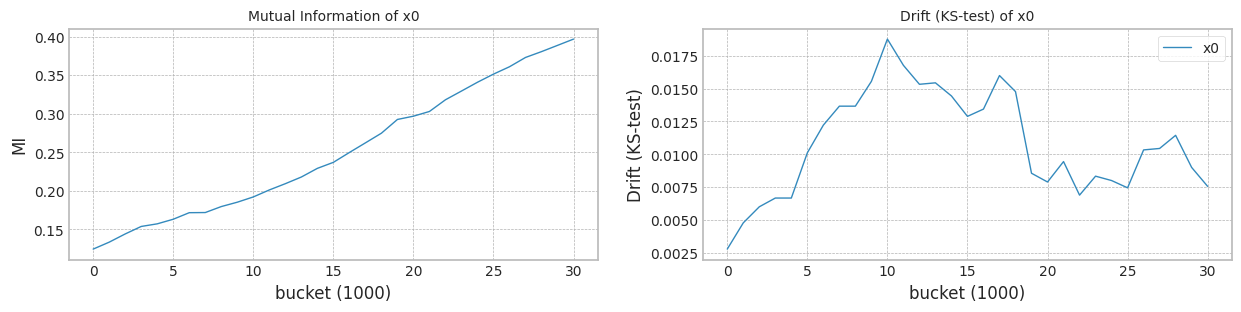

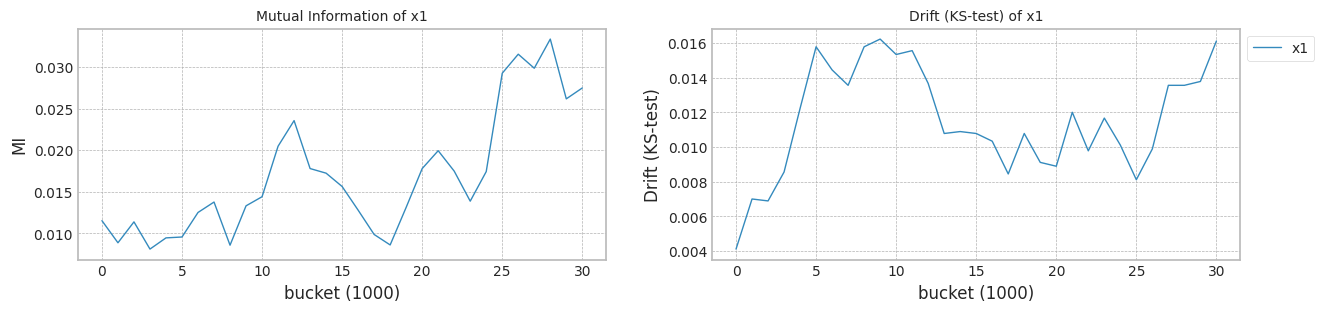

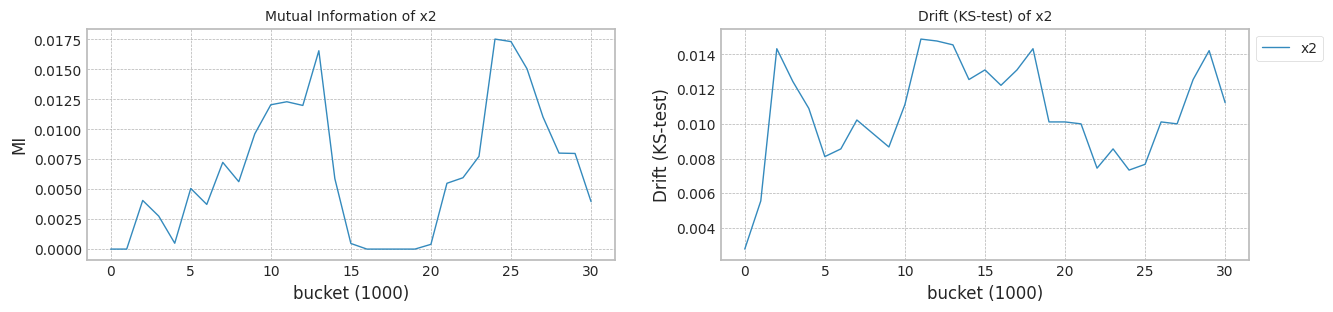

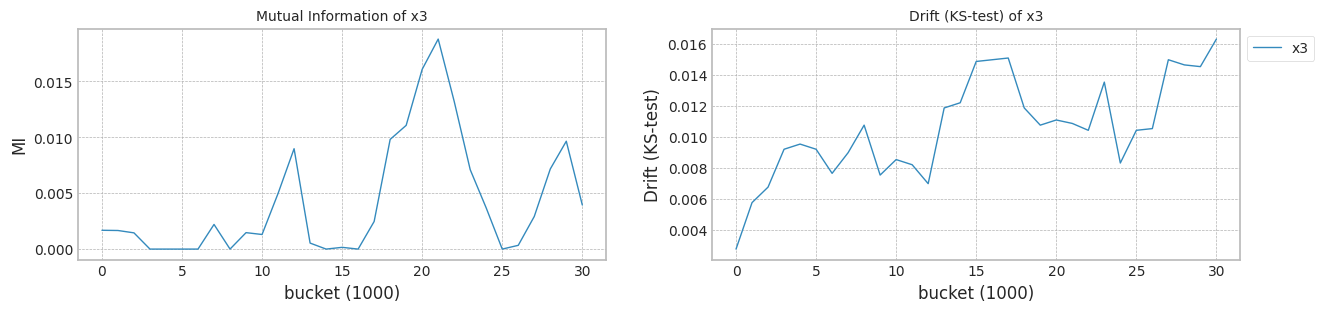

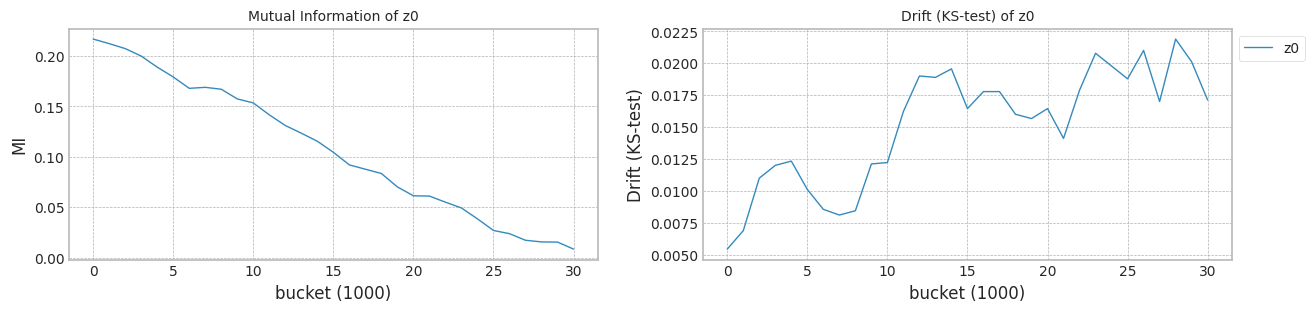

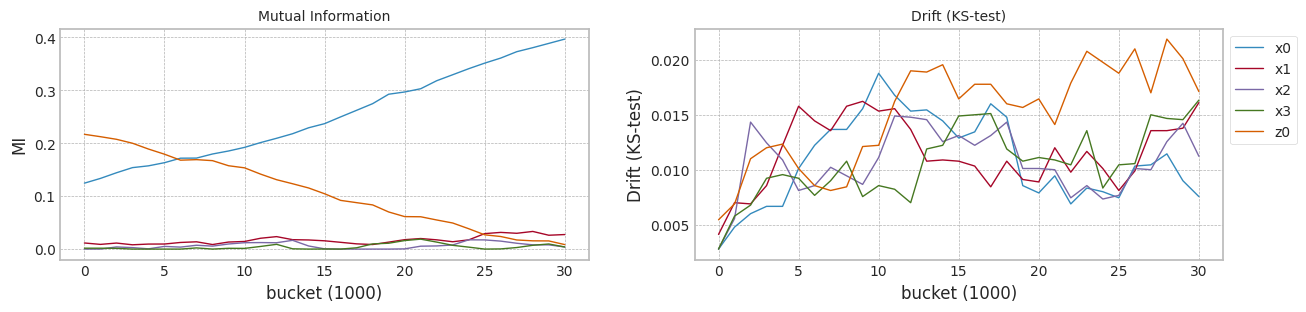

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [ ]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.366139   0
1      0.610533  0.420412  0.508390  0.580336  0.662926   0
2      0.556874  0.464734  0.669603  0.724770  0.486574   0
3      0.344341  0.646524  0.340976  0.528780  0.611850   0
4      0.503142  0.550860  0.598773  0.465698  0.487044   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.709407  39
39996  0.358451  0.483875  0.341855  0.574439  0.695384  39
39997  0.559469  0.343824  0.542547  0.575250  0.504288  39
39998  0.433692  0.530132  0.301231  0.282353  0.762158  39
39999  0.538629  0.637825  0.358726  0.768301  0.522435  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 644.99it/s]


Test f1 score: 0.9662005741272339
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8790432735532113
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 649.80it/s]


Test f1 score: 0.9595227168425885
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8842256347709188
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 647.81it/s]


Test f1 score: 0.9560632688927944
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8774370002562047
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 644.34it/s]


Test f1 score: 0.9285649450848688
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.864135146629946
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.92it/s]


Test f1 score: 0.9620327675855981
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8865100309642203
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 654.05it/s]


Test f1 score: 0.8459433354797167
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7919962728785239
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 649.00it/s]


Test f1 score: 0.9502934702861335
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8690084535422655
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 646.74it/s]


Test f1 score: 0.8508422166164863
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7947007785443254
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 666.45it/s]


Test f1 score: 0.8850332687610544
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.832844666612642
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 669.66it/s]


Test f1 score: 0.9347687254812517
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8669397014113295
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 673.12it/s]


Test f1 score: 0.962853172765169
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.27it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8800501888999925
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 657.21it/s]


Test f1 score: 0.9334433443344335
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8679410725763725
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 648.14it/s]


Test f1 score: 0.9504767194297881
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8721441635611851
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 658.80it/s]


Test f1 score: 0.9097301573349741
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8561650930023338
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 656.38it/s]


Test f1 score: 0.9239849758540511
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8675180560793038
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 648.91it/s]


Test f1 score: 0.9558823529411765
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.9043488899543575
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.85it/s]


Test f1 score: 0.9537079475662297
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8935968602795235
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.91it/s]


Test f1 score: 0.9513996535059724
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8796072640576021
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 662.28it/s]


Test f1 score: 0.9474548440065682
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8722653557538995
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 654.75it/s]


Test f1 score: 0.9624548067117827
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8914841678000077
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.13it/s]


Test f1 score: 0.9303402814893995
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


mean of drift:
x0    0.224570
x1    0.075004
x2    0.040054
x3    0.218953
z0    0.234018
dtype: float64
Mean F1 for all data: 0.9069874416096345
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.25it/s]


Test f1 score: 0.9499722067815453
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.251993
x1    0.077971
x2    0.031803
x3    0.154262
z0    0.299229
dtype: float64
Mean F1 for all data: 0.8704683923406628
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.49it/s]


Test f1 score: 0.9597233903373517
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.275201
x1    0.327663
x2    0.049749
x3    0.119892
z0    0.217505
dtype: float64
Mean F1 for all data: 0.8994679763710007
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.85it/s]


Test f1 score: 0.9526643727331908
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.260308
x1    0.115746
x2    0.034538
x3    0.284871
z0    0.167953
dtype: float64
Mean F1 for all data: 0.9099005613001258
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.91it/s]


Test f1 score: 0.9414786277747204
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.27it/s]


mean of drift:
x0    0.274602
x1    0.079918
x2    0.014771
x3    0.130681
z0    0.247584
dtype: float64
Mean F1 for all data: 0.8776531694222508
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.98it/s]


Test f1 score: 0.9401251117068812
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.219301
x1    0.114233
x2    0.077233
x3    0.025369
z0    0.129616
dtype: float64
Mean F1 for all data: 0.8931423802098514
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.27it/s]


Test f1 score: 0.9397568333485693
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.276244
x1    0.145057
x2    0.044882
x3    0.063384
z0    0.235194
dtype: float64
Mean F1 for all data: 0.8816274618952131
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.27it/s]


Test f1 score: 0.9500465983224604
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.244939
x1    0.093262
x2    0.024470
x3    0.265151
z0    0.198957
dtype: float64
Mean F1 for all data: 0.8987327627688986
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.60it/s]


Test f1 score: 0.9603598538093899
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.255781
x1    0.075283
x2    0.044251
x3    0.275749
z0    0.227237
dtype: float64
Mean F1 for all data: 0.878253609122501
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.75it/s]


Test f1 score: 0.9542495815510509
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.258380
x1    0.103369
x2    0.034186
x3    0.137480
z0    0.156875
dtype: float64
Mean F1 for all data: 0.9018307069695791
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.50it/s]


Test f1 score: 0.9424774649196171
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.312573
x1    0.095498
x2    0.036810
x3    0.252219
z0    0.221928
dtype: float64
Mean F1 for all data: 0.8542302213584205
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.88it/s]


Test f1 score: 0.9417609715705216
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.45it/s]


mean of drift:
x0    0.240129
x1    0.084957
x2    0.025136
x3    0.289566
z0    0.160710
dtype: float64
Mean F1 for all data: 0.9152567774723288
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.50it/s]


Test f1 score: 0.9459406713505074
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.236921
x1    0.063649
x2    0.033122
x3    0.255742
z0    0.205068
dtype: float64
Mean F1 for all data: 0.8725964842621297
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.57it/s]


Test f1 score: 0.9033144427271167
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.224477
x1    0.074864
x2    0.030376
x3    0.016158
z0    0.105366
dtype: float64
Mean F1 for all data: 0.8580269414793579
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.29it/s]


Test f1 score: 0.928717265867732
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


mean of drift:
x0    0.226799
x1    0.068100
x2    0.037828
x3    0.259703
z0    0.208269
dtype: float64
Mean F1 for all data: 0.9076054548240527
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.98it/s]


Test f1 score: 0.8984368326642179
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.231703
x1    0.159151
x2    0.037007
x3    0.053670
z0    0.100312
dtype: float64
Mean F1 for all data: 0.8693614980114
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.14it/s]


Test f1 score: 0.9383353304452022
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


mean of drift:
x0    0.261036
x1    0.113692
x2    0.162315
x3    0.169290
z0    0.293928
dtype: float64
Mean F1 for all data: 0.8507985267199613
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.21it/s]


Test f1 score: 0.9582232658252617
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.171419
x1    0.086502
x2    0.046111
x3    0.078649
z0    0.107491
dtype: float64
Mean F1 for all data: 0.9090671328092577
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.99it/s]


Test f1 score: 0.9630740393626991
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.235448
x1    0.078437
x2    0.042151
x3    0.234667
z0    0.254208
dtype: float64
Mean F1 for all data: 0.8815334767738693
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.63it/s]


Test f1 score: 0.9426704014939309
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.48it/s]


mean of drift:
x0    0.220140
x1    0.095341
x2    0.240491
x3    0.381609
z0    0.176996
dtype: float64
Mean F1 for all data: 0.8925342512275161


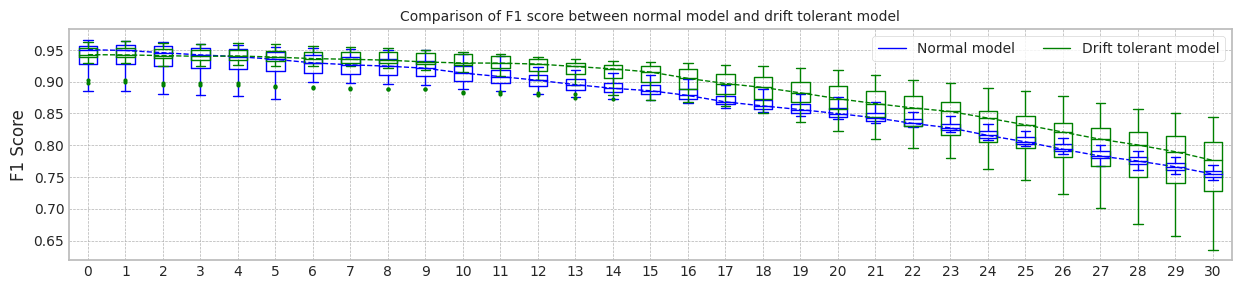

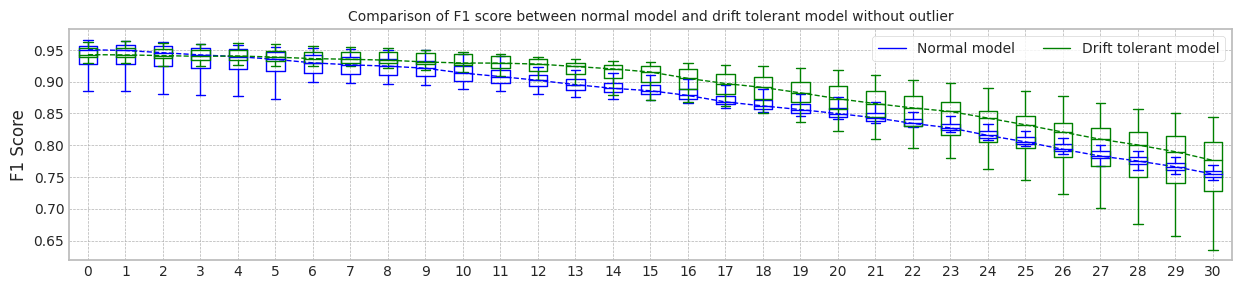

max_mean_trial= 11


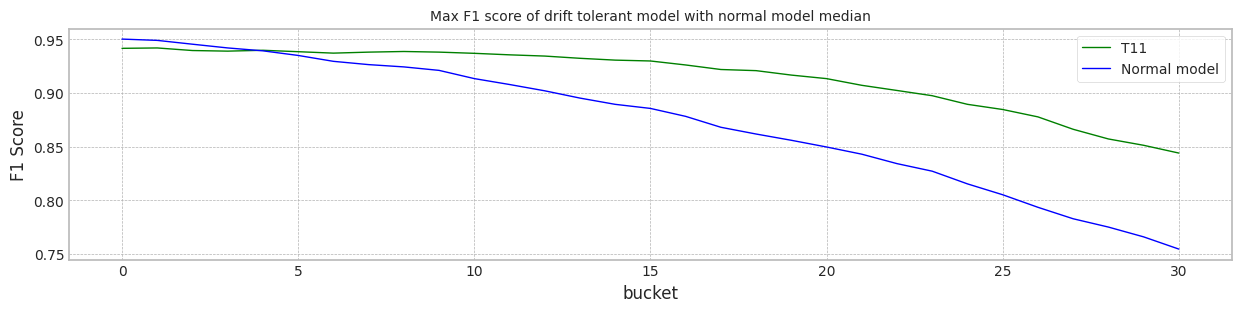

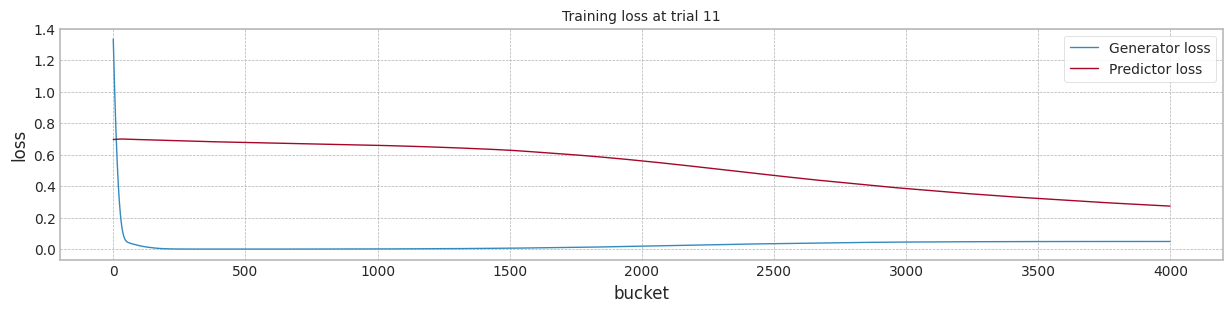

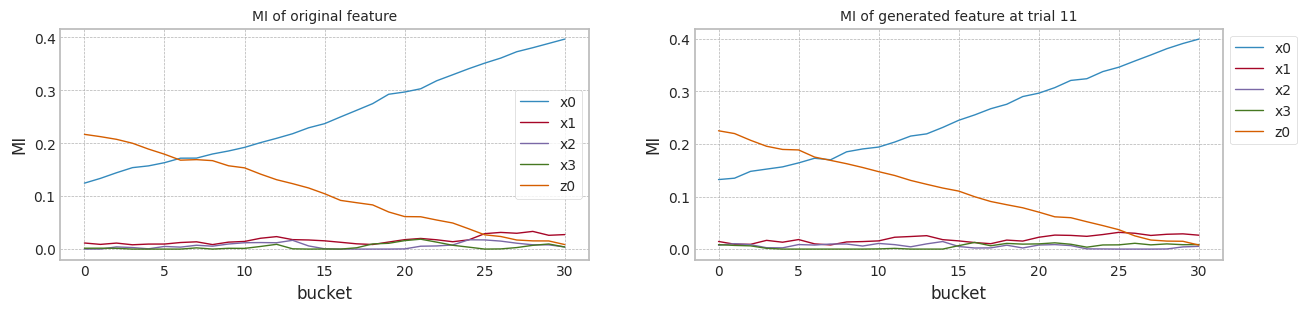

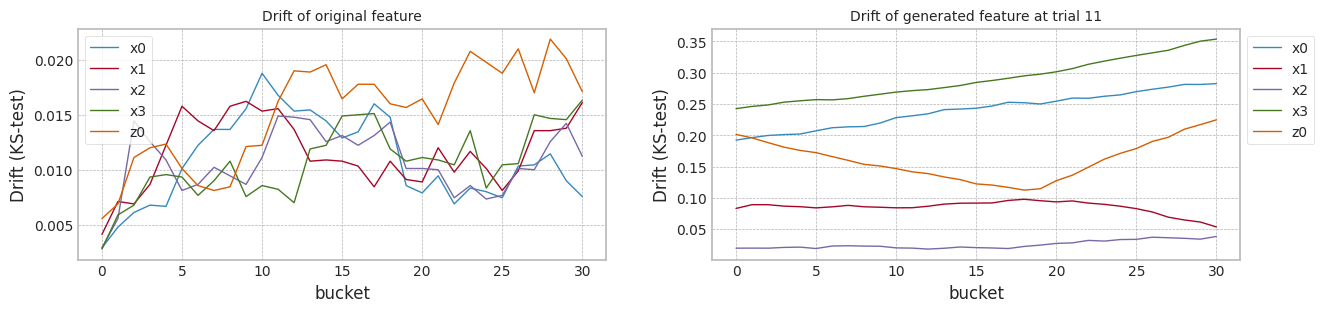

Trial   test_f1   init_f1   mean_f1   last_f1    Sum(MI0.0)    Std(MI0.0)  \
0    0.0  0.966201  0.966201  0.879043  0.750255  3.617977e-01  1.025416e-01   
1    1.0  0.959523  0.959523  0.884226  0.762416  3.617977e-01  1.025416e-01   
2    2.0  0.956063  0.956063  0.877437  0.755728  3.617977e-01  1.025416e-01   
3    3.0  0.928565  0.928565  0.864135  0.754430  3.617977e-01  1.025416e-01   
4    4.0  0.962033  0.962033  0.886510  0.755585  3.617977e-01  1.025416e-01   
5    5.0  0.845943  0.845943  0.791996  0.710109  3.617977e-01  1.025416e-01   
6    6.0  0.950293  0.950293  0.869008  0.746017  3.617977e-01  1.025416e-01   
7    7.0  0.850842  0.850842  0.794701  0.710034  3.617977e-01  1.025416e-01   
8    8.0  0.885033  0.885033  0.832845  0.745819  3.617977e-01  1.025416e-01   
9    9.0  0.934769  0.934769  0.866940  0.754907  3.617977e-01  1.025416e-01   
10  10.0  0.962853  0.962853  0.880050  0.754273  3.617977e-01  1.025416e-01   
11  11.0  0.933443  0.933443  0.867941  0.754343  3.617977e-01  1.025416e-01   
12  12.0  0.950477  0.950477  0.872144  0.749538  3.617977e-01  1.025416e-01   
13  13.0  0.909730  0.909730  0.856165  0.756239  3.617977e-01  1.025416e-01   
14  14.0  0.923985  0.923985  0.867518  0.761360  3.617977e-01  1.025416e-01   
15  15.0  0.955882  0.955882  0.904349  0.792331  3.617977e-01  1.025416e-01   
16  16.0  0.953708  0.953708  0.893597  0.779339  3.617977e-01  1.025416e-01   
17  17.0  0.951400  0.951400  0.879607  0.759713  3.617977e-01  1.025416e-01   
18  18.0  0.947455  0.947455  0.872265  0.753276  3.617977e-01  1.025416e-01   
19  19.0  0.962455  0.962455  0.891484  0.768821  3.617977e-01  1.025416e-01   
20  mean  0.934533  0.934533  0.866598  0.753727  3.617977e-01  1.025416e-01   
21   sem  0.007992  0.007992  0.006522  0.004143  2.547026e-17  3.183783e-18   

      Ent(MI0.0)    Sum(DR0.0)  Std(DR0.0)  ...    Ent(DR8.0)  TrainSum(MI)  \
0   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356049   
1   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356149   
2   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356180   
3   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356215   
4   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356184   
5   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356115   
6   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356160   
7   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356271   
8   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356172   
9   6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356174   
10  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356129   
11  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356229   
12  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356135   
13  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356206   
14  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356207   
15  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356038   
16  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356197   
17  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356186   
18  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356210   
19  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356123   
20  6.540255e-01  9.611111e-02    0.005867  ...  1.585123e+00      0.356166   
21  2.547026e-17  3.183783e-18    0.000000  ...  5.094053e-17      0.000013   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.089014      0.787555      0.354657      0.086642      0.804710   
1       0.089001      0.788705      0.354538      0.086673      0.802887   
2       0.089014      0.788184      0.354639      0.086666      0.803984   
3       0.088993      0.789259      0.35

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0    0.0  0.930340  0.930340  0.906987  0.836507    0.362471    0.102527   
1    1.0  0.949972  0.949972  0.870468  0.726341    0.360490    0.102534   
2    2.0  0.959723  0.959723  0.899468  0.786763    0.361206    0.102444   
3    3.0  0.952664  0.952664  0.909901  0.817066    0.362820    0.102039   
4    4.0  0.941479  0.941479  0.877653  0.738959    0.361365    0.102188   
5    5.0  0.940125  0.940125  0.893142  0.776685    0.361445    0.102540   
6    6.0  0.939757  0.939757  0.881627  0.746200    0.360349    0.102546   
7    7.0  0.950047  0.950047  0.898733  0.790079    0.360623    0.102368   
8    8.0  0.960360  0.960360  0.878254  0.674833    0.361481    0.102227   
9    9.0  0.954250  0.954250  0.901831  0.775665    0.360003    0.102421   
10  10.0  0.942477  0.942477  0.854230  0.635657    0.361688    0.102487   
11  11.0  0.941761  0.941761  0.915257  0.844156    0.362277    0.102059   
12  12.0  0.945941  0.945941  0.872596  0.729259    0.360395    0.102486   
13  13.0  0.903314  0.903314  0.858027  0.772864    0.361763    0.102431   
14  14.0  0.928717  0.928717  0.907605  0.815551    0.361100    0.102509   
15  15.0  0.898437  0.898437  0.869361  0.809288    0.361596    0.102381   
16  16.0  0.938335  0.938335  0.850799  0.673754    0.360104    0.102468   
17  17.0  0.958223  0.958223  0.909067  0.803209    0.362279    0.102286   
18  18.0  0.963074  0.963074  0.881533  0.693534    0.360805    0.102419   
19  19.0  0.942670  0.942670  0.892534  0.787934    0.362108    0.102589   
20  mean  0.942083  0.942083  0.886454  0.761715    0.361318    0.102397   
21   sem  0.003803  0.003803  0.004427  0.012966    0.000185    0.000036   

    Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  TrainSum(MI)  \
0     0.658705    0.643333    0.060879  ...    1.478446      0.367447   
1     0.646231    0.656889    0.062112  ...    1.511443      0.373656   
2     0.653638    0.646444    0.053550  ...    1.505394      0.373437   
3     0.674582    0.778333    0.085620  ...    1.489118      0.374745   
4     0.658865    0.654000    0.069230  ...    1.452730      0.368762   
5     0.647051    0.415556    0.053388  ...    1.450062      0.386753   
6     0.642426    0.573000    0.066234  ...    1.469887      0.383673   
7     0.651049    0.718889    0.066795  ...    1.483756      0.376785   
8     0.660441    0.689000    0.058773  ...    1.507670      0.376386   
9     0.642814    0.620889    0.057472  ...    1.513926      0.378005   
10    0.655613    0.764444    0.074759  ...    1.494184      0.376910   
11    0.671103    0.736667    0.073413  ...    1.463258      0.378059   
12    0.643401    0.694444    0.077355  ...    1.458565      0.388224   
13    0.655975    0.461222    0.064979  ...    1.425573      0.396200   
14    0.648123    0.707556    0.076079  ...    1.450499      0.382906   
15    0.652727    0.486333    0.062734  ...    1.456400      0.380132   
16    0.637296    0.795778    0.045598  ...    1.588021      0.377413   
17    0.663444    0.510667    0.039735  ...    1.531158      0.362709   
18    0.650987    0.590000    0.064890  ...    1.509890      0.375945   
19    0.657366    0.930556    0.075605  ...    1.537947      0.386211   
20    0.653592    0.653700    0.064460  ...    1.488896      0.378218   
21    0.002128    0.027892    0.002514  ...    0.008534      0.001725   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.091975      0.769474      0.365668      0.089826      0.783913   
1       0.088440      0.885616      0.370961      0.087651      0.874708   
2       0.092103      0.805961      0.372761      0.088618      0.869857   
3       0.092678      0.826054      0.371354      0.092251      0.780409   
4       0.090314      0.802081      0.355877      0.089928      0.737369   
5       0.089031      0.918759      0.382564      0.086884      0.930166   
6       0.089140      0.912189      0.3744

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [ ]:
import matplotlib.pyplot as plt

cor = np.asarray([2.5, 1.2, 0.9 , 0.7, 1.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

seed_everything()

y1_array = []
cor_const = cor[0]
for ii in range(x1.shape[0]):
    cor[0] = cor[0] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    e1 = np.random.normal(0.0,  4*ii/40000)
    x1[ii,4] = x1[ii,4] + e1
    y1_array.append(np.sum(cor * x1[ii])+e)

In [ ]:
m = np.mean(y1_array)
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
sum(y1)

5.568336092094251


19898

### 실험

MI Analysis MI Max 0.18765, Min 0.00339, Mean 0.06075, Std 0.07062
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


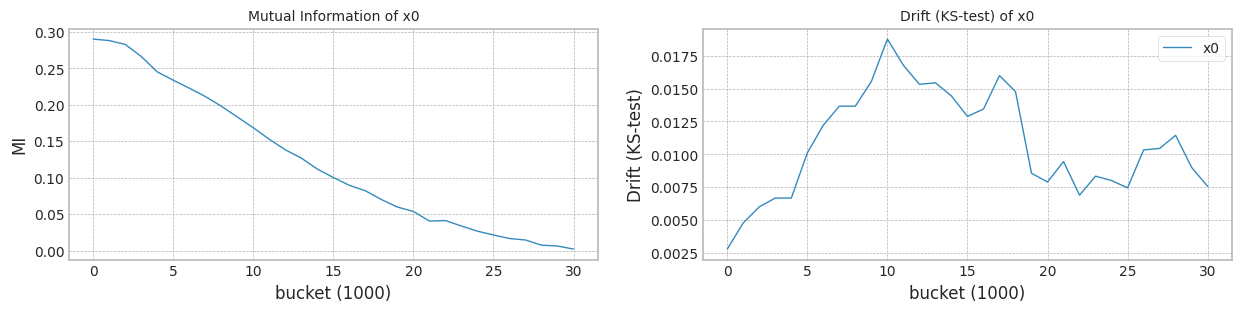

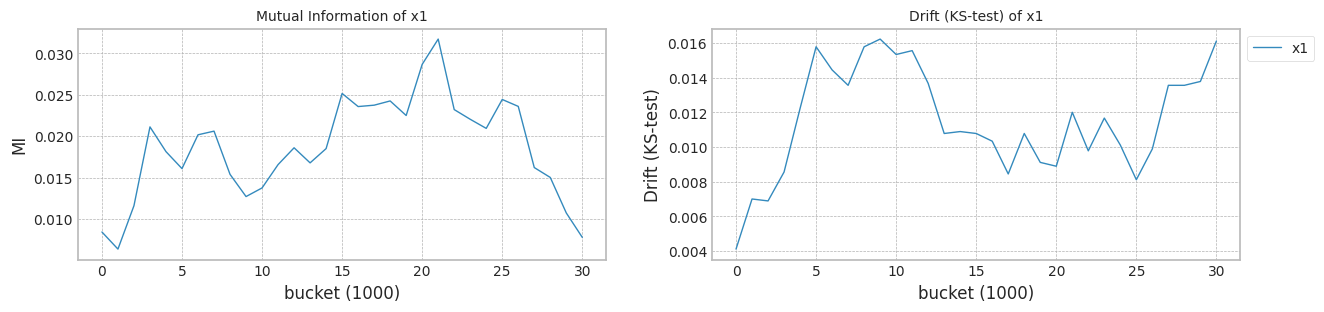

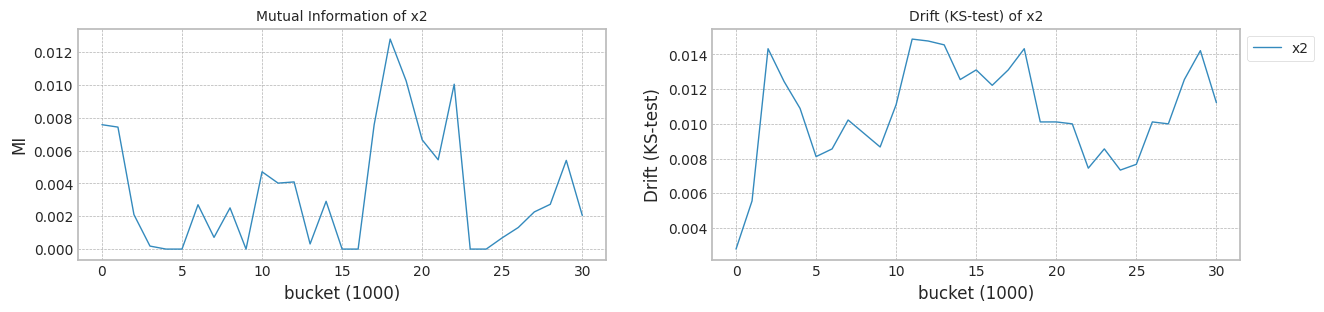

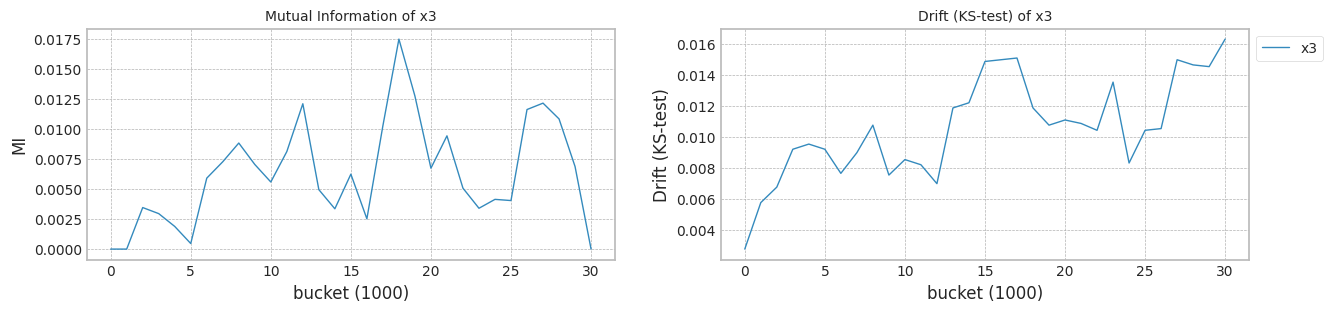

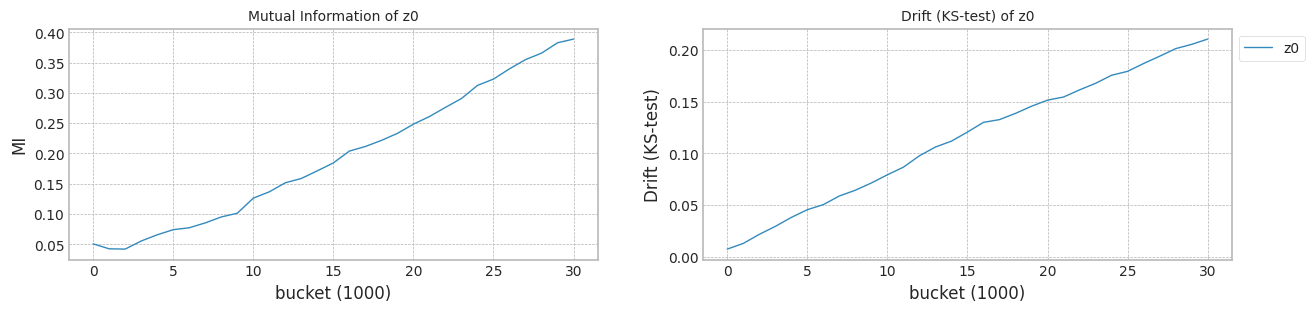

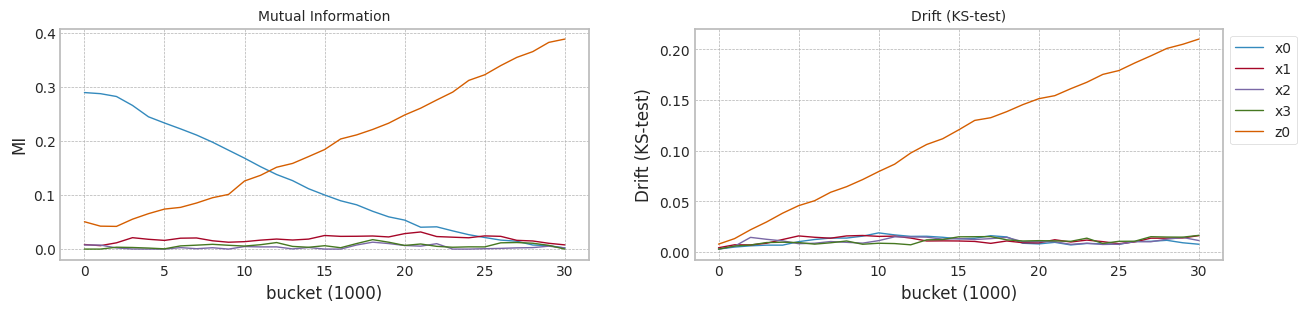

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)

In [ ]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.348766   0
1      0.610533  0.420412  0.508390  0.580336  0.603602   0
2      0.556874  0.464734  0.669603  0.724770  0.452177   0
3      0.344341  0.646524  0.340976  0.528780  0.559737   0
4      0.503142  0.550860  0.598773  0.465698  0.452611   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.612303  39
39996  0.358451  0.483875  0.341855  0.574439  0.395651  39
39997  0.559469  0.343824  0.542547  0.575250  0.268402  39
39998  0.433692  0.530132  0.301231  0.282353  0.347175  39
39999  0.538629  0.637825  0.358726  0.768301  0.890274  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 650.01it/s]


Test f1 score: 0.9058766391452161
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8344416308772443
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 651.33it/s]


Test f1 score: 0.9068093385214008
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8460262178608674
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 659.04it/s]


Test f1 score: 0.9072347109060567
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8438931195488794
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 677.23it/s]


Test f1 score: 0.9014873478848754
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8359575591806093
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 669.01it/s]


Test f1 score: 0.8977989046192001
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8517451773257785
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 665.46it/s]


Test f1 score: 0.8363698280265622
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8026098300746556
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 673.07it/s]


Test f1 score: 0.9039339485186983
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.47it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.838976784972464
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 662.71it/s]


Test f1 score: 0.8435350756533699
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.47it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.7922788555951251
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 646.24it/s]


Test f1 score: 0.8754226730735006
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.51it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8189779411187588
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 647.99it/s]


Test f1 score: 0.8907390084190833
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8342569127441725
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 644.50it/s]


Test f1 score: 0.9099999999999999
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8480587801133691
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 658.41it/s]


Test f1 score: 0.8964441671865252
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8439339519864835
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 655.56it/s]


Test f1 score: 0.8988413981111868
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8296525664405948
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 662.04it/s]


Test f1 score: 0.8989553656220323
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8359125751635887
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 672.15it/s]


Test f1 score: 0.9047619047619048
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8488502297230845
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 651.69it/s]


Test f1 score: 0.9060428849902533
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.47it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8574016936894219
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 675.78it/s]


Test f1 score: 0.8770367732169887
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8167458558417847
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 652.04it/s]


Test f1 score: 0.9051291939838026
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.846640817424142
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 654.37it/s]


Test f1 score: 0.9005275779376498
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.47it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8501104945986857
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 645.43it/s]


Test f1 score: 0.9050651513667091
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8342622359074491
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.97it/s]


Test f1 score: 0.8856900931414056
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


mean of drift:
x0    0.254111
x1    0.084079
x2    0.021355
x3    0.107595
z0    0.221900
dtype: float64
Mean F1 for all data: 0.8314493334357682
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.67it/s]


Test f1 score: 0.9015655577299414
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.325480
x1    0.074477
x2    0.037147
x3    0.038631
z0    0.264254
dtype: float64
Mean F1 for all data: 0.8526717140656642
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.46it/s]


Test f1 score: 0.8985593053088614
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


mean of drift:
x0    0.292613
x1    0.100957
x2    0.042577
x3    0.145097
z0    0.258384
dtype: float64
Mean F1 for all data: 0.8474342246070165
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.48it/s]


Test f1 score: 0.899111549851925
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.286258
x1    0.127996
x2    0.045258
x3    0.027774
z0    0.225627
dtype: float64
Mean F1 for all data: 0.8501181421276622
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.83it/s]


Test f1 score: 0.8888235870310509
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


mean of drift:
x0    0.261330
x1    0.087097
x2    0.019434
x3    0.131939
z0    0.242552
dtype: float64
Mean F1 for all data: 0.8260834128592558
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.80it/s]


Test f1 score: 0.9015855145886106
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.359197
x1    0.096022
x2    0.083832
x3    0.015484
z0    0.212538
dtype: float64
Mean F1 for all data: 0.8487026928888548
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.42it/s]


Test f1 score: 0.8896294844148206
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


mean of drift:
x0    0.199918
x1    0.099323
x2    0.044688
x3    0.087563
z0    0.232767
dtype: float64
Mean F1 for all data: 0.8452305554771482
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.27it/s]


Test f1 score: 0.8930644367929169
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.182674
x1    0.091953
x2    0.025262
x3    0.115079
z0    0.230308
dtype: float64
Mean F1 for all data: 0.84706904744396
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.61it/s]


Test f1 score: 0.8839439167797377
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.160821
x1    0.060276
x2    0.031441
x3    0.012695
z0    0.200749
dtype: float64
Mean F1 for all data: 0.820648654604633
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.85it/s]


Test f1 score: 0.9001968503937008
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.256409
x1    0.114606
x2    0.055566
x3    0.021706
z0    0.237996
dtype: float64
Mean F1 for all data: 0.8542375133187428
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.74it/s]


Test f1 score: 0.8931905276604107
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.48it/s]


mean of drift:
x0    0.254419
x1    0.092588
x2    0.035667
x3    0.110595
z0    0.267269
dtype: float64
Mean F1 for all data: 0.8560715540604632
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.04it/s]


Test f1 score: 0.8984791625518468
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.296086
x1    0.135190
x2    0.090728
x3    0.235548
z0    0.232946
dtype: float64
Mean F1 for all data: 0.8523709650284974
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.65it/s]


Test f1 score: 0.8957528957528959
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


mean of drift:
x0    0.205459
x1    0.074674
x2    0.046946
x3    0.219297
z0    0.237133
dtype: float64
Mean F1 for all data: 0.8513556511138775
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.69it/s]


Test f1 score: 0.9032512315270935
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.236179
x1    0.093237
x2    0.036616
x3    0.013093
z0    0.254789
dtype: float64
Mean F1 for all data: 0.8631150393874744
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.73it/s]


Test f1 score: 0.8937040825816052
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


mean of drift:
x0    0.153473
x1    0.074502
x2    0.033978
x3    0.021394
z0    0.215125
dtype: float64
Mean F1 for all data: 0.8460947031803706
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.55it/s]


Test f1 score: 0.8840921458371124
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.261638
x1    0.099283
x2    0.039075
x3    0.013280
z0    0.220326
dtype: float64
Mean F1 for all data: 0.8432768658316342
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.75it/s]


Test f1 score: 0.898238747553816
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.47it/s]


mean of drift:
x0    0.288308
x1    0.087384
x2    0.033341
x3    0.064079
z0    0.225878
dtype: float64
Mean F1 for all data: 0.8649875109920324
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.98it/s]


Test f1 score: 0.8974095394736842
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.50it/s]


mean of drift:
x0    0.182659
x1    0.076928
x2    0.024194
x3    0.014763
z0    0.180763
dtype: float64
Mean F1 for all data: 0.8480802873148485
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.96it/s]


Test f1 score: 0.8996305418719212
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.200778
x1    0.093158
x2    0.030975
x3    0.023566
z0    0.255190
dtype: float64
Mean F1 for all data: 0.8107415236180957
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.51it/s]


Test f1 score: 0.8925538218447562
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.243599
x1    0.094047
x2    0.031832
x3    0.236986
z0    0.226405
dtype: float64
Mean F1 for all data: 0.8509946340995107


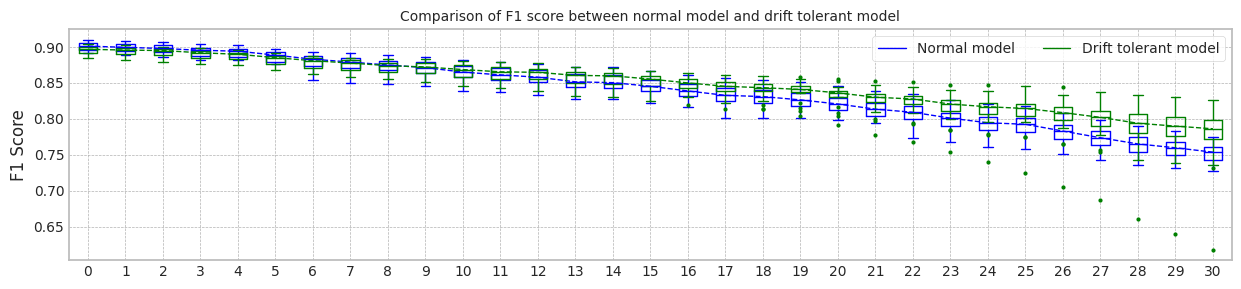

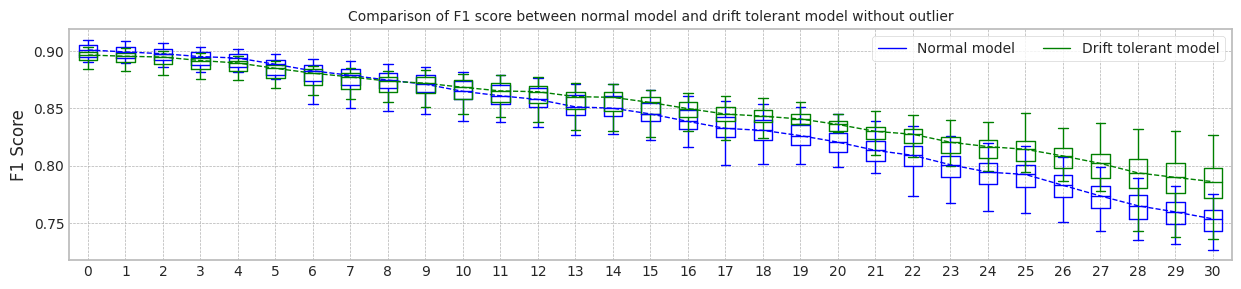

max_mean_trial= 16


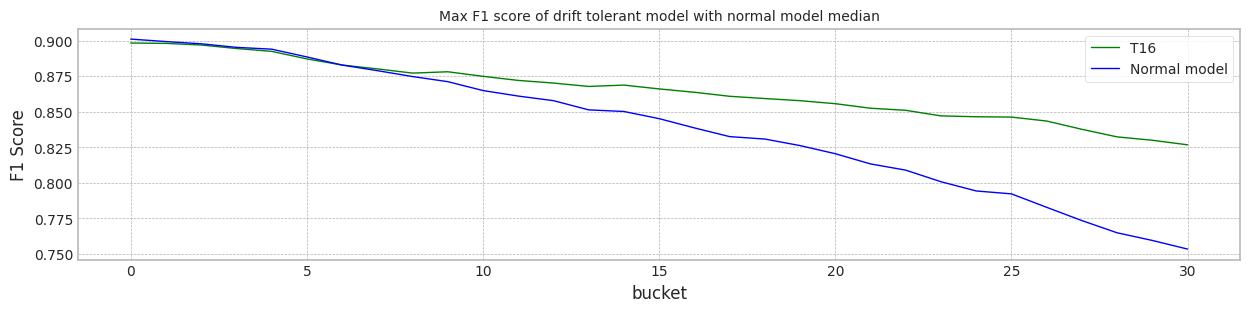

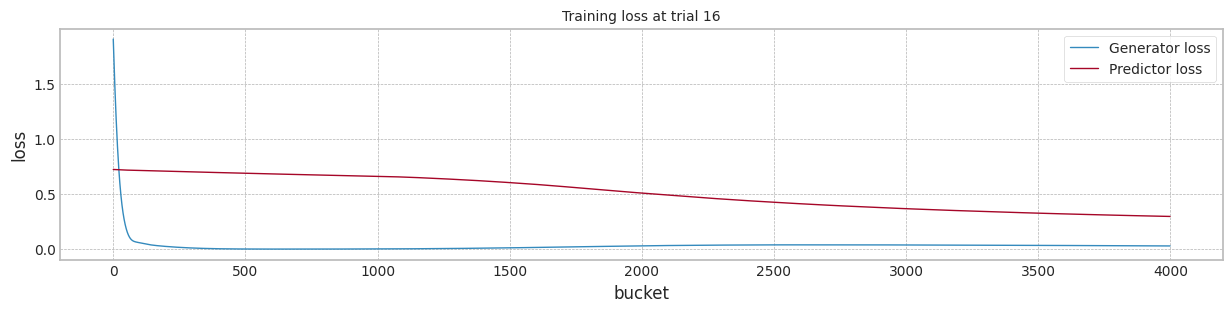

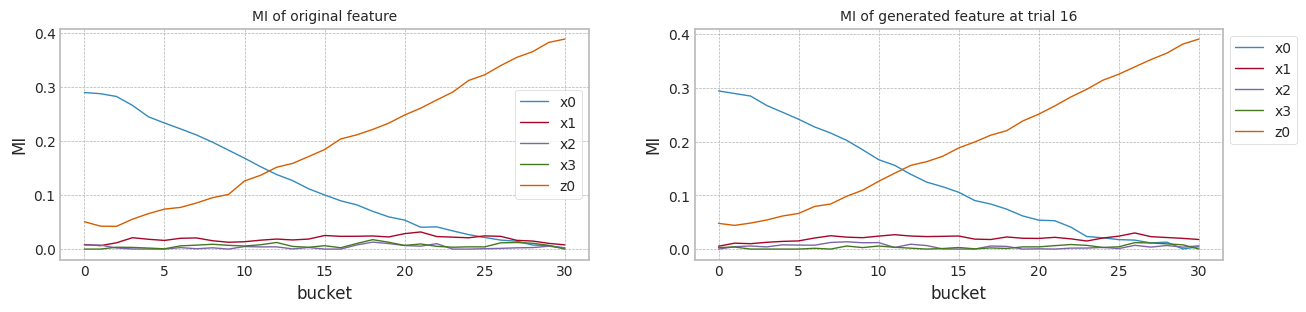

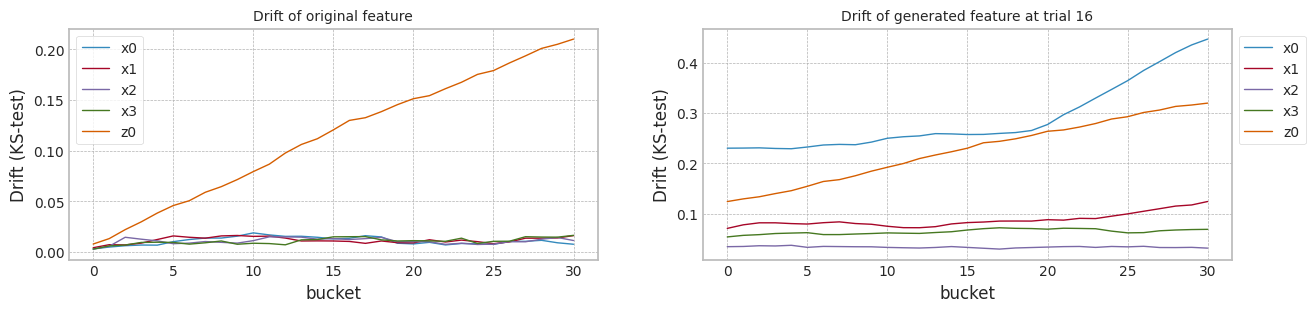

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)    Std(MI0.0)  \
0    0.0  0.905877  0.905877  0.834442  0.739193    0.436327  1.179045e-01   
1    1.0  0.906809  0.906809  0.846026  0.760482    0.436327  1.179045e-01   
2    2.0  0.907235  0.907235  0.843893  0.751779    0.436327  1.179045e-01   
3    3.0  0.901487  0.901487  0.835958  0.747041    0.436327  1.179045e-01   
4    4.0  0.897799  0.897799  0.851745  0.768032    0.436327  1.179045e-01   
5    5.0  0.836370  0.836370  0.802610  0.755229    0.436327  1.179045e-01   
6    6.0  0.903934  0.903934  0.838977  0.749256    0.436327  1.179045e-01   
7    7.0  0.843535  0.843535  0.792279  0.726657    0.436327  1.179045e-01   
8    8.0  0.875423  0.875423  0.818978  0.743795    0.436327  1.179045e-01   
9    9.0  0.890739  0.890739  0.834257  0.756391    0.436327  1.179045e-01   
10  10.0  0.910000  0.910000  0.848059  0.759693    0.436327  1.179045e-01   
11  11.0  0.896444  0.896444  0.843934  0.757431    0.436327  1.179045e-01   
12  12.0  0.898841  0.898841  0.829653  0.736007    0.436327  1.179045e-01   
13  13.0  0.898955  0.898955  0.835913  0.750244    0.436327  1.179045e-01   
14  14.0  0.904762  0.904762  0.848850  0.767450    0.436327  1.179045e-01   
15  15.0  0.906043  0.906043  0.857402  0.775194    0.436327  1.179045e-01   
16  16.0  0.877037  0.877037  0.816746  0.737854    0.436327  1.179045e-01   
17  17.0  0.905129  0.905129  0.846641  0.762846    0.436327  1.179045e-01   
18  18.0  0.900528  0.900528  0.850110  0.773548    0.436327  1.179045e-01   
19  19.0  0.905065  0.905065  0.834262  0.739280    0.436327  1.179045e-01   
20  mean  0.893601  0.893601  0.835537  0.752870    0.436327  1.179045e-01   
21   sem  0.004593  0.004593  0.003733  0.002955    0.000000  9.551349e-18   

      Ent(MI0.0)    Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  TrainSum(MI)  \
0   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363499   
1   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363656   
2   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363383   
3   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363712   
4   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363483   
5   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363561   
6   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363623   
7   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363547   
8   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363571   
9   8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363509   
10  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363523   
11  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363570   
12  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363649   
13  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363407   
14  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363592   
15  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363459   
16  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363611   
17  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363428   
18  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363492   
19  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363632   
20  8.941990e-01  1.084444e-01    0.009458  ...    1.548127      0.363545   
21  2.547026e-17  3.183783e-18    0.000000  ...    0.000000      0.000020   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.115803      0.559881      0.356672      0.110779      0.615557   
1       0.115779      0.562038      0.356743      0.110765      0.616182   
2       0.115753      0.560213      0.356744      0.110771      0.616056   
3       0.115772      0.562373      0.356751      0.110761      0.616467   
4       0.115777      0.560407      0.356742      0.1107

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0    0.0  0.885690  0.885690  0.831449  0.758772    0.435600    0.117603   
1    1.0  0.901566  0.901566  0.852672  0.782442    0.434671    0.117302   
2    2.0  0.898559  0.898559  0.847434  0.776646    0.436198    0.117654   
3    3.0  0.899112  0.899112  0.850118  0.777228    0.433419    0.117662   
4    4.0  0.888824  0.888824  0.826083  0.731559    0.436518    0.117533   
5    5.0  0.901586  0.901586  0.848703  0.750247    0.434639    0.117446   
6    6.0  0.889629  0.889629  0.845231  0.796954    0.434991    0.117238   
7    7.0  0.893064  0.893064  0.847069  0.780758    0.434409    0.117525   
8    8.0  0.883944  0.883944  0.820649  0.736015    0.436754    0.117850   
9    9.0  0.900197  0.900197  0.854238  0.789563    0.434917    0.117472   
10  10.0  0.893191  0.893191  0.856072  0.815630    0.433618    0.117254   
11  11.0  0.898479  0.898479  0.852371  0.792798    0.435823    0.117460   
12  12.0  0.895753  0.895753  0.851356  0.790663    0.435818    0.117155   
13  13.0  0.903251  0.903251  0.863115  0.813491    0.434993    0.117881   
14  14.0  0.893704  0.893704  0.846095  0.789746    0.436262    0.117821   
15  15.0  0.884092  0.884092  0.843277  0.801608    0.435010    0.117322   
16  16.0  0.898239  0.898239  0.864988  0.826737    0.434609    0.117434   
17  17.0  0.897410  0.897410  0.848080  0.776030    0.435401    0.117794   
18  18.0  0.899631  0.899631  0.810742  0.617911    0.435845    0.117868   
19  19.0  0.892554  0.892554  0.850995  0.811187    0.434387    0.117335   
20  mean  0.894924  0.894924  0.845537  0.775799    0.435194    0.117530   
21   sem  0.001329  0.001329  0.003031  0.010045    0.000204    0.000051   

    Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  TrainSum(MI)  \
0     0.895393    0.548000    0.073276  ...    1.433701      0.368485   
1     0.895287    0.472778    0.070536  ...    1.410025      0.357405   
2     0.897161    0.584444    0.060533  ...    1.494906      0.357924   
3     0.887712    0.495556    0.063056  ...    1.430866      0.371659   
4     0.900363    0.607333    0.070948  ...    1.468527      0.380763   
5     0.894379    0.339778    0.060301  ...    1.452716      0.359037   
6     0.897568    0.567778    0.068018  ...    1.434447      0.361402   
7     0.892843    0.611222    0.065301  ...    1.487022      0.374104   
8     0.896034    0.345222    0.043883  ...    1.414791      0.376753   
9     0.893634    0.455000    0.070734  ...    1.406359      0.363765   
10    0.892898    0.585111    0.065706  ...    1.482033      0.378489   
11    0.897178    0.748000    0.110975  ...    1.474533      0.364831   
12    0.900737    0.724778    0.083764  ...    1.473526      0.370862   
13    0.890469    0.437556    0.072963  ...    1.391902      0.348757   
14    0.895179    0.393000    0.070520  ...    1.373337      0.366265   
15    0.896003    0.412333    0.082585  ...    1.315252      0.371728   
16    0.894512    0.506111    0.071920  ...    1.431605      0.367876   
17    0.892303    0.315889    0.043111  ...    1.428640      0.369115   
18    0.893069    0.347667    0.050176  ...    1.384172      0.369965   
19    0.894399    0.770667    0.103000  ...    1.446632      0.356869   
20    0.894856    0.513411    0.070065  ...    1.431750      0.366803   
21    0.000681    0.030756    0.003705  ...    0.009924      0.001822   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.114726      0.640184      0.361124      0.112249      0.603228   
1       0.115841      0.552072      0.352046      0.112590      0.572763   
2       0.115369      0.543223      0.347512      0.111375      0.544450   
3       0.115780      0.598660      0.377446      0.113852      0.673511   
4       0.117359      0.606451      0.374412      0.114590      0.645554   
5       0.113557      0.604423      0.355910      0.110324      0.639162   
6       0.116889      0.555593      0.3531

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [17]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:06<00:00,  5.08it/s]


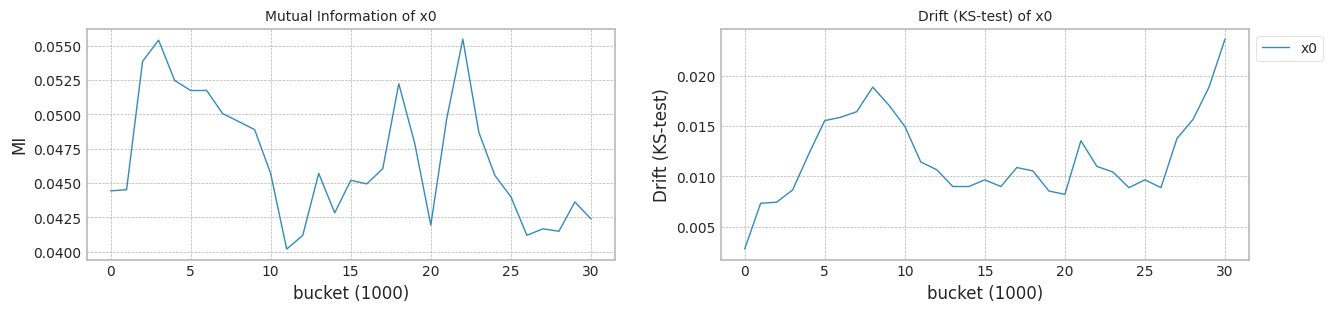

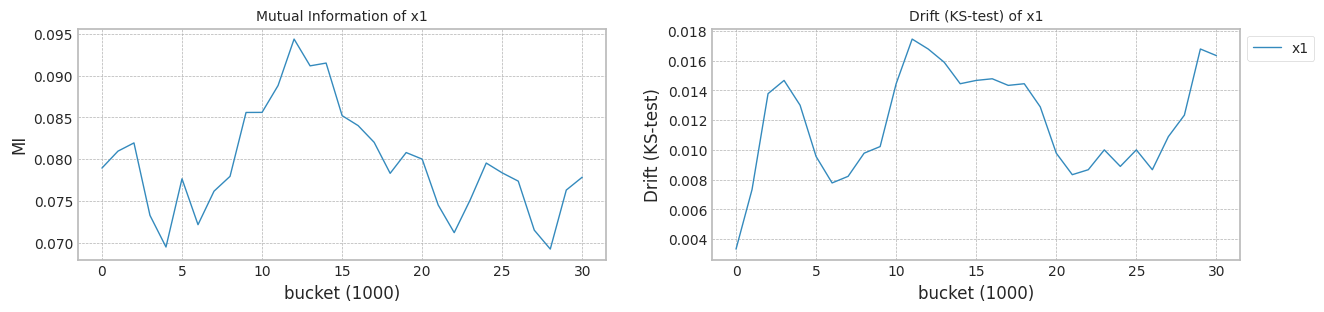

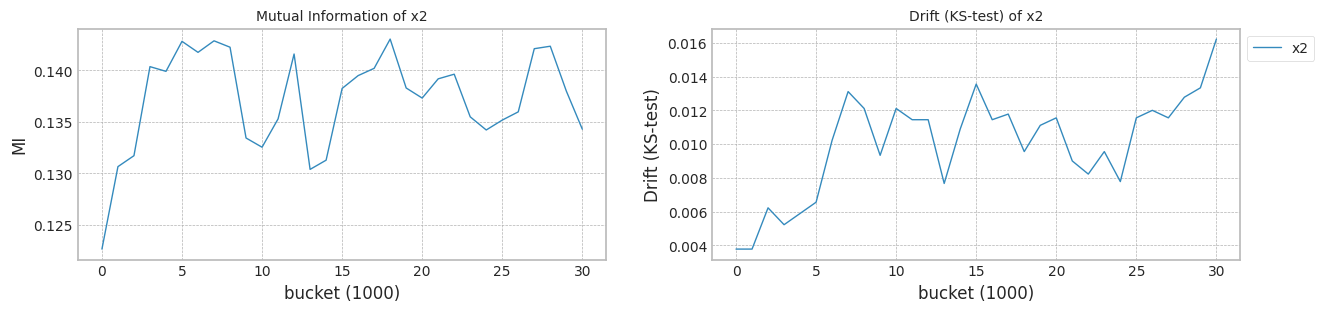

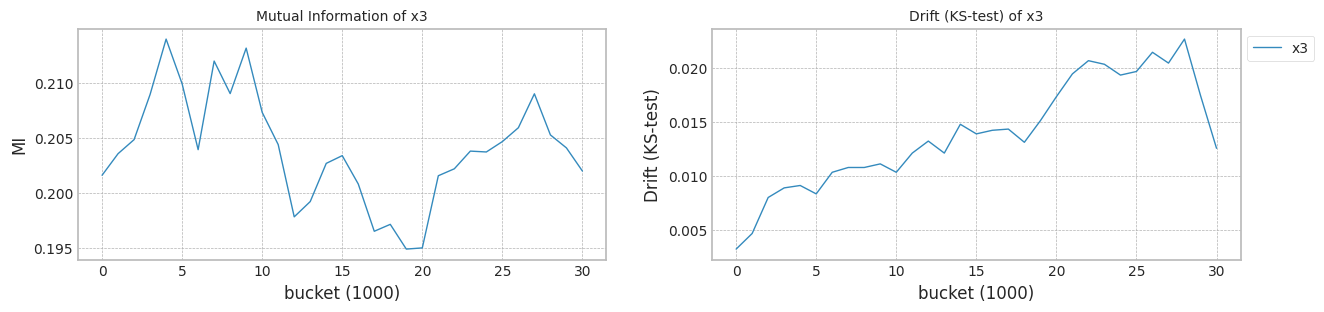

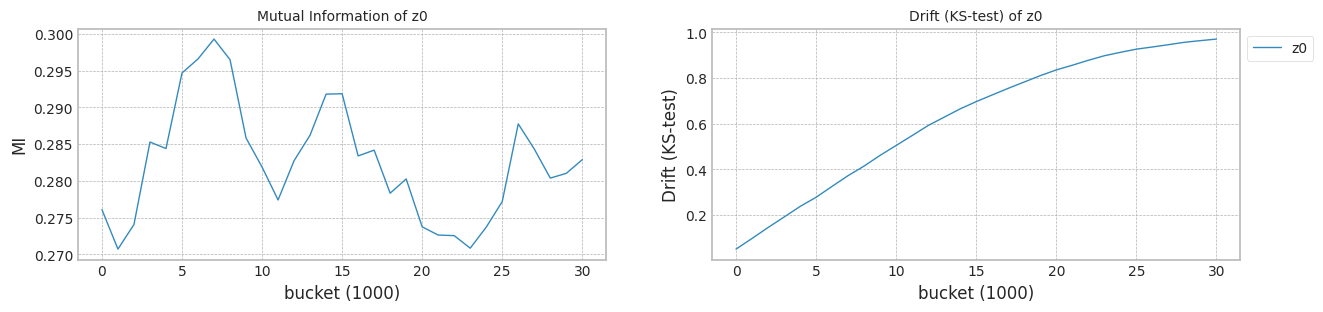

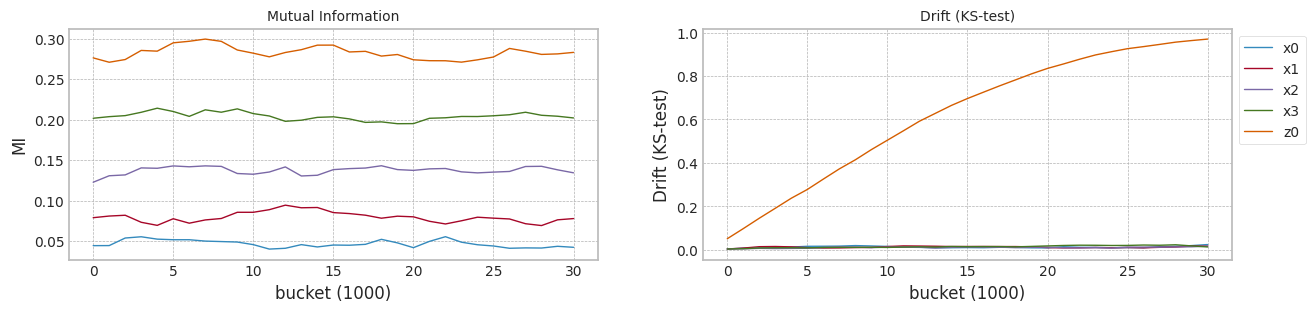

In [18]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [19]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.477486   0
1      0.447230  0.556479  0.629077  0.735705  0.578715   0
2      0.489501  0.704159  0.760582  0.582973  0.354045   0
3      0.581446  0.301839  0.443337  0.515173  0.360338   0
4      0.571642  0.639275  0.524701  0.583380  0.597569   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.989291  39
39996  0.426322  0.302644  0.484909  0.587518  1.004704  39
39997  0.374186  0.587769  0.624447  0.598315  1.321791  39
39998  0.470439  0.265430  0.218971  0.645349  1.148847  39
39999  0.654583  0.419378  0.800216  0.614031  1.319193  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:10<00:00, 382.81it/s]


Test f1 score: 0.9102426454799226
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.760588938342107
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 617.59it/s]


Test f1 score: 0.9063166880068289
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7529543256414415
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 585.07it/s]


Test f1 score: 0.9081720430107527
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.01it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7720924641633319
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 575.98it/s]


Test f1 score: 0.9108444063437633
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.00it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7611594330553391
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 581.50it/s]


Test f1 score: 0.8997727272727273
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.80it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7781789503568595
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 567.00it/s]


Test f1 score: 0.9087221095334685
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.05it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7541787042179633
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 567.69it/s]


Test f1 score: 0.9098316714913691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.97it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7574951639305677
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 570.19it/s]


Test f1 score: 0.8793797825211438
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.727150829891031
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 571.59it/s]


Test f1 score: 0.9065479974570884
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.97it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7575893780314329
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 588.39it/s]


Test f1 score: 0.9049696711716505
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.14it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7580284820886313
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 629.15it/s]


Test f1 score: 0.9101809228134032
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7562396096206008
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 576.42it/s]


Test f1 score: 0.9011389521640091
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7816605690363075
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 579.91it/s]


Test f1 score: 0.9062934074153223
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.09it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7513220014887462
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 564.23it/s]


Test f1 score: 0.9063934251254135
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.92it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7735012356286219
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 592.28it/s]


Test f1 score: 0.848892208115509
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.8081496344278042
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 601.78it/s]


Test f1 score: 0.9088380055638776
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.12it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7694404610006695
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 599.26it/s]


Test f1 score: 0.8610843141038009
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7213791271132005
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 570.00it/s]


Test f1 score: 0.9088782562466773
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7565957561537734
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 579.23it/s]


Test f1 score: 0.9095996556177357
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7642442239088
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 586.23it/s]


Test f1 score: 0.9103849886768036
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7653104681945805
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 224.77it/s]


Test f1 score: 0.9125642909625274
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.102409
x1    0.204602
x2    0.233326
x3    0.312211
z0    0.308634
dtype: float64
Mean F1 for all data: 0.8973930109187649
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 220.84it/s]


Test f1 score: 0.9146981627296586
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.97it/s]


mean of drift:
x0    0.259538
x1    0.305448
x2    0.257369
x3    0.317129
z0    0.303720
dtype: float64
Mean F1 for all data: 0.9150960248339254
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 216.07it/s]


Test f1 score: 0.9222331907425688
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.93it/s]


mean of drift:
x0    0.189556
x1    0.445125
x2    0.260351
x3    0.231996
z0    0.338885
dtype: float64
Mean F1 for all data: 0.88469158355072
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 218.59it/s]


Test f1 score: 0.9219453287956966
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.183695
x1    0.214305
x2    0.241168
x3    0.290892
z0    0.328097
dtype: float64
Mean F1 for all data: 0.9188644223225501
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 230.15it/s]


Test f1 score: 0.9103778721550692
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.101423
x1    0.226588
x2    0.260000
x3    0.349172
z0    0.329821
dtype: float64
Mean F1 for all data: 0.907874771161143
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 229.26it/s]


Test f1 score: 0.9144355808108404
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


mean of drift:
x0    0.482846
x1    0.170814
x2    0.247559
x3    0.256100
z0    0.414452
dtype: float64
Mean F1 for all data: 0.90297940469983
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.44it/s]


Test f1 score: 0.9218972505203198
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.159573
x1    0.273394
x2    0.269602
x3    0.280559
z0    0.250520
dtype: float64
Mean F1 for all data: 0.9236514305274034
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.70it/s]


Test f1 score: 0.9158796397979354
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.557939
x1    0.121892
x2    0.235839
x3    0.333115
z0    0.429975
dtype: float64
Mean F1 for all data: 0.9137825353042817
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 229.62it/s]


Test f1 score: 0.9109626546928047
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


mean of drift:
x0    0.449229
x1    0.151294
x2    0.257892
x3    0.329828
z0    0.354280
dtype: float64
Mean F1 for all data: 0.9125372502255281
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.84it/s]


Test f1 score: 0.92077040927993
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.161982
x1    0.172720
x2    0.264695
x3    0.294566
z0    0.305835
dtype: float64
Mean F1 for all data: 0.9219844162241452
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.54it/s]


Test f1 score: 0.9167845099532252
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.079767
x1    0.179964
x2    0.262104
x3    0.283971
z0    0.459878
dtype: float64
Mean F1 for all data: 0.8793059147965138
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 230.50it/s]


Test f1 score: 0.915414152495886
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


mean of drift:
x0    0.533613
x1    0.370197
x2    0.263297
x3    0.266495
z0    0.426448
dtype: float64
Mean F1 for all data: 0.884220795683686
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.87it/s]


Test f1 score: 0.9105441804445418
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.246964
x1    0.481882
x2    0.267860
x3    0.253577
z0    0.334237
dtype: float64
Mean F1 for all data: 0.911832784653831
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.14it/s]


Test f1 score: 0.9123992155153627
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.284710
x1    0.205842
x2    0.268789
x3    0.327384
z0    0.342326
dtype: float64
Mean F1 for all data: 0.9128371733945045
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 221.89it/s]


Test f1 score: 0.912802261069821
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.194161
x1    0.222706
x2    0.231523
x3    0.275889
z0    0.264864
dtype: float64
Mean F1 for all data: 0.9093204295890096
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 228.81it/s]


Test f1 score: 0.8761245674740484
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.027860
x1    0.181502
x2    0.259462
x3    0.289846
z0    0.314362
dtype: float64
Mean F1 for all data: 0.8452978505051163
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 230.95it/s]


Test f1 score: 0.9163129829143541
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.076781
x1    0.155330
x2    0.261423
x3    0.378699
z0    0.315172
dtype: float64
Mean F1 for all data: 0.911789731246868
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.24it/s]


Test f1 score: 0.9155424555039111
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.27it/s]


mean of drift:
x0    0.154996
x1    0.193251
x2    0.240039
x3    0.282692
z0    0.465215
dtype: float64
Mean F1 for all data: 0.91971216686999
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.25it/s]


Test f1 score: 0.9069740634005765
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.118462
x1    0.188703
x2    0.241943
x3    0.309122
z0    0.387333
dtype: float64
Mean F1 for all data: 0.9189631055627164
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.00it/s]


Test f1 score: 0.9088925259138025
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.205409
x1    0.280627
x2    0.304749
x3    0.330082
z0    0.401258
dtype: float64
Mean F1 for all data: 0.907790301159556


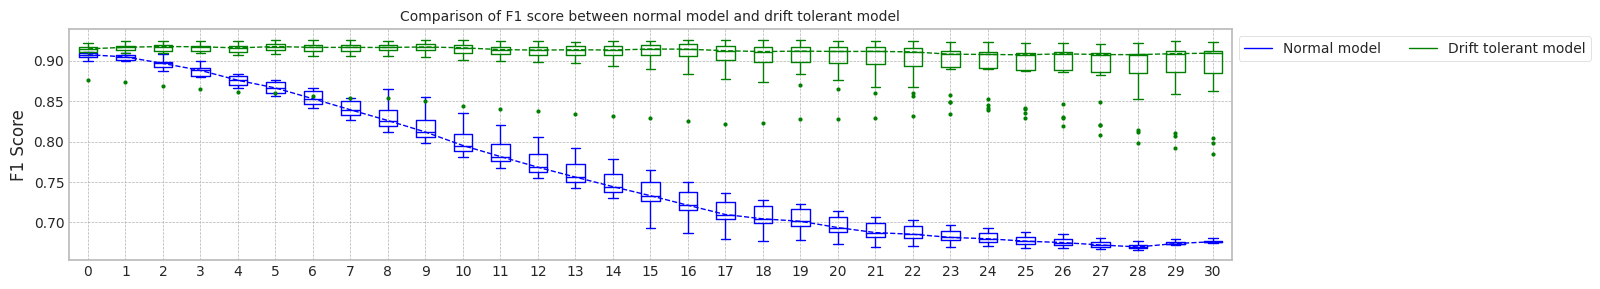

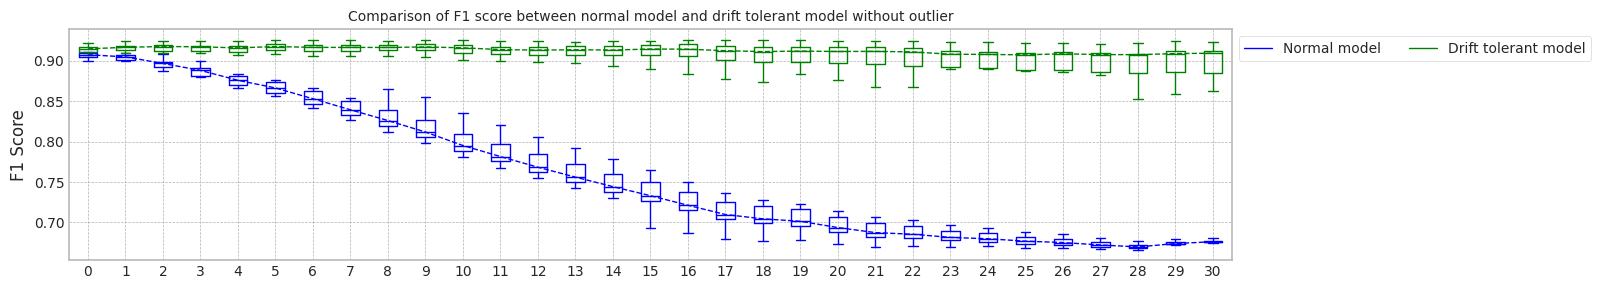

max_mean_trial= 6


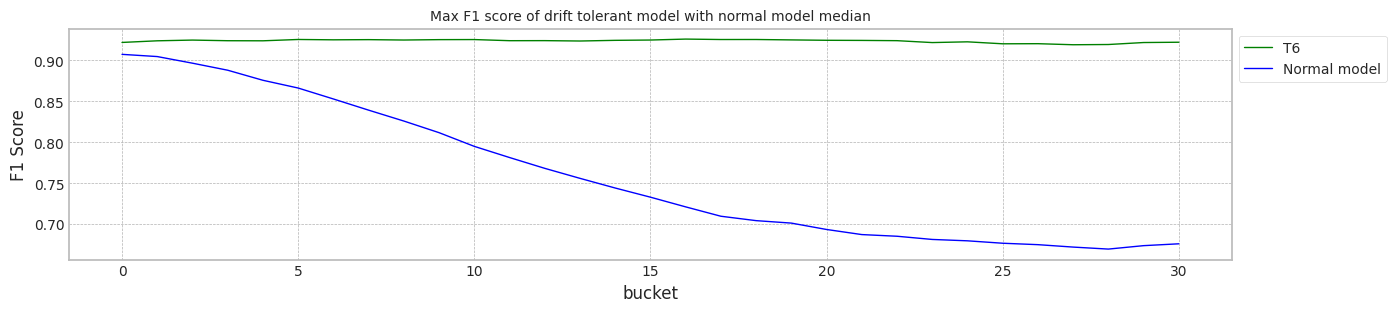

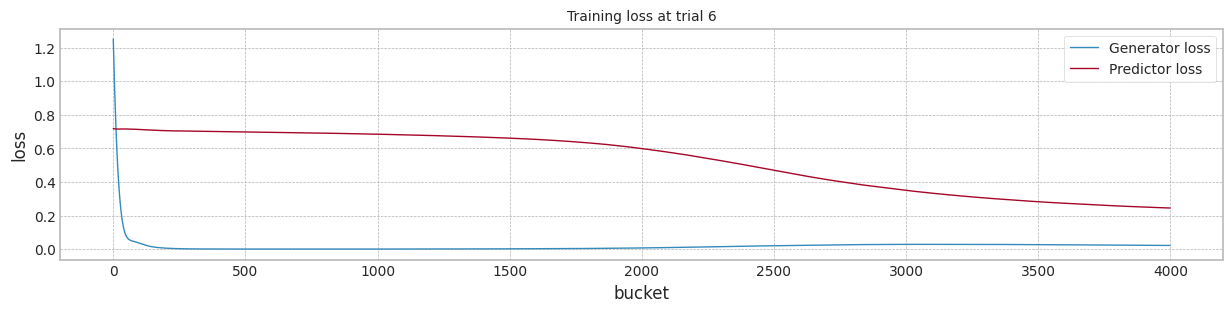

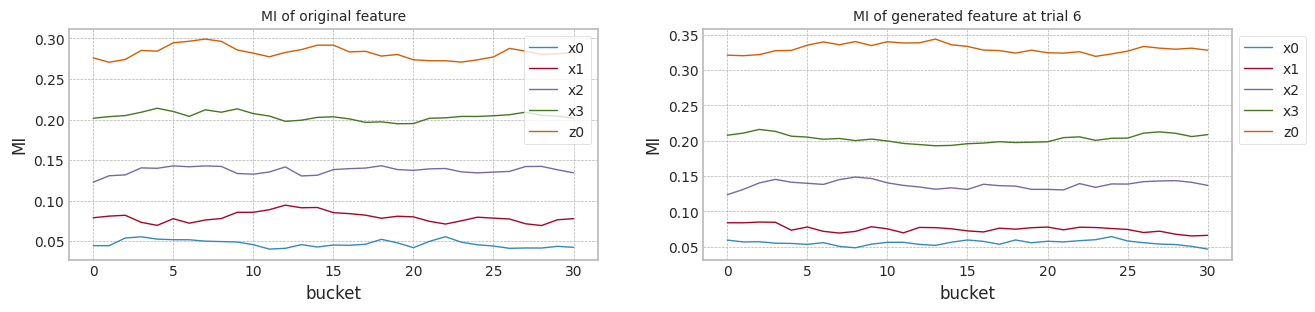

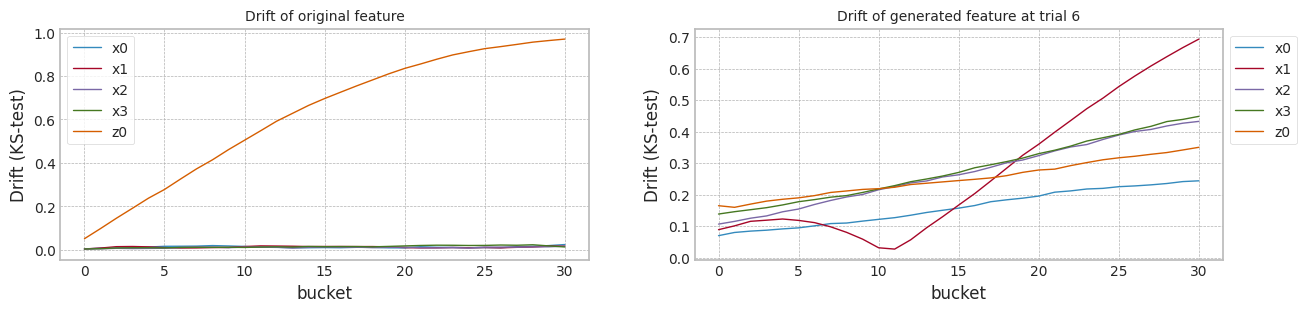

Trial   test_f1   init_f1   mean_f1   last_f1    Sum(MI0.0)    Std(MI0.0)  \
0    0.0  0.910243  0.910243  0.760589  0.675771  8.041122e-01  1.128421e-01   
1    1.0  0.906317  0.906317  0.752954  0.675024  8.041122e-01  1.128421e-01   
2    2.0  0.908172  0.908172  0.772092  0.679786  8.041122e-01  1.128421e-01   
3    3.0  0.910844  0.910844  0.761159  0.676121  8.041122e-01  1.128421e-01   
4    4.0  0.899773  0.899773  0.778179  0.677121  8.041122e-01  1.128421e-01   
5    5.0  0.908722  0.908722  0.754179  0.675124  8.041122e-01  1.128421e-01   
6    6.0  0.909832  0.909832  0.757495  0.675472  8.041122e-01  1.128421e-01   
7    7.0  0.879380  0.879380  0.727151  0.674328  8.041122e-01  1.128421e-01   
8    8.0  0.906548  0.906548  0.757589  0.676321  8.041122e-01  1.128421e-01   
9    9.0  0.904970  0.904970  0.758028  0.676121  8.041122e-01  1.128421e-01   
10  10.0  0.910181  0.910181  0.756240  0.675223  8.041122e-01  1.128421e-01   
11  11.0  0.901139  0.901139  0.781661  0.679030  8.041122e-01  1.128421e-01   
12  12.0  0.906293  0.906293  0.751322  0.674924  8.041122e-01  1.128421e-01   
13  13.0  0.906393  0.906393  0.773501  0.681051  8.041122e-01  1.128421e-01   
14  14.0  0.848892  0.848892  0.808150  0.686979  8.041122e-01  1.128421e-01   
15  15.0  0.908838  0.908838  0.769440  0.680039  8.041122e-01  1.128421e-01   
16  16.0  0.861084  0.861084  0.721379  0.674676  8.041122e-01  1.128421e-01   
17  17.0  0.908878  0.908878  0.756596  0.675771  8.041122e-01  1.128421e-01   
18  18.0  0.909600  0.909600  0.764244  0.676571  8.041122e-01  1.128421e-01   
19  19.0  0.910385  0.910385  0.765310  0.676721  8.041122e-01  1.128421e-01   
20  mean  0.900824  0.900824  0.761363  0.677109  8.041122e-01  1.128421e-01   
21   sem  0.003856  0.003856  0.004077  0.000673  5.094053e-17  3.183783e-18   

      Ent(MI0.0)    Sum(DR0.0)    Std(DR0.0)  ...    Ent(DR8.0)  TrainSum(MI)  \
0   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738968   
1   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738959   
2   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738869   
3   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738915   
4   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738963   
5   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738974   
6   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738962   
7   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738801   
8   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.739050   
9   1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738907   
10  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.739000   
11  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738967   
12  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738910   
13  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738987   
14  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738881   
15  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738870   
16  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738840   
17  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738823   
18  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738945   
19  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.739004   
20  1.367717e+00  3.021111e-01  7.682468e-02  ...  1.033720e+00      0.738930   
21  5.094053e-17  1.273513e-17  3.183783e-18  ...  5.094053e-17      0.000015   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.084225      1.445611      0.723681      0.084119      1.437383   
1       0.084218      1.445646      0.723716      0.084115      1.437435   
2       0.084236      1.445520      0.723726      0.084102      1.4374

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0    0.0  0.912564  0.912564  0.897393  0.889790    0.804254    0.112899   
1    1.0  0.914698  0.914698  0.915096  0.909741    0.803278    0.112715   
2    2.0  0.922233  0.922233  0.884692  0.784823    0.802835    0.112687   
3    3.0  0.921945  0.921945  0.918864  0.907698    0.803820    0.112866   
4    4.0  0.910378  0.910378  0.907875  0.908736    0.801973    0.112675   
5    5.0  0.914436  0.914436  0.902979  0.874988    0.803247    0.112382   
6    6.0  0.921897  0.921897  0.923651  0.922148    0.803910    0.113045   
7    7.0  0.915880  0.915880  0.913783  0.910031    0.805145    0.112307   
8    8.0  0.910963  0.910963  0.912537  0.910904    0.804107    0.112613   
9    9.0  0.920770  0.920770  0.921984  0.921403    0.804137    0.112799   
10  10.0  0.916785  0.916785  0.879306  0.804411    0.803814    0.112715   
11  11.0  0.915414  0.915414  0.884221  0.798524    0.803801    0.112886   
12  12.0  0.910544  0.910544  0.911833  0.912987    0.802034    0.113126   
13  13.0  0.912399  0.912399  0.912837  0.910646    0.803856    0.112728   
14  14.0  0.912802  0.912802  0.909320  0.910061    0.803531    0.112755   
15  15.0  0.876125  0.876125  0.845298  0.862439    0.803584    0.112521   
16  16.0  0.916313  0.916313  0.911790  0.888733    0.803043    0.112677   
17  17.0  0.915542  0.915542  0.919712  0.914654    0.804780    0.112639   
18  18.0  0.906974  0.906974  0.918963  0.923504    0.803828    0.112910   
19  19.0  0.908893  0.908893  0.907790  0.908579    0.802889    0.112762   
20  mean  0.912878  0.912878  0.904996  0.888740    0.803593    0.112735   
21   sem  0.002168  0.002168  0.004229  0.009605    0.000176    0.000044   

    Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  TrainSum(MI)  \
0     1.367760    0.539556    0.077574  ...    1.551711      0.787956   
1     1.367879    0.706000    0.068416  ...    1.591695      0.784680   
2     1.367838    0.537778    0.066808  ...    1.581627      0.792422   
3     1.367660    0.544889    0.062406  ...    1.559047      0.798260   
4     1.367514    0.735000    0.075564  ...    1.541848      0.799968   
5     1.369346    0.847889    0.086634  ...    1.498832      0.813187   
6     1.366571    0.628333    0.069695  ...    1.571213      0.795061   
7     1.371372    0.914222    0.105255  ...    1.461582      0.776787   
8     1.368788    0.911667    0.078569  ...    1.536469      0.795549   
9     1.367845    0.572889    0.065739  ...    1.563628      0.781565   
10    1.368136    0.675778    0.081047  ...    1.519480      0.802055   
11    1.367379    0.910444    0.098191  ...    1.503849      0.784508   
12    1.365238    0.951889    0.123706  ...    1.461766      0.769279   
13    1.368099    0.760111    0.062954  ...    1.583897      0.793816   
14    1.367681    0.538111    0.072895  ...    1.570852      0.779887   
15    1.368538    0.566000    0.093976  ...    1.432817      0.789506   
16    1.367784    0.607444    0.079081  ...    1.517374      0.812767   
17    1.369519    0.444889    0.047014  ...    1.550314      0.798129   
18    1.367413    0.513667    0.062952  ...    1.538748      0.785463   
19    1.367613    0.710222    0.052321  ...    1.571320      0.795208   
20    1.367999    0.680839    0.076540  ...    1.535404      0.791803   
21    0.000270    0.035111    0.004079  ...    0.009959      0.002479   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.098038      1.421505      0.779333      0.096104      1.420366   
1       0.096428      1.421294      0.788828      0.096334      1.423925   
2       0.098404      1.414545      0.776153      0.099443      1.403255   
3       0.095165      1.436235      0.800127      0.096066      1.431926   
4       0.100923      1.414616      0.783587      0.099296      1.412947   
5       0.100230      1.417001      0.793828      0.098578      1.414379   
6       0.097175      1.428945      0.7950

In [20]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [21]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


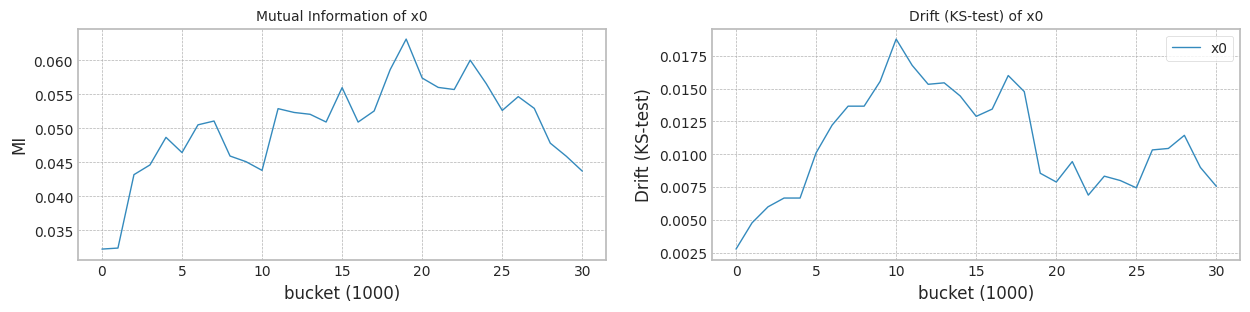

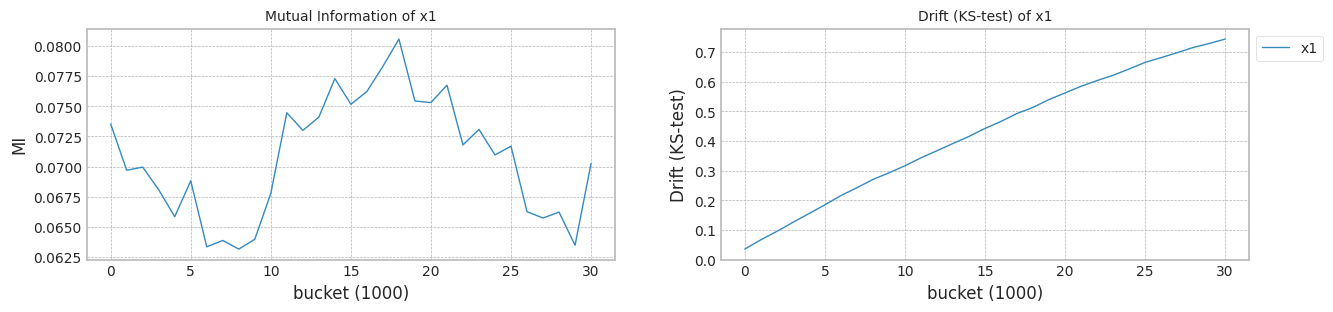

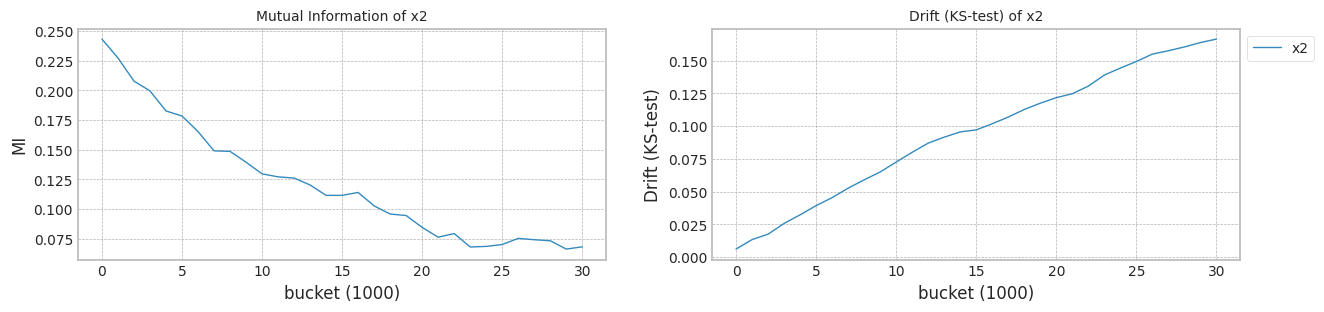

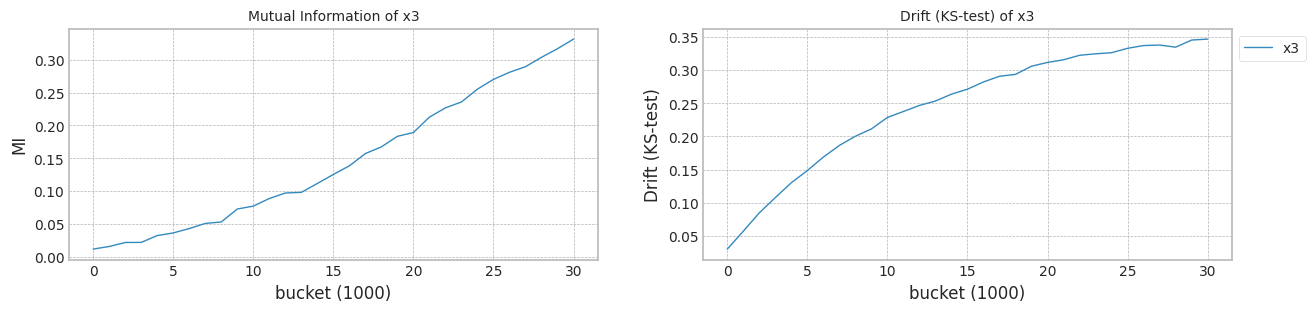

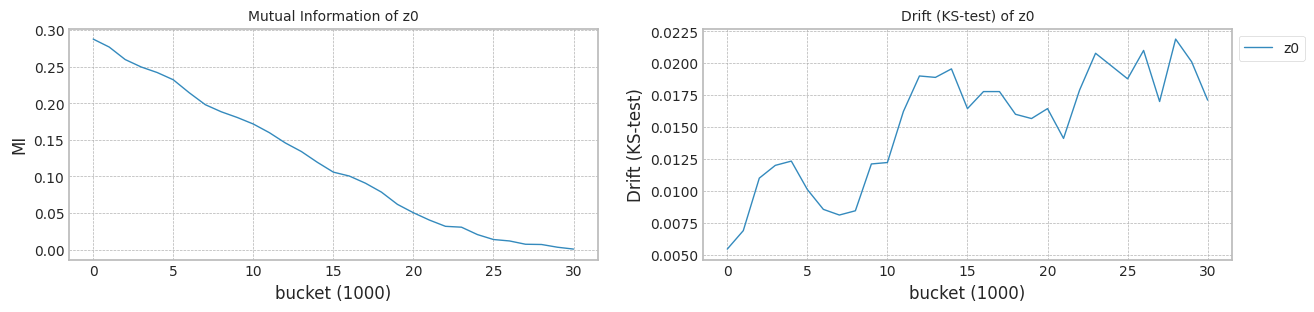

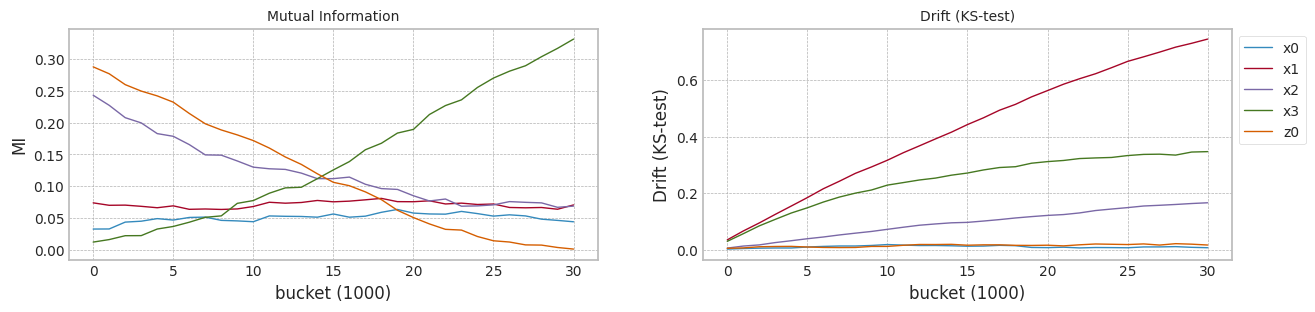

In [22]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

In [23]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]


lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 624.95it/s]


Test f1 score: 0.9227268417559494
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7642579759110337
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 607.90it/s]


Test f1 score: 0.919890286579022
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7452451225770277
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 626.79it/s]


Test f1 score: 0.9162887377173091
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7281406500741368
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 633.46it/s]


Test f1 score: 0.9085485224200616
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.6975945183233494
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 631.10it/s]


Test f1 score: 0.901307966706302
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.6929482855625227
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 629.75it/s]


Test f1 score: 0.890346600478681
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7006801220068734
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 646.18it/s]


Test f1 score: 0.9179400113186191
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7270199457468624
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 642.59it/s]


Test f1 score: 0.8781424581005587
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.6771602255406761
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 657.48it/s]


Test f1 score: 0.8962648256328555
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7449524123846523
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 632.48it/s]


Test f1 score: 0.9009059493789111
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.6871548558864762
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 627.90it/s]


Test f1 score: 0.9124380898981403
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.16it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7210155662551804
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 627.86it/s]


Test f1 score: 0.9177522107064753
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7469802073013696
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 627.80it/s]


Test f1 score: 0.9171721000758151
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.27it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7296546251271382
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 653.83it/s]


Test f1 score: 0.9055970149253731
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7142431947105415
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 646.96it/s]


Test f1 score: 0.9125867567060589
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.33it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.728302292490845
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 645.38it/s]


Test f1 score: 0.920728238194576
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7772921532549013
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 640.38it/s]


Test f1 score: 0.9071382279418572
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7076573134627481
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 608.66it/s]


Test f1 score: 0.9176404070863174
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7476656955417423
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 624.79it/s]


Test f1 score: 0.9269631031220436
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7736728400558445
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 618.89it/s]


Test f1 score: 0.9252452147414533
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7762484817505764
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.40it/s]


Test f1 score: 0.9280706808796697
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


mean of drift:
x0    0.140534
x1    0.309097
x2    0.136885
x3    0.300789
z0    0.258792
dtype: float64
Mean F1 for all data: 0.8017065834871306
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.10it/s]


Test f1 score: 0.9293858388425794
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.156373
x1    0.327341
x2    0.232875
x3    0.308444
z0    0.299645
dtype: float64
Mean F1 for all data: 0.7612258136789757
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.62it/s]


Test f1 score: 0.9307463260013447
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.117466
x1    0.326258
x2    0.193910
x3    0.489211
z0    0.116219
dtype: float64
Mean F1 for all data: 0.8163923574931238
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.54it/s]


Test f1 score: 0.9323727185398655
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.201735
x1    0.339491
x2    0.300247
x3    0.579362
z0    0.210839
dtype: float64
Mean F1 for all data: 0.7549153153811261
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.28it/s]


Test f1 score: 0.9254498714652957
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.155484
x1    0.337645
x2    0.253419
x3    0.239910
z0    0.177839
dtype: float64
Mean F1 for all data: 0.7816477403319929
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.01it/s]


Test f1 score: 0.9324622922470939
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.30it/s]


mean of drift:
x0    0.203910
x1    0.339728
x2    0.179620
x3    0.543968
z0    0.146240
dtype: float64
Mean F1 for all data: 0.7859731088795826
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.64it/s]


Test f1 score: 0.925415949512335
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.160090
x1    0.308735
x2    0.187505
x3    0.187097
z0    0.171878
dtype: float64
Mean F1 for all data: 0.7878614625401308
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.14it/s]


Test f1 score: 0.9286531858069439
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.164918
x1    0.314878
x2    0.190950
x3    0.390337
z0    0.222659
dtype: float64
Mean F1 for all data: 0.8188191069346816
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.73it/s]


Test f1 score: 0.911131221719457
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


mean of drift:
x0    0.202351
x1    0.302204
x2    0.215527
x3    0.308634
z0    0.254014
dtype: float64
Mean F1 for all data: 0.7559426082928015
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.18it/s]


Test f1 score: 0.9202226345083487
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.131559
x1    0.344004
x2    0.218896
x3    0.217971
z0    0.226330
dtype: float64
Mean F1 for all data: 0.7778859587602248
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.20it/s]


Test f1 score: 0.9311236708496982
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


mean of drift:
x0    0.132527
x1    0.327262
x2    0.143437
x3    0.544061
z0    0.248928
dtype: float64
Mean F1 for all data: 0.7956108208625963
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.35it/s]


Test f1 score: 0.9262474954679896
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.145527
x1    0.301871
x2    0.157634
x3    0.534502
z0    0.190358
dtype: float64
Mean F1 for all data: 0.8024946031983369
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 225.87it/s]


Test f1 score: 0.9251781472684085
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.179878
x1    0.360996
x2    0.121559
x3    0.440548
z0    0.170297
dtype: float64
Mean F1 for all data: 0.7739823752781119
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.06it/s]


Test f1 score: 0.9078971037956468
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.177111
x1    0.344900
x2    0.168613
x3    0.224061
z0    0.232943
dtype: float64
Mean F1 for all data: 0.7868956954180267
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.44it/s]


Test f1 score: 0.9198343304187759
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.157444
x1    0.328441
x2    0.185208
x3    0.405366
z0    0.167595
dtype: float64
Mean F1 for all data: 0.7730573877003771
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.25it/s]


Test f1 score: 0.9001331557922769
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.152093
x1    0.294186
x2    0.215183
x3    0.300312
z0    0.162581
dtype: float64
Mean F1 for all data: 0.7763427008602436
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.69it/s]


Test f1 score: 0.9303212277189973
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.166373
x1    0.332115
x2    0.145090
x3    0.258889
z0    0.282545
dtype: float64
Mean F1 for all data: 0.7821471585656457
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.38it/s]


Test f1 score: 0.9346500145222191
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


mean of drift:
x0    0.177760
x1    0.337262
x2    0.138290
x3    0.535896
z0    0.227222
dtype: float64
Mean F1 for all data: 0.814417439277612
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.85it/s]


Test f1 score: 0.9316543304815919
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.153649
x1    0.321910
x2    0.139703
x3    0.317011
z0    0.209814
dtype: float64
Mean F1 for all data: 0.8060447649863872
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.05it/s]


Test f1 score: 0.9330408241129339
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.40it/s]


mean of drift:
x0    0.114814
x1    0.326720
x2    0.163323
x3    0.587810
z0    0.211889
dtype: float64
Mean F1 for all data: 0.8110529001708457


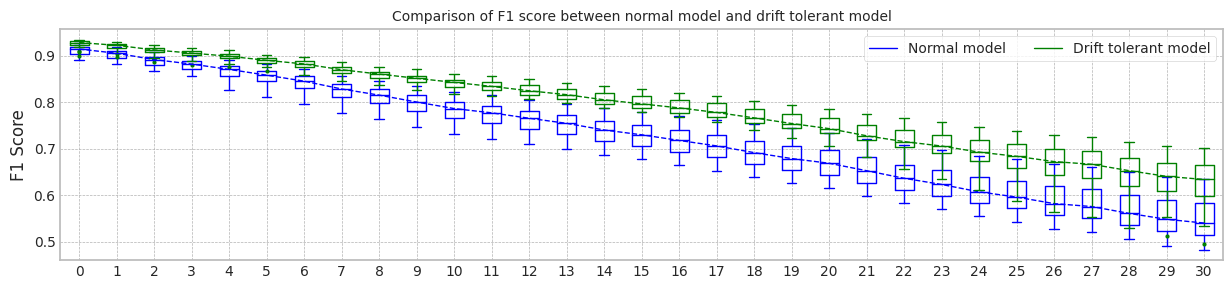

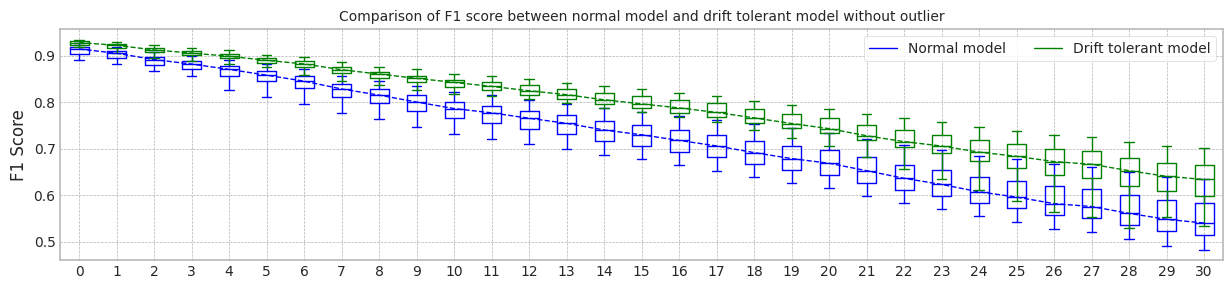

max_mean_trial= 7


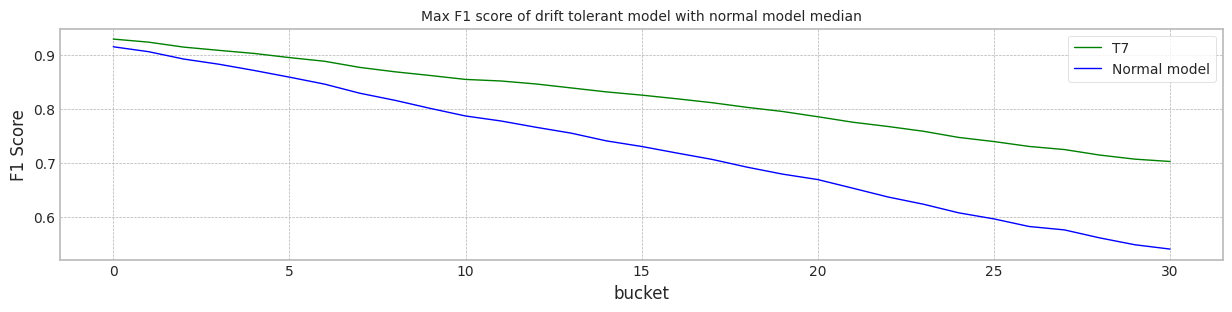

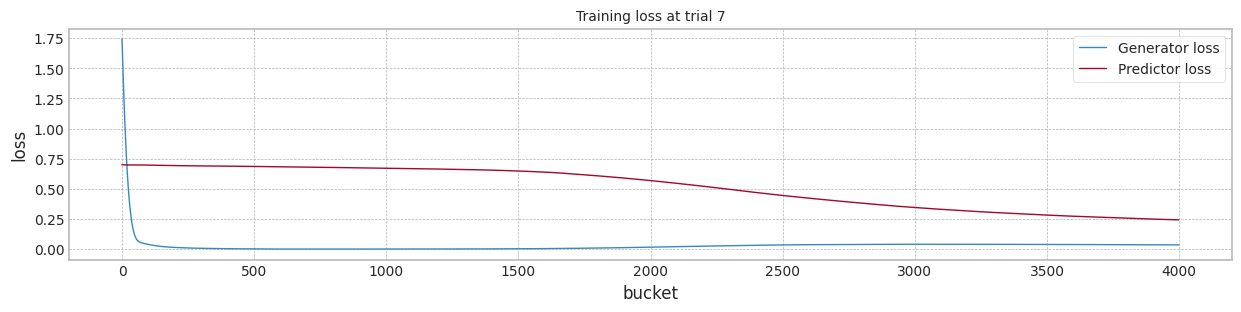

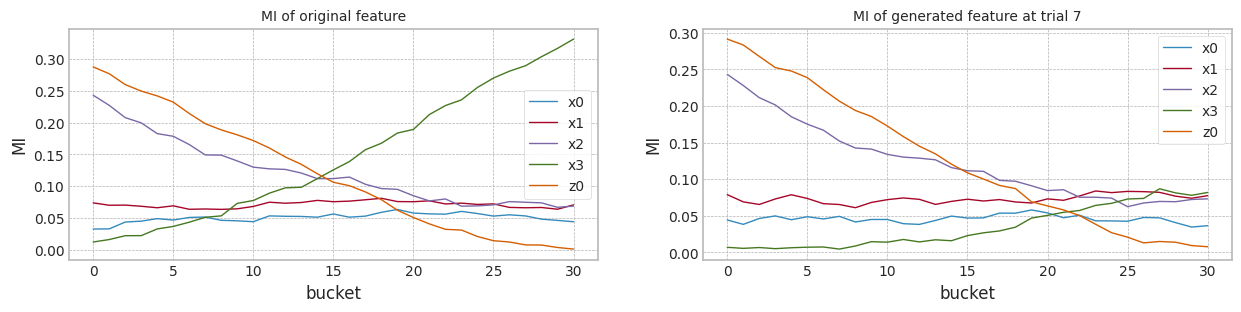

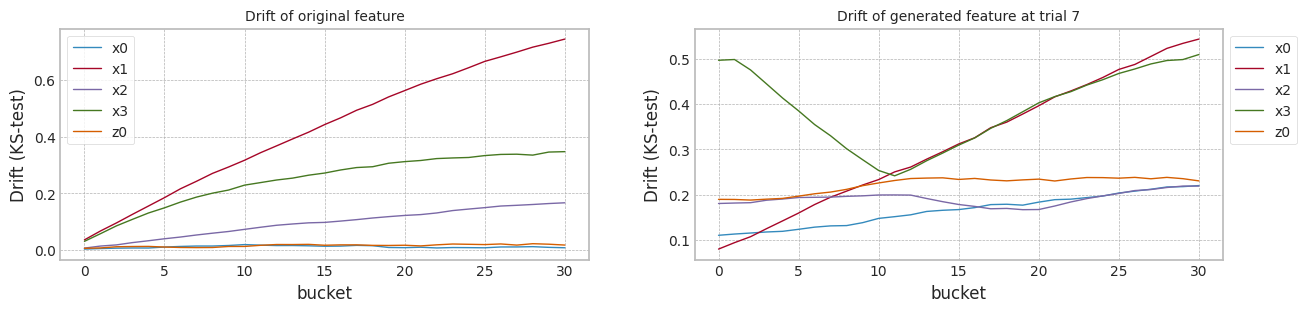

Trial   test_f1   init_f1   mean_f1   last_f1    Sum(MI0.0)    Std(MI0.0)  \
0    0.0  0.922727  0.922727  0.764258  0.604010  7.406589e-01  1.478341e-01   
1    1.0  0.919890  0.919890  0.745245  0.570849  7.406589e-01  1.478341e-01   
2    2.0  0.916289  0.916289  0.728141  0.540387  7.406589e-01  1.478341e-01   
3    3.0  0.908549  0.908549  0.697595  0.497654  7.406589e-01  1.478341e-01   
4    4.0  0.901308  0.901308  0.692948  0.483146  7.406589e-01  1.478341e-01   
5    5.0  0.890347  0.890347  0.700680  0.514264  7.406589e-01  1.478341e-01   
6    6.0  0.917940  0.917940  0.727020  0.540260  7.406589e-01  1.478341e-01   
7    7.0  0.878142  0.878142  0.677160  0.488926  7.406589e-01  1.478341e-01   
8    8.0  0.896265  0.896265  0.744952  0.603559  7.406589e-01  1.478341e-01   
9    9.0  0.900906  0.900906  0.687155  0.490036  7.406589e-01  1.478341e-01   
10  10.0  0.912438  0.912438  0.721016  0.539130  7.406589e-01  1.478341e-01   
11  11.0  0.917752  0.917752  0.746980  0.572423  7.406589e-01  1.478341e-01   
12  12.0  0.917172  0.917172  0.729655  0.539248  7.406589e-01  1.478341e-01   
13  13.0  0.905597  0.905597  0.714243  0.532287  7.406589e-01  1.478341e-01   
14  14.0  0.912587  0.912587  0.728302  0.548884  7.406589e-01  1.478341e-01   
15  15.0  0.920728  0.920728  0.777292  0.636002  7.406589e-01  1.478341e-01   
16  16.0  0.907138  0.907138  0.707657  0.515419  7.406589e-01  1.478341e-01   
17  17.0  0.917640  0.917640  0.747666  0.577106  7.406589e-01  1.478341e-01   
18  18.0  0.926963  0.926963  0.773673  0.623040  7.406589e-01  1.478341e-01   
19  19.0  0.925245  0.925245  0.776248  0.626636  7.406589e-01  1.478341e-01   
20  mean  0.910781  0.910781  0.729394  0.552163  7.406589e-01  1.478341e-01   
21   sem  0.002784  0.002784  0.006739  0.010725  5.094053e-17  6.367566e-18   

      Ent(MI0.0)  Sum(DR0.0)    Std(DR0.0)  ...    Ent(DR8.0)  TrainSum(MI)  \
0   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674754   
1   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674626   
2   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674824   
3   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674678   
4   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674801   
5   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674681   
6   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674741   
7   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674770   
8   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674680   
9   1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674694   
10  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674741   
11  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674613   
12  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674628   
13  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674610   
14  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674814   
15  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674738   
16  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674879   
17  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674826   
18  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674713   
19  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674750   
20  1.064643e+00       0.341  5.276374e-02  ...  1.265173e+00      0.674728   
21  5.094053e-17       0.000  1.591891e-18  ...  5.094053e-17      0.000017   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.118196      1.196888      0.648423      0.113436      1.197710   
1       0.118212      1.196520      0.648383      0.113463      1.197412   
2       0.118186      1.197067      0.648356      0.113427      1.197729   
3       0.118214      1.196607      0.64

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0    0.0  0.928071  0.928071  0.801707  0.669641    0.732780    0.149167   
1    1.0  0.929386  0.929386  0.761226  0.539494    0.740109    0.147617   
2    2.0  0.930746  0.930746  0.816392  0.689050    0.742293    0.147211   
3    3.0  0.932373  0.932373  0.754915  0.494725    0.734138    0.148584   
4    4.0  0.925450  0.925450  0.781648  0.614826    0.739496    0.147430   
5    5.0  0.932462  0.932462  0.785973  0.600046    0.745816    0.146605   
6    6.0  0.925416  0.925416  0.787861  0.636628    0.740151    0.147681   
7    7.0  0.928653  0.928653  0.818819  0.702296    0.740577    0.147407   
8    8.0  0.911131  0.911131  0.755943  0.534984    0.747843    0.146114   
9    9.0  0.920223  0.920223  0.777886  0.618668    0.739260    0.147783   
10  10.0  0.931124  0.931124  0.795611  0.631436    0.743596    0.146464   
11  11.0  0.926247  0.926247  0.802495  0.663680    0.738106    0.147930   
12  12.0  0.925178  0.925178  0.773982  0.598959    0.739152    0.147929   
13  13.0  0.907897  0.907897  0.786896  0.651121    0.740308    0.147608   
14  14.0  0.919834  0.919834  0.773057  0.581232    0.747598    0.146422   
15  15.0  0.900133  0.900133  0.776343  0.639468    0.741114    0.147789   
16  16.0  0.930321  0.930321  0.782147  0.598761    0.739738    0.147586   
17  17.0  0.934650  0.934650  0.814417  0.659864    0.735114    0.148568   
18  18.0  0.931654  0.931654  0.806045  0.668546    0.739033    0.147585   
19  19.0  0.933041  0.933041  0.811053  0.665875    0.765562    0.143138   
20  mean  0.925200  0.925200  0.788221  0.622965    0.741589    0.147331   
21   sem  0.002056  0.002056  0.004396  0.012114    0.001532    0.000277   

    Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  TrainSum(MI)  \
0     1.020430    0.965000    0.125705  ...    1.454512      0.678913   
1     1.065332    0.982889    0.120276  ...    1.528934      0.678799   
2     1.075261    0.970222    0.145534  ...    1.428682      0.683578   
3     1.036213    1.081000    0.160699  ...    1.418308      0.680156   
4     1.066114    1.035778    0.126340  ...    1.540218      0.695339   
5     1.090204    0.999667    0.159213  ...    1.389907      0.676970   
6     1.065074    0.980889    0.110586  ...    1.569857      0.688778   
7     1.069052    1.068111    0.143057  ...    1.449216      0.689362   
8     1.097585    0.805111    0.097598  ...    1.492276      0.670640   
9     1.063121    0.870889    0.067900  ...    1.564154      0.675049   
10    1.086198    1.050556    0.144926  ...    1.430726      0.673969   
11    1.058655    1.011778    0.123322  ...    1.456520      0.686017   
12    1.062543    0.929222    0.133599  ...    1.427025      0.671021   
13    1.066082    0.672556    0.046684  ...    1.576302      0.674582   
14    1.095459    0.910667    0.132814  ...    1.434854      0.683427   
15    1.066233    0.833889    0.102307  ...    1.515842      0.687583   
16    1.065141    0.998778    0.119249  ...    1.540846      0.687301   
17    1.039136    0.950333    0.159597  ...    1.286852      0.682944   
18    1.063054    0.956889    0.108561  ...    1.501621      0.682429   
19    1.151799    1.088333    0.161518  ...    1.423463      0.672863   
20    1.070134    0.958128    0.124474  ...    1.471506      0.680986   
21    0.006014    0.022796    0.006776  ...    0.016148      0.001529   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.122723      1.132225      0.661423      0.114242      1.192084   
1       0.118601      1.190405      0.653158      0.112643      1.201071   
2       0.121487      1.161865      0.655855      0.115700      1.155560   
3       0.121111      1.148307      0.650478      0.114478      1.159891   
4       0.121381      1.193641      0.658535      0.115112      1.195281   
5       0.122026      1.135076      0.652583      0.115941      1.151216   
6       0.120695      1.158571      0.6537

In [24]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b'])+1)

## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [17]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [18]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [19]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [20]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [75]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [76]:

X[2010].shape

(11497, 81)

In [77]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [78]:
seed_everything(12)

X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries                  0.375327
last_fico_range_high        0.090427
last_pymnt_amnt             0.085496
total_rec_late_fee          0.038954
int_rate                    0.016850
                              ...   
F2                          0.000000
chargeoff_within_12_mths    0.000000
G1                          0.000000
G3                          0.000000
D3                          0.000000
Name: MI Scores, Length: 81, dtype: float64


In [79]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [80]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'fico_range_high',
 'DirectPay',
 'inq_last_6mths',
 'A2']

In [81]:
top_columns = ['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 #'term',
 #'int_rate',
 #'annual_inc',
 #'debt_consolidation',
 'Y'
 #'RENT'
]

In [82]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 80]

In [83]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

MI Analysis MI Max 0.31575, Min 0.02165, Mean 0.16209, Std 0.13044
Dataset structure X_train, (50000, 4) X_test, (50000, 4) X_live (1269680, 4)
Truncate 49680 rows from live_set (1269680, 4)
Search MI & Drift...for X_live_set (122, 50000, 4)


100%|██████████| 122/122 [01:53<00:00,  1.08it/s]


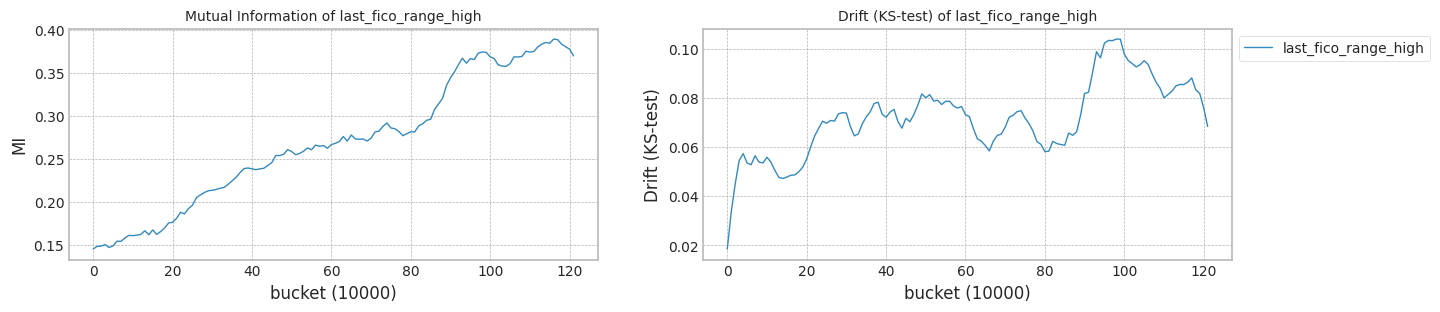

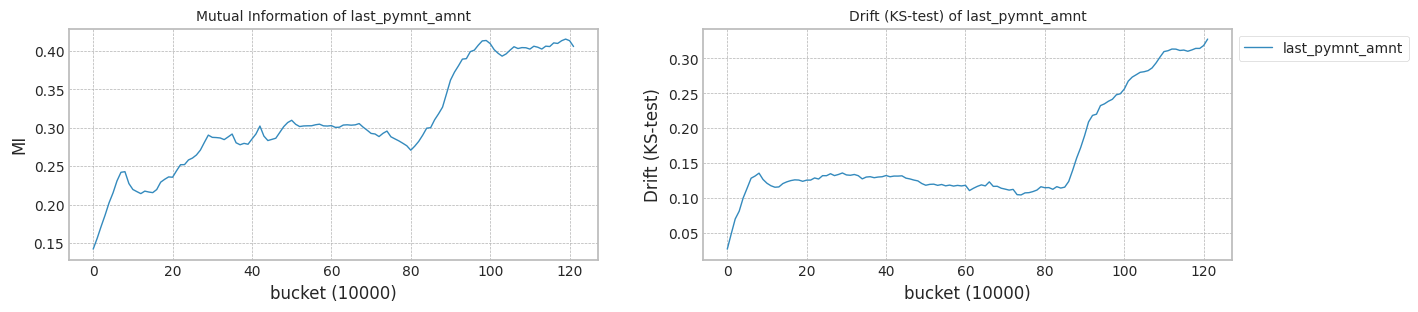

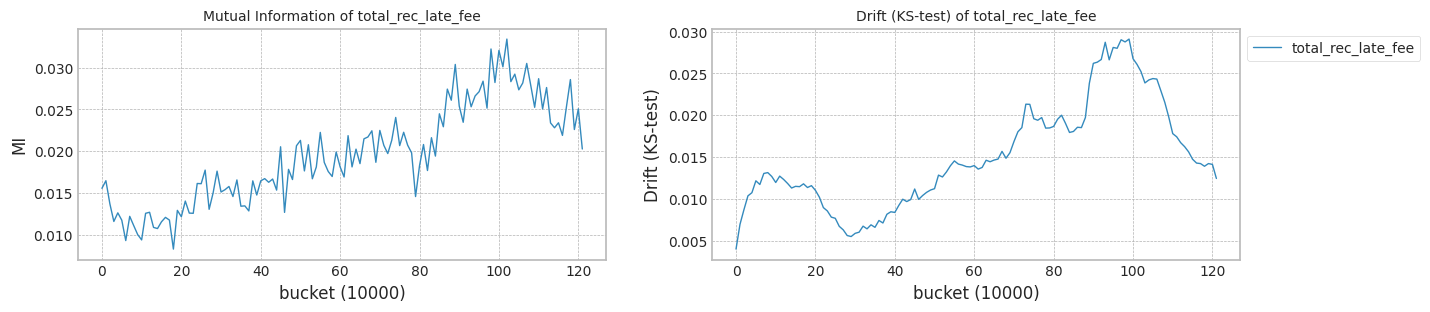

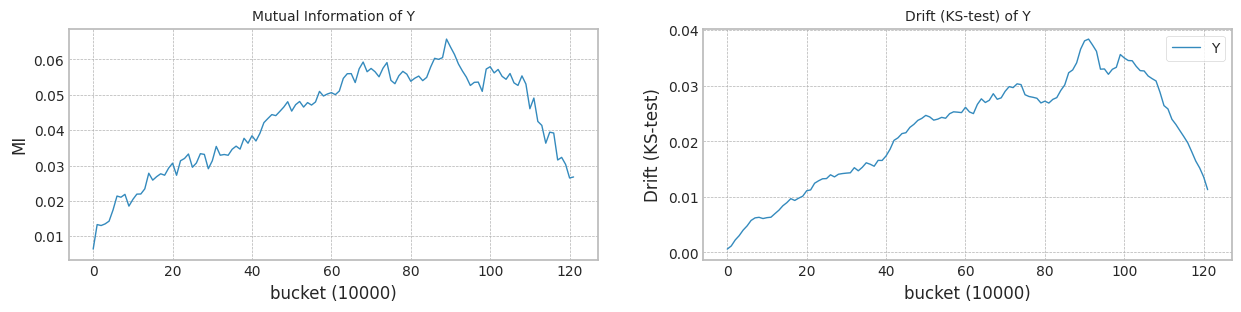

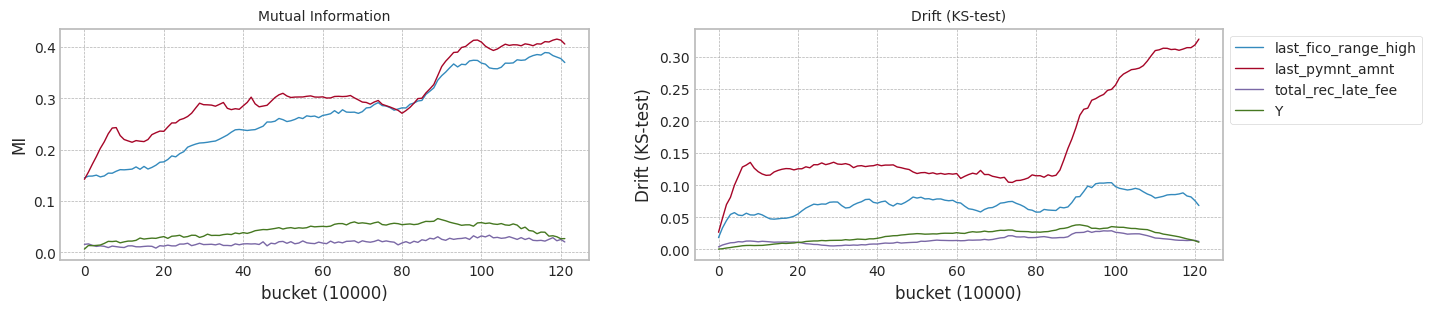

In [84]:
train_size = 50000
test_size = 10000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [85]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee    Y    b
0                    0.922353         0.023107            0.000000  0.0    0
1                    0.857647         0.007334            0.000000  0.0    0
2                    0.722353         0.267822            0.000000  0.0    0
3                    0.863529         0.015264            0.000000  0.0    0
4                    0.945882         0.019326            0.000000  0.0    0
...                       ...              ...                 ...  ...  ...
1279675              0.910588         0.000189            0.083241  0.0  255
1279676              0.851765         0.283658            0.000000  0.0  255
1279677              0.898824         0.235068            0.000000  0.0  255
1279678              0.916471         0.682716            0.000000  0.0  255
1279679              0.875294         0.264953            0.000000  0.0  255

[1279680 rows x 5 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 578.79it/s]


Test f1 score: 0.9148806677389906
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:54<00:00,  1.06it/s]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
Y                       0.021640
dtype: float64
Mean F1 for all data: 0.8942492303167419
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 562.28it/s]


Test f1 score: 0.9142943999305149
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:54<00:00,  1.07it/s]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
Y                       0.021640
dtype: float64
Mean F1 for all data: 0.8874931707204399
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 564.31it/s]


Test f1 score: 0.9169488757009855
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:54<00:00,  1.06it/s]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
Y                       0.021640
dtype: float64
Mean F1 for all data: 0.900740770231065
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 563.74it/s]


Test f1 score: 0.9178876011371092
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:53<00:00,  1.08it/s]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
Y                       0.021640
dtype: float64
Mean F1 for all data: 0.9037231532001329
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 566.44it/s]


Test f1 score: 0.9143322475570033
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:53<00:00,  1.08it/s]


mean of drift:
last_fico_range_high    0.094943
last_pymnt_amnt         0.161121
total_rec_late_fee      0.021651
Y                       0.021640
dtype: float64
Mean F1 for all data: 0.8877054355645774
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 228.61it/s]


Test f1 score: 0.9169506843646896
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:52<00:00,  1.09it/s]


mean of drift:
last_fico_range_high    0.695076
last_pymnt_amnt         0.674987
total_rec_late_fee      0.965477
Y                       0.991953
dtype: float64
Mean F1 for all data: 0.4744172801381024
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 227.64it/s]


Test f1 score: 0.9174596246180707
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:51<00:00,  1.09it/s]


mean of drift:
last_fico_range_high    0.233588
last_pymnt_amnt         0.656438
total_rec_late_fee      0.928037
Y                       0.995220
dtype: float64
Mean F1 for all data: 0.6572068158365193
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.64it/s]


Test f1 score: 0.9168027877599912
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:52<00:00,  1.09it/s]


mean of drift:
last_fico_range_high    0.550140
last_pymnt_amnt         0.530037
total_rec_late_fee      0.985297
Y                       0.994403
dtype: float64
Mean F1 for all data: 0.6685840398906965
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 226.55it/s]


Test f1 score: 0.9179435020834017
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:52<00:00,  1.08it/s]


mean of drift:
last_fico_range_high    0.612407
last_pymnt_amnt         0.657196
total_rec_late_fee      0.971658
Y                       0.995220
dtype: float64
Mean F1 for all data: 0.6524453390772994
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 225.15it/s]


Test f1 score: 0.9142943999305149
X_live.shape (1269680, 5)
Truncate 49680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([122, 50000, 5])


100%|██████████| 122/122 [01:50<00:00,  1.10it/s]


mean of drift:
last_fico_range_high    0.544951
last_pymnt_amnt         0.626892
total_rec_late_fee      0.958040
Y                       0.995220
dtype: float64
Mean F1 for all data: 0.8874931707204399


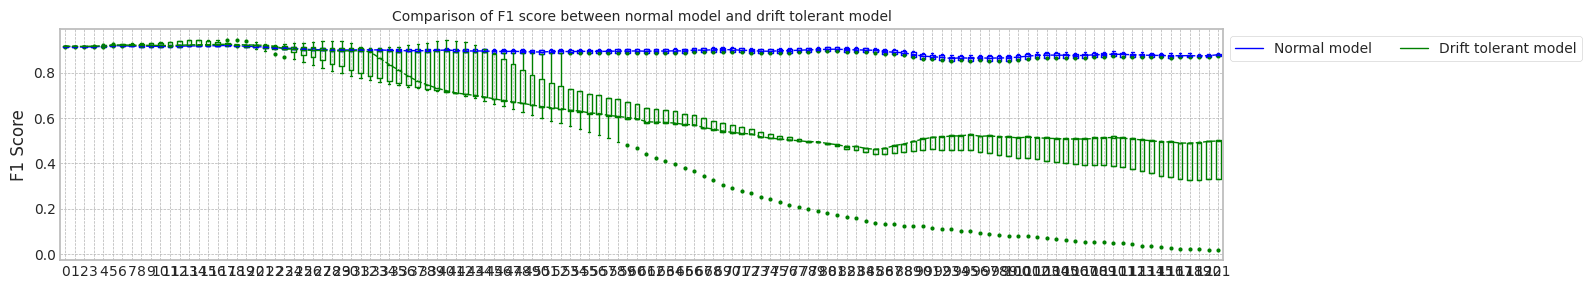

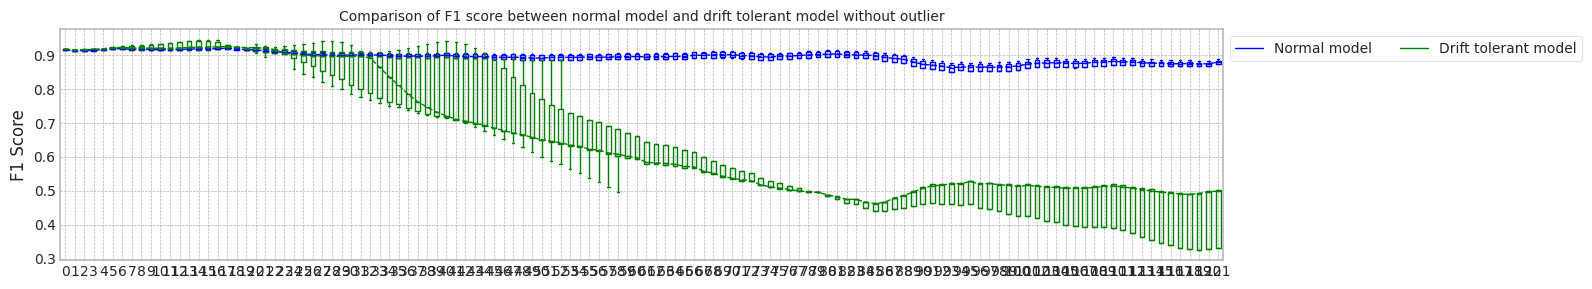

max_mean_trial= 4


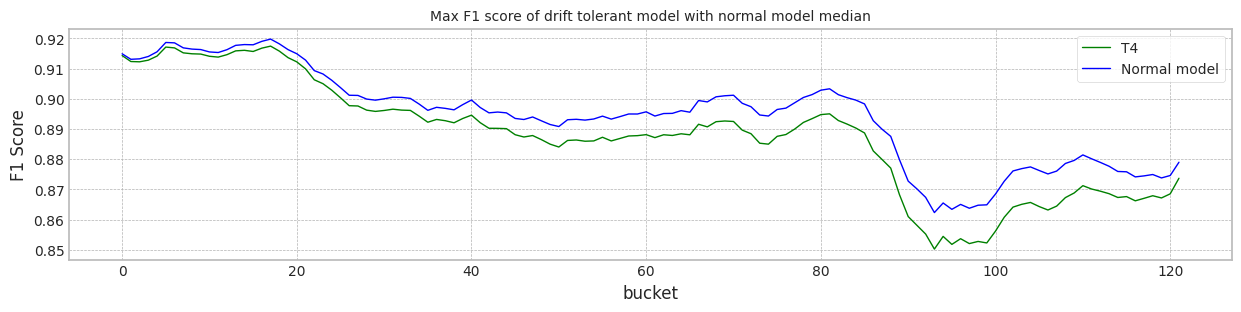

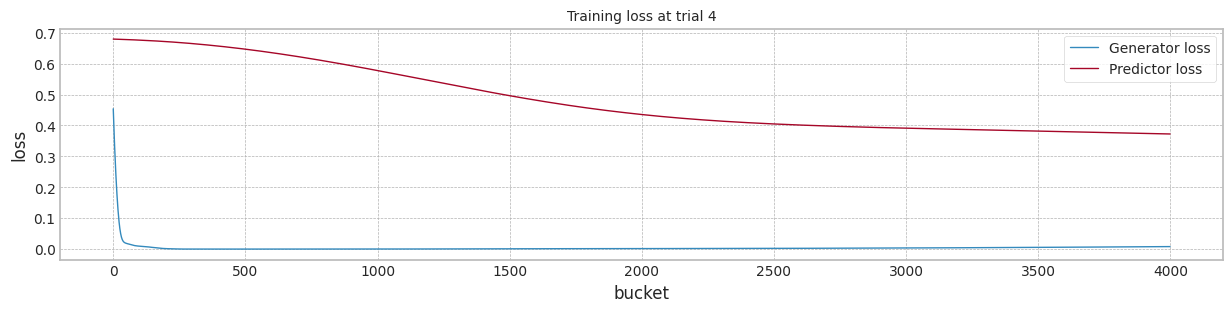

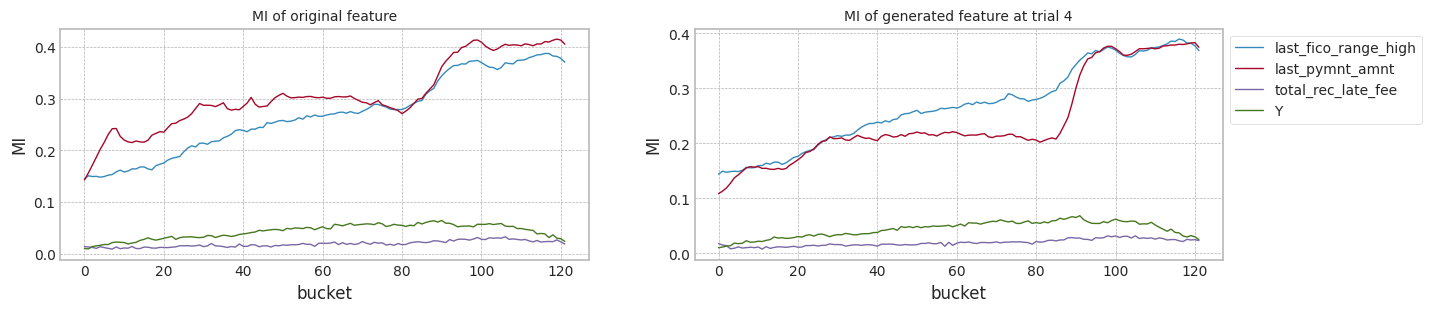

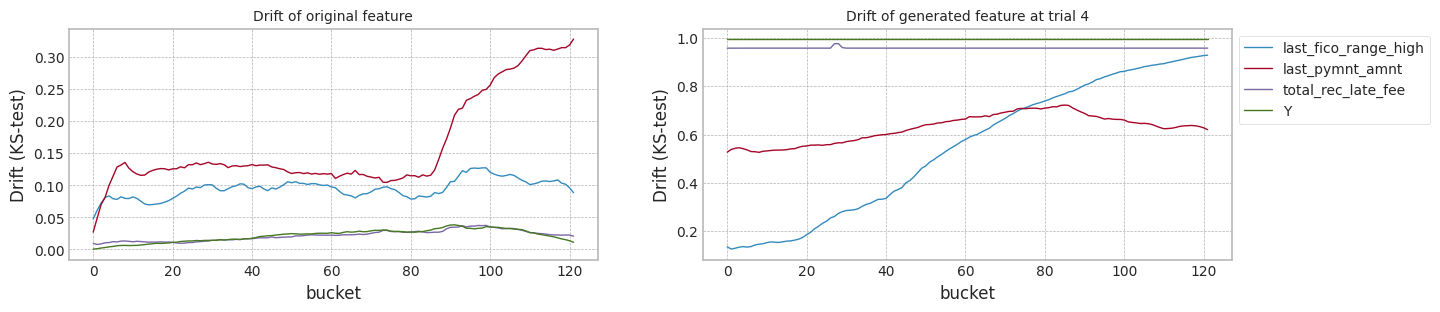

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0   0.0  0.914881  0.914881  0.894249  0.878972    0.197602    0.025346   
1   1.0  0.914294  0.914294  0.887493  0.873671    0.191050    0.030005   
2   2.0  0.916949  0.916949  0.900741  0.881920    0.187929    0.028540   
3   3.0  0.917888  0.917888  0.903723  0.887405    0.185175    0.029091   
4   4.0  0.914332  0.914332  0.887705  0.873819    0.189240    0.027775   
5  mean  0.915669  0.915669  0.894782  0.879157    0.190199    0.028151   
6   sem  0.000737  0.000737  0.003309  0.002591    0.002084    0.000790   

   Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...    Ent(DR9.0)  TrainSum(MI)  \
0    1.235840     0.13278     0.02631  ...  9.739541e-01      0.289954   
1    1.109592     0.13278     0.02631  ...  9.739541e-01      0.293047   
2    1.148424     0.13278     0.02631  ...  9.739541e-01      0.291838   
3    1.107802     0.13278     0.02631  ...  9.739541e-01      0.294363   
4    1.168677     0.13278     0.02631  ...  9.739541e-01      0.289954   
5    1.154067     0.13278     0.02631  ...  9.739541e-01      0.291831   
6    0.023506     0.00000     0.00000  ...  5.551115e-17      0.000864   

   TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0      0.057062      1.021476      0.312340      0.064512      0.986760   
1      0.058480      1.011319      0.315177      0.064260      0.999529   
2      0.058736      1.005319      0.320549      0.063886      1.020388   
3      0.056946      1.040263      0.314507      0.065500      0.974060   
4      0.057551      1.020917      0.312589      0.064844      0.981883   
5      0.057755      1.019859      0.315033      0.064600      0.992524   
6      0.000365      0.005935      0.001482      0.000274      0.008102   

   Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0           0.0           0.0           NaN  
1           0.0           0.0           NaN  
2           0.0           0.0           NaN  
3           0.0           0.0           NaN  
4           0.0           0.0           NaN  
5           0.0           0.0           NaN  
6           0.0           0.0           NaN  

[7 rows x 74 columns]

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0   0.0  0.916951  0.916951  0.474417  0.019911    0.184588    0.032343   
1   1.0  0.917460  0.917460  0.657207  0.501603    0.200414    0.028746   
2   2.0  0.916803  0.916803  0.668584  0.330945    0.202973    0.024578   
3   3.0  0.917944  0.917944  0.652445  0.498626    0.189567    0.030278   
4   4.0  0.914294  0.914294  0.887493  0.873671    0.189041    0.030145   
5  mean  0.916690  0.916690  0.668029  0.444951    0.193316    0.029218   
6   sem  0.000632  0.000632  0.065578  0.138482    0.003551    0.001294   

   Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR9.0)  TrainSum(MI)  \
0    1.033233    2.609240    0.332162  ...    1.220046      0.260114   
1    1.194751    2.761040    0.297467  ...    1.253424      0.258401   
2    1.238994    2.533380    0.345640  ...    1.205566      0.265104   
3    1.150783    2.714820    0.315124  ...    1.240030      0.259673   
4    1.111671    2.644260    0.331767  ...    1.215052      0.263483   
5    1.145887    2.652548    0.324432  ...    1.226824      0.261355   
6    0.035314    0.039871    0.008298  ...    0.008713      0.001259   

   TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0      0.051909      1.027797      0.275397      0.058541      0.971319   
1      0.051270      1.026913      0.275665      0.057715      0.985709   
2      0.052907      1.018161      0.281582      0.057982      0.999599   
3      0.052129      1.017216      0.281025      0.057149      1.013958   
4      0.050056      1.063340      0.275240      0.057720      0.985077   
5      0.051654      1.030685      0.277782      0.057821      0.991132   
6      0.000478      0.008447      0.001442      0.000226      0.007250   

   Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0      2.339300      0.282046      1.258331  
1      2.731920      0.311305      1.271031  
2      2.034420      0.264778      1.239460  
3      2.688060      0.326403      1.251837  
4      2.629620      0.348013      1.218525  
5      2.484664      0.306509      1.247837  
6      0.131789      0.014969      0.008926  

[7 rows x 74 columns]

In [86]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) #np.max(X1['b'])+1)


### #2

In [ ]:
top_columns = list(mi_scores[1:10].index)
top_columns

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]

In [ ]:
train_size = 50000
test_size = 10000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [ ]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) #np.max(X1['b'])+1)

### #3

In [ ]:
top_columns = list(mi_scores[1:6].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term']

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1]

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]

MI Analysis MI Max 0.31586, Min 0.02144, Mean 0.15204, Std 0.11901
Dataset structure X_train, (100000, 5) X_test, (100000, 5) X_live (1259680, 5)
Truncate 99680 rows from live_set (1259680, 5)
Search MI & Drift...for X_live_set (58, 100000, 5)


100%|██████████| 58/58 [02:22<00:00,  2.45s/it]


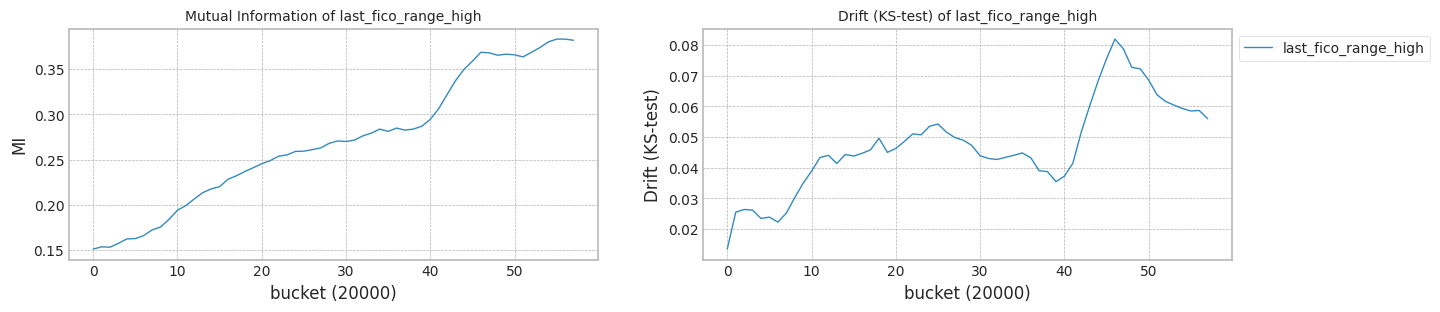

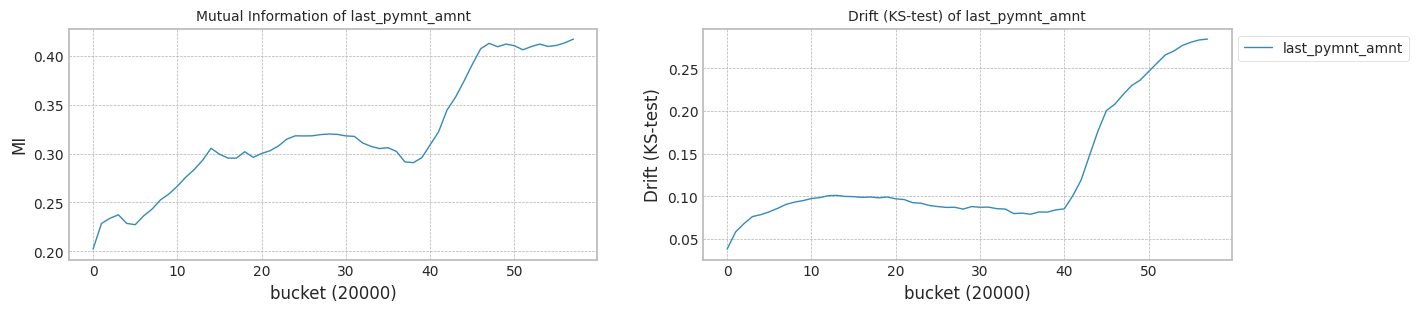

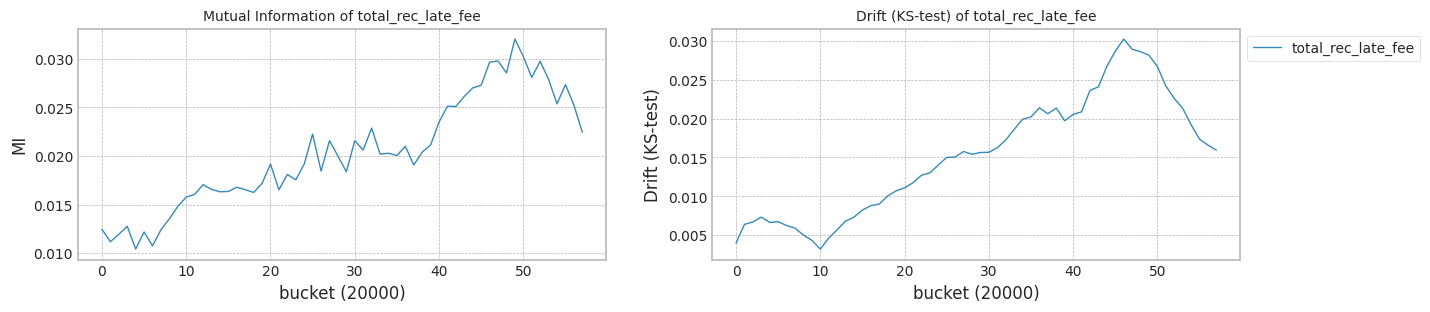

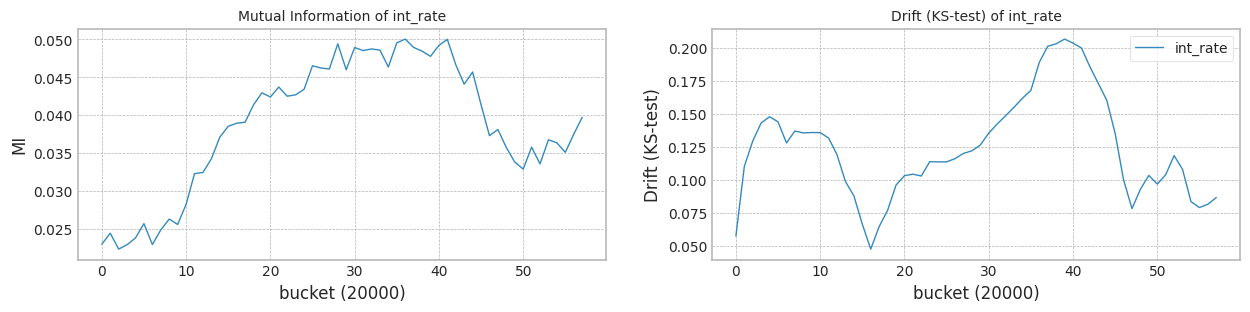

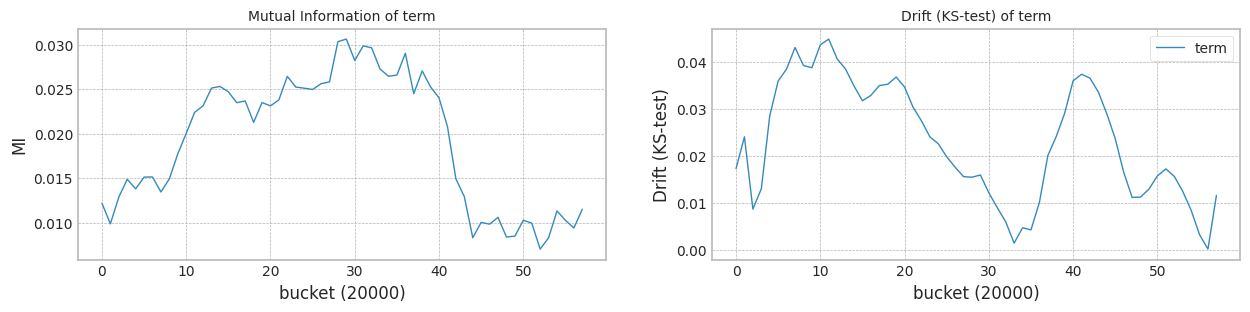

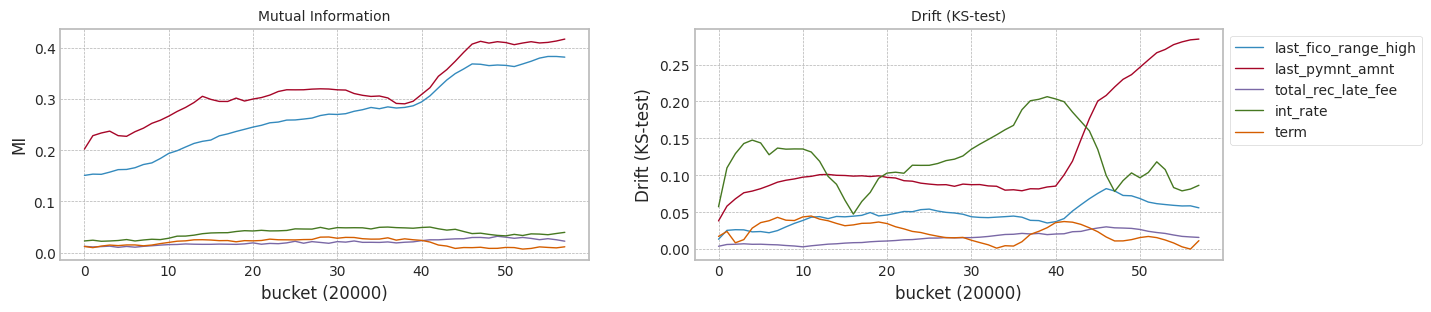

In [ ]:
train_size = 100000
test_size = 20000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [ ]:
bucket_size = 20000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.922353         0.023107            0.000000  0.418593   
1                    0.857647         0.007334            0.000000  0.347201   
2                    0.722353         0.267822            0.000000  0.472008   
3                    0.863529         0.015264            0.000000  0.543400   
4                    0.945882         0.019326            0.000000  0.329224   
...                       ...              ...                 ...       ...   
1279675              0.910588         0.000189            0.052309  0.231638   
1279676              0.851765         0.283658            0.000000  0.231638   
1279677              0.898824         0.235068            0.000000  0.130971   
1279678              0.916471         0.682716            0.000000 -0.005136   
1279679              0.875294         0.264953            0.000000  1.303030   

         term   b  
0         0.0   0  
1         0.0   0  
2         0.0   0  
3         0.0   0  
4         0.0   0  
...       ...  ..  
1279675   0.0  63  
1279676   0.0  63  
1279677   0.0  63  
1279678   0.0  63  
1279679   1.0  63  

[1279680 rows x 6 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 574.03it/s]


Test f1 score: 0.9149575412499117
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8885716221713209
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 588.98it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 588.20it/s]


Test f1 score: 0.9216374654557641
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8998556544512725
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 579.98it/s]


Test f1 score: 0.918113384828852
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8958125801316764
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 592.25it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 587.75it/s]


Test f1 score: 0.9243830403858279
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.9068508447988994
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 575.49it/s]


Test f1 score: 0.9147909007477721
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:22<00:00,  2.46s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8880984306975221
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 576.27it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:22<00:00,  2.46s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8872944302322595
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 579.36it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:22<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 569.77it/s]


Test f1 score: 0.9151216119286196
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8901197956016141
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 568.30it/s]


Test f1 score: 0.9279314461689522
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.9167106402574711
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 582.60it/s]


Test f1 score: 0.9148643729865106
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8885298261684199
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 579.02it/s]


Test f1 score: 0.9146502348055051
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8876512835153842
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 576.63it/s]


Test f1 score: 0.9230752284280733
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:22<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.9048958804535386
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 572.76it/s]


Test f1 score: 0.9147629468334084
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:22<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8879068100979817
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 591.33it/s]


Test f1 score: 0.9259700335115074
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:22<00:00,  2.46s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.9117539193329003
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 588.12it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.48s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 576.77it/s]


Test f1 score: 0.9214622186716619
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.48s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8997371345428202
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 591.59it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:22<00:00,  2.47s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 595.05it/s]


Test f1 score: 0.925998036376949
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:23<00:00,  2.48s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.911613095586902
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 103.23it/s]


Test f1 score: 0.9315492200107586
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.436974
last_pymnt_amnt         0.518343
total_rec_late_fee      0.975422
int_rate                0.141805
term                    0.767480
dtype: float64
Mean F1 for all data: 0.9448670003869881
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.97it/s]


Test f1 score: 0.9298312904749992
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.311454
last_pymnt_amnt         0.628725
total_rec_late_fee      0.957306
int_rate                0.142828
term                    0.767480
dtype: float64
Mean F1 for all data: 0.890155896898825
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.85it/s]


Test f1 score: 0.9352068342778208
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:18<00:00,  2.39s/it]


mean of drift:
last_fico_range_high    0.688046
last_pymnt_amnt         0.686354
total_rec_late_fee      0.956374
int_rate                0.133357
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8907334358535607
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.89it/s]


Test f1 score: 0.9271276124690045
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:18<00:00,  2.39s/it]


mean of drift:
last_fico_range_high    0.225526
last_pymnt_amnt         0.636509
total_rec_late_fee      0.943041
int_rate                0.124788
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8918986022930074
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:39<00:00, 102.15it/s]


Test f1 score: 0.9322718110819778
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.369467
last_pymnt_amnt         0.560831
total_rec_late_fee      0.988434
int_rate                0.133285
term                    0.767480
dtype: float64
Mean F1 for all data: 0.9410922905470059
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.97it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:18<00:00,  2.39s/it]


mean of drift:
last_fico_range_high    0.646820
last_pymnt_amnt         0.442876
total_rec_late_fee      0.962998
int_rate                0.122167
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.87it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:18<00:00,  2.39s/it]


mean of drift:
last_fico_range_high    0.510390
last_pymnt_amnt         0.596248
total_rec_late_fee      0.985327
int_rate                0.149491
term                    0.731868
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.85it/s]


Test f1 score: 0.928379100093462
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.485251
last_pymnt_amnt         0.691707
total_rec_late_fee      0.946034
int_rate                0.157931
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8979235255226198
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 103.03it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:18<00:00,  2.39s/it]


mean of drift:
last_fico_range_high    0.170133
last_pymnt_amnt         0.651331
total_rec_late_fee      0.962997
int_rate                0.160461
term                    0.756157
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.99it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:18<00:00,  2.39s/it]


mean of drift:
last_fico_range_high    0.646499
last_pymnt_amnt         0.550453
total_rec_late_fee      0.964069
int_rate                0.126402
term                    0.752021
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.99it/s]


Test f1 score: 0.9158745350531835
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.41s/it]


mean of drift:
last_fico_range_high    0.244899
last_pymnt_amnt         0.587245
total_rec_late_fee      0.957351
int_rate                0.124010
term                    0.767480
dtype: float64
Mean F1 for all data: 0.9450075845506298
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.90it/s]


Test f1 score: 0.9335734383792909
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.208973
last_pymnt_amnt         0.573648
total_rec_late_fee      0.939622
int_rate                0.139064
term                    0.767480
dtype: float64
Mean F1 for all data: 0.892514414351083
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 103.08it/s]


Test f1 score: 0.9357528762660733
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.368976
last_pymnt_amnt         0.513675
total_rec_late_fee      0.950738
int_rate                0.188086
term                    0.767480
dtype: float64
Mean F1 for all data: 0.9594288212805148
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 103.04it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.41s/it]


mean of drift:
last_fico_range_high    0.207412
last_pymnt_amnt         0.550949
total_rec_late_fee      0.979746
int_rate                0.142319
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.98it/s]


Test f1 score: 0.9189617140236312
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.41s/it]


mean of drift:
last_fico_range_high    0.235457
last_pymnt_amnt         0.453327
total_rec_late_fee      0.991341
int_rate                0.149724
term                    0.767480
dtype: float64
Mean F1 for all data: 0.924544890353348
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.96it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:18<00:00,  2.39s/it]


mean of drift:
last_fico_range_high    0.353828
last_pymnt_amnt         0.602206
total_rec_late_fee      0.980937
int_rate                0.125921
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.86it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.218932
last_pymnt_amnt         0.593196
total_rec_late_fee      0.964262
int_rate                0.134678
term                    0.753890
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.95it/s]


Test f1 score: 0.9326618398398286
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.41s/it]


mean of drift:
last_fico_range_high    0.346019
last_pymnt_amnt         0.633866
total_rec_late_fee      0.978046
int_rate                0.126346
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8936604368321807
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.95it/s]


Test f1 score: 0.934123332710841
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.41s/it]


mean of drift:
last_fico_range_high    0.498896
last_pymnt_amnt         0.533178
total_rec_late_fee      0.946179
int_rate                0.169496
term                    0.737336
dtype: float64
Mean F1 for all data: 0.9562910896432066
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:38<00:00, 102.83it/s]


Test f1 score: 0.9253259319053885
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:19<00:00,  2.41s/it]


mean of drift:
last_fico_range_high    0.266997
last_pymnt_amnt         0.501588
total_rec_late_fee      0.951855
int_rate                0.122664
term                    0.767480
dtype: float64
Mean F1 for all data: 0.9091043731817985


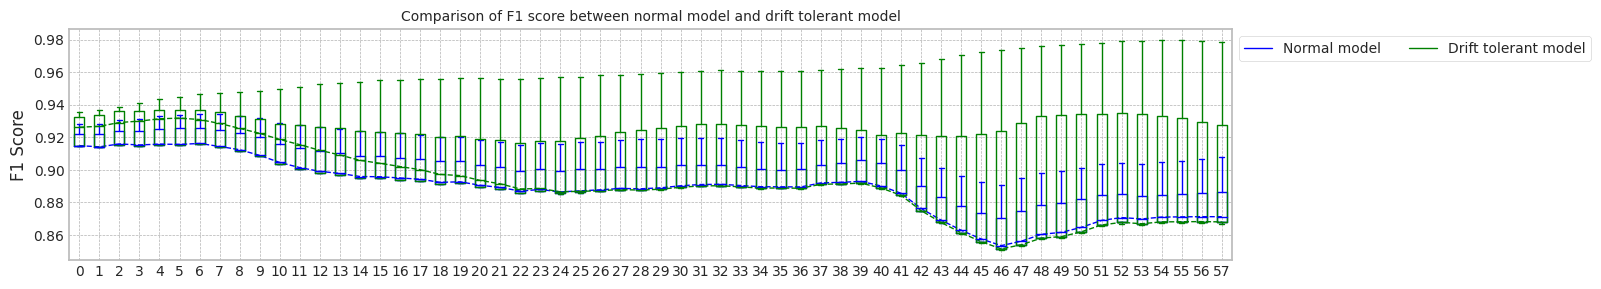

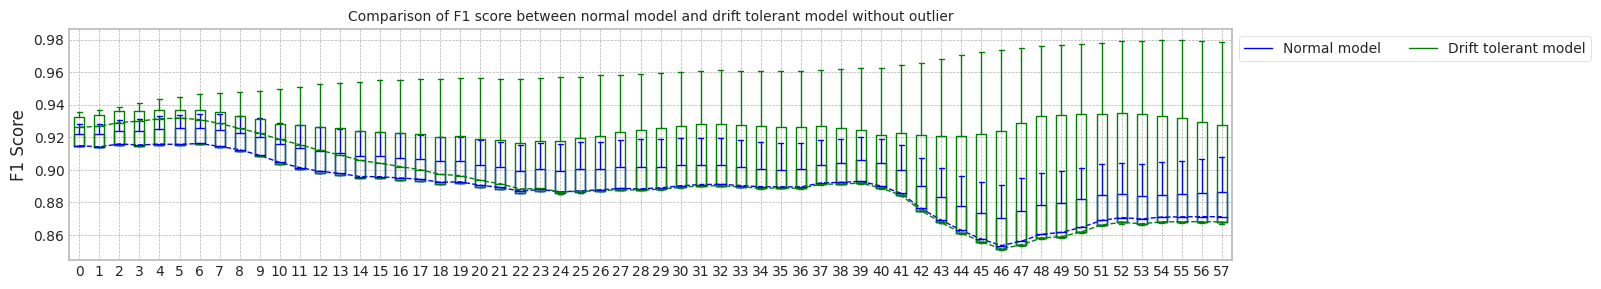

max_mean_trial= 12


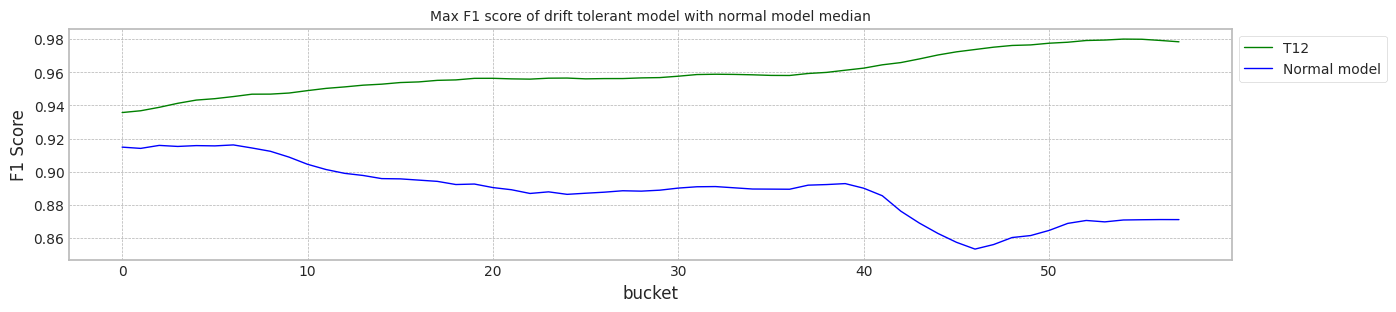

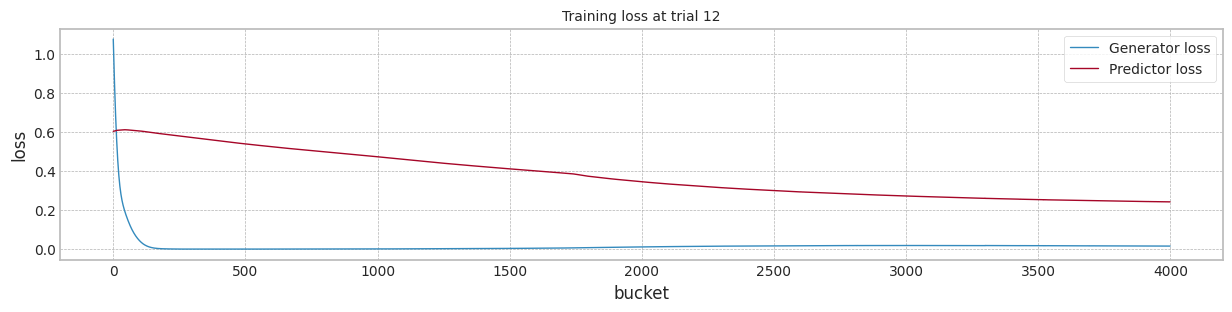

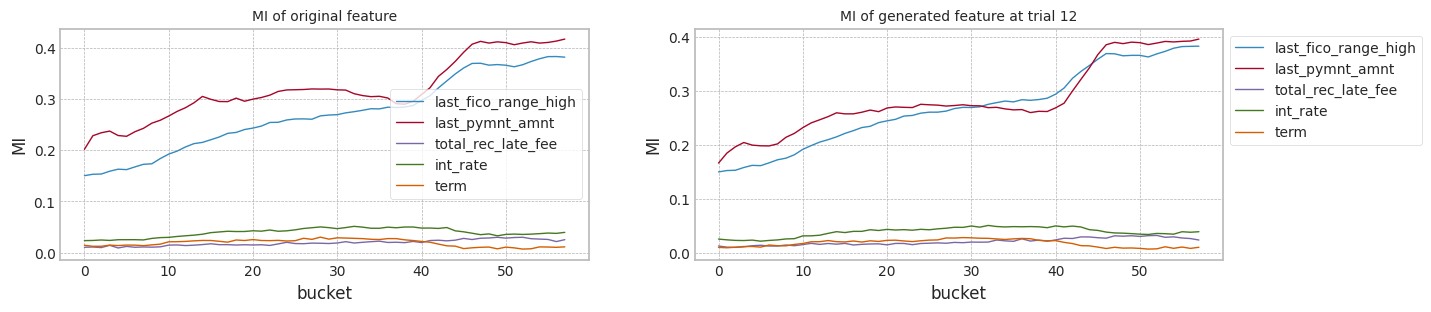

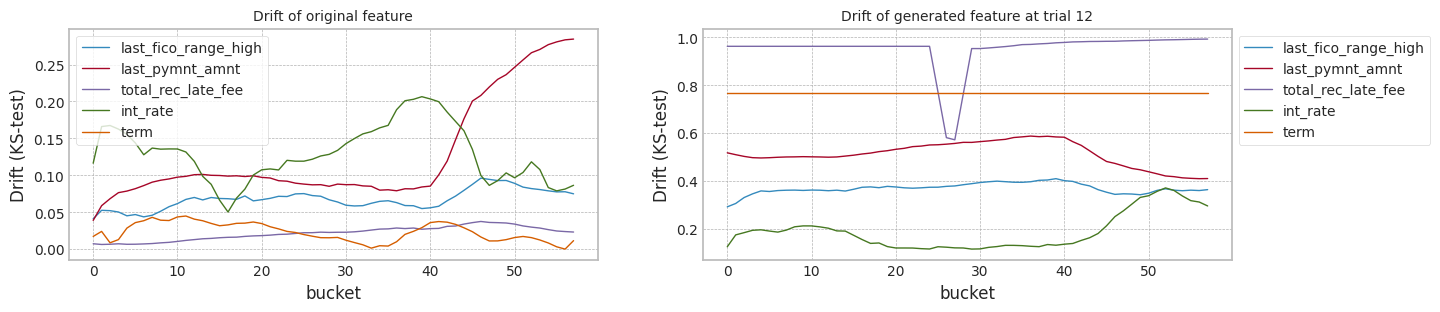

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0    0.0  0.914958  0.914958  0.888572  0.870629    0.259949    0.039809   
1    1.0  0.914583  0.914583  0.887303  0.868055    0.267028    0.038436   
2    2.0  0.921637  0.921637  0.899856  0.883739    0.263777    0.039985   
3    3.0  0.918113  0.918113  0.895813  0.881741    0.262318    0.039750   
4    4.0  0.914583  0.914583  0.887303  0.868055    0.262501    0.040041   
5    5.0  0.924383  0.924383  0.906851  0.893913    0.265486    0.040619   
6    6.0  0.914791  0.914791  0.888098  0.870261    0.270616    0.039399   
7    7.0  0.914583  0.914583  0.887294  0.868065    0.269919    0.037617   
8    8.0  0.914583  0.914583  0.887303  0.868055    0.265220    0.038622   
9    9.0  0.915122  0.915122  0.890120  0.875801    0.270402    0.040177   
10  10.0  0.927931  0.927931  0.916711  0.908180    0.270152    0.039983   
11  11.0  0.914864  0.914864  0.888530  0.871837    0.269953    0.040237   
12  12.0  0.914650  0.914650  0.887651  0.868872    0.263841    0.039565   
13  13.0  0.923075  0.923075  0.904896  0.889954    0.273024    0.038936   
14  14.0  0.914763  0.914763  0.887907  0.869040    0.266306    0.039385   
15  15.0  0.925970  0.925970  0.911754  0.899833    0.265616    0.040948   
16  16.0  0.914583  0.914583  0.887303  0.868055    0.268060    0.039359   
17  17.0  0.921462  0.921462  0.899737  0.885289    0.262657    0.040246   
18  18.0  0.914583  0.914583  0.887303  0.868055    0.272007    0.039965   
19  19.0  0.925998  0.925998  0.911613  0.900411    0.267449    0.039289   
20  mean  0.918261  0.918261  0.895096  0.878892    0.266814    0.039618   
21   sem  0.001083  0.001083  0.002252  0.002940    0.000816    0.000175   

    Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...    Ent(DR4.0)  TrainSum(MI)  \
0     1.310708     0.41676    0.050382  ...  1.331526e+00      0.354925   
1     1.347981     0.41676    0.050382  ...  1.331526e+00      0.355822   
2     1.314737     0.41676    0.050382  ...  1.331526e+00      0.359301   
3     1.317476     0.41676    0.050382  ...  1.331526e+00      0.357200   
4     1.309705     0.41676    0.050382  ...  1.331526e+00      0.355712   
5     1.309803     0.41676    0.050382  ...  1.331526e+00      0.355680   
6     1.336298     0.41676    0.050382  ...  1.331526e+00      0.358461   
7     1.359847     0.41676    0.050382  ...  1.331526e+00      0.357350   
8     1.334602     0.41676    0.050382  ...  1.331526e+00      0.354068   
9     1.326612     0.41676    0.050382  ...  1.331526e+00      0.359456   
10    1.330333     0.41676    0.050382  ...  1.331526e+00      0.357929   
11    1.326494     0.41676    0.050382  ...  1.331526e+00      0.358649   
12    1.325198     0.41676    0.050382  ...  1.331526e+00      0.358132   
13    1.346854     0.41676    0.050382  ...  1.331526e+00      0.359083   
14    1.325555     0.41676    0.050382  ...  1.331526e+00      0.356676   
15    1.303587     0.41676    0.050382  ...  1.331526e+00      0.362754   
16    1.335629     0.41676    0.050382  ...  1.331526e+00      0.356014   
17    1.303587     0.41676    0.050382  ...  1.331526e+00      0.355457   
18    1.335365     0.41676    0.050382  ...  1.331526e+00      0.355330   
19    1.338529     0.41676    0.050382  ...  1.331526e+00      0.356055   
20    1.326945     0.41676    0.050382  ...  1.331526e+00      0.357203   
21    0.003460     0.00000    0.000000  ...  5.094053e-17      0.000459   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.067537      1.144437      0.395924      0.080816      1.068266   
1       0.067886      1.141699      0.400049      0.080710      1.082471   
2       0.067457      1.157283      0.394811      0.081238      1.059832   
3       0.067538      1.150883      0.398687      0.080650      1.080535   
4       0.068350      1.133697      0.400776      0.080309      1.091480   
5       0.067625      1.145765      0.399709      0.080498      1.086833

Trial   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  Std(MI0.0)  \
0    0.0  0.931549  0.931549  0.944867  0.950256    0.266870    0.039836   
1    1.0  0.929831  0.929831  0.890156  0.868055    0.262792    0.039012   
2    2.0  0.935207  0.935207  0.890733  0.868055    0.272019    0.038338   
3    3.0  0.927128  0.927128  0.891899  0.868055    0.268412    0.038577   
4    4.0  0.932272  0.932272  0.941092  0.919678    0.263513    0.040577   
5    5.0  0.914583  0.914583  0.887303  0.868055    0.257904    0.040147   
6    6.0  0.914583  0.914583  0.887303  0.868055    0.266160    0.040737   
7    7.0  0.928379  0.928379  0.897924  0.868060    0.265216    0.039886   
8    8.0  0.914583  0.914583  0.887303  0.868055    0.270599    0.039007   
9    9.0  0.914583  0.914583  0.887303  0.868055    0.268630    0.039505   
10  10.0  0.915875  0.915875  0.945008  0.967309    0.266730    0.039555   
11  11.0  0.933573  0.933573  0.892514  0.866814    0.273448    0.037555   
12  12.0  0.935753  0.935753  0.959429  0.978388    0.264792    0.040342   
13  13.0  0.914583  0.914583  0.887303  0.868055    0.265977    0.040499   
14  14.0  0.918962  0.918962  0.924545  0.960929    0.268552    0.038036   
15  15.0  0.914583  0.914583  0.887303  0.868055    0.256212    0.038508   
16  16.0  0.914583  0.914583  0.887303  0.868055    0.276500    0.038990   
17  17.0  0.932662  0.932662  0.893660  0.867976    0.268820    0.037781   
18  18.0  0.934123  0.934123  0.956291  0.962223    0.269085    0.039589   
19  19.0  0.925326  0.925326  0.909104  0.887616    0.268837    0.038779   
20  mean  0.924136  0.924136  0.907417  0.895490    0.267053    0.039263   
21   sem  0.001943  0.001943  0.005958  0.009497    0.001060    0.000213   

    Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR4.0)  TrainSum(MI)  \
0     1.326712    2.689960    0.295059  ...    1.445818      0.334475   
1     1.325691    2.612120    0.288402  ...    1.423618      0.330790   
2     1.357172    2.681530    0.300107  ...    1.432953      0.337517   
3     1.345697    2.669650    0.279747  ...    1.440101      0.342687   
4     1.298649    2.731180    0.296920  ...    1.445631      0.337066   
5     1.297052    2.742430    0.291258  ...    1.466637      0.333373   
6     1.304324    2.638120    0.286187  ...    1.412260      0.336083   
7     1.312376    2.752190    0.287426  ...    1.464738      0.339621   
8     1.342471    2.658000    0.305981  ...    1.422854      0.335807   
9     1.334682    2.559950    0.272340  ...    1.391779      0.332267   
10    1.329360    2.718640    0.290099  ...    1.445644      0.337968   
11    1.367394    2.678550    0.300794  ...    1.430053      0.333920   
12    1.308205    2.710450    0.302678  ...    1.471324      0.335983   
13    1.307436    2.694850    0.294041  ...    1.431592      0.333087   
14    1.355006    2.667970    0.294731  ...    1.384883      0.333298   
15    1.315389    2.675620    0.300004  ...    1.432697      0.330740   
16    1.355794    2.542090    0.275528  ...    1.405572      0.335927   
17    1.353474    2.701150    0.297014  ...    1.446698      0.334571   
18    1.333981    2.771730    0.286997  ...    1.468438      0.339207   
19    1.343591    2.702620    0.290762  ...    1.434401      0.339075   
20    1.330723    2.679940    0.291804  ...    1.434885      0.335673   
21    0.004828    0.013018    0.001982  ...    0.005359      0.000694   

    TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  Test Ent(MI)  \
0       0.060915      1.182780      0.368767      0.071088      1.122529   
1       0.060981      1.166560      0.364674      0.069748      1.132394   
2       0.061373      1.183594      0.364877      0.070017      1.130138   
3       0.061772      1.192574      0.364133      0.071588      1.102722   
4       0.061793      1.176233      0.364072      0.070907      1.113304   
5       0.061577      1.166592      0.362536      0.070511      1.113742   
6       0.060963      1.184719      0.3591

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b'])+1)
